Question **1** How can we predict weekly sales for each department using variables like store size, type, regional factors (temperature, fuel price, CPI, unemployment), and holiday information?



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sales_data_path = 'https://raw.githubusercontent.com/cadengoodwin/SalesData/main/sales%20data-set.csv'
features_data_path = 'https://raw.githubusercontent.com/cadengoodwin/SalesData/main/Features%20data%20set.csv'
stores_data_path = 'https://raw.githubusercontent.com/cadengoodwin/SalesData/main/stores%20data-set.csv'

sales_data = pd.read_csv(sales_data_path)
features_data = pd.read_csv(features_data_path)
stores_data = pd.read_csv(stores_data_path)

merged_data = pd.merge(sales_data, stores_data, on='Store')

#Convert date to datetime in merged_data and features_data
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
features_data['Date'] = pd.to_datetime(features_data['Date'])

#Merge the result with the features data
merged_data = pd.merge(merged_data, features_data, on=['Store', 'Date'])


<ipython-input-1-3ca89a2a36e3>:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  merged_data['Date'] = pd.to_datetime(merged_data['Date'])
<ipython-input-1-3ca89a2a36e3>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  features_data['Date'] = pd.to_datetime(features_data['Date'])


In [ ]:
#Data cleaning

#Replace missing values in MarkDown columns with 0 and create indicator variables
for column in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    merged_data[column].fillna(0, inplace=True)
    merged_data[column + '_Indicator'] = (merged_data[column] > 0).astype(int)

#Dummy variable for type
type_dummies = pd.get_dummies(merged_data['Type'], prefix='Type')
merged_data = pd.concat([merged_data, type_dummies], axis=1)
merged_data.drop('Type', axis=1, inplace=True)

#Drop redundant columns
merged_data.drop(['IsHoliday_y'], axis=1, inplace=True)

In [ ]:
#Take the year, month, and week from the date column
merged_data['Year'] = merged_data['Date'].dt.year
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Week'] = merged_data['Date'].dt.isocalendar().week

#Drop the original date column
merged_data.drop('Date', axis=1, inplace=True)


In [ ]:
#Model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = merged_data.drop('Weekly_Sales', axis=1)
y = merged_data['Weekly_Sales']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Random forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

[link text](https://)

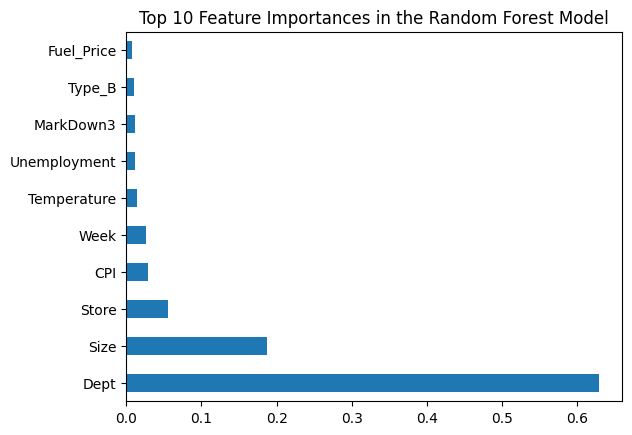

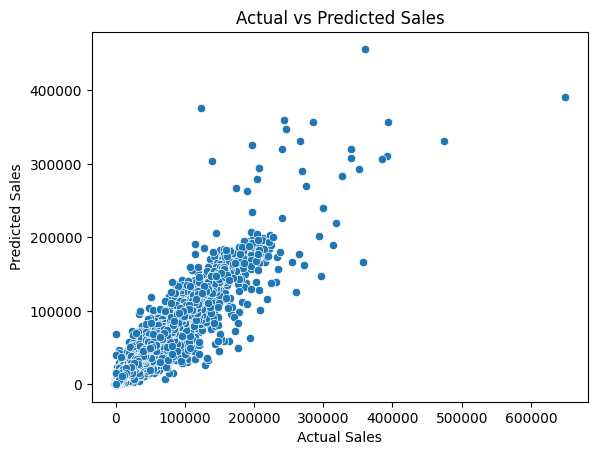

Root Mean Squared Error (RMSE): 4452.854948608919
R^2 Score: 0.962334722648165


In [ ]:
#Make predictions on the test set
y_pred = rf_model.predict(X_test)

#RMSE and R squared
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

#Feature Importance Plot
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances in the Random Forest Model')
plt.show()

#Scatter Plot of Actual vs Predicted Sales
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Question 2: How significant is the sales impact on holiday weeks vs non holiday weeks, and what holidays contribute the most to high sales periods?


In [ ]:
sales_data = pd.read_csv('https://raw.githubusercontent.com/cadengoodwin/SalesData/main/sales%20data-set.csv')
features_data = pd.read_csv('https://raw.githubusercontent.com/cadengoodwin/SalesData/main/Features%20data%20set.csv')
stores_data = pd.read_csv('https://raw.githubusercontent.com/cadengoodwin/SalesData/main/stores%20data-set.csv')


#Merge the sales data with stores data to include the type
sales_stores_data = pd.merge(sales_data, stores_data, on='Store', how='left')

In [ ]:
sales_stores_data['Date'] = pd.to_datetime(sales_stores_data['Date'])

holiday_defs = {
    'Super_Bowl': {'month': 2, 'days': [7, 8, 9, 10, 11, 12, 13]},
    'Labor_Day': {'month': 9, 'days': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
    'Thanksgiving': {'month': 11, 'days': [22, 23, 24, 25, 26, 27, 28]},
    'Christmas': {'month': 12, 'days': [24, 25, 26, 27, 28, 29, 30, 31]}
}

#Creating the holiday column to store the holiday name for each date
sales_stores_data['Holiday'] = 'Non-Holiday'
for holiday, info in holiday_defs.items():
    holiday_dates = sales_stores_data['Date'].apply(lambda x: x.month == info['month'] and x.day in info['days'])
    sales_stores_data.loc[holiday_dates, 'Holiday'] = holiday

#Filter out the non-holiday data for the first plot
holiday_sales_data = sales_stores_data[sales_stores_data['Holiday'] != 'Non-Holiday']


<ipython-input-8-7a4965644add>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales_stores_data['Date'] = pd.to_datetime(sales_stores_data['Date'])


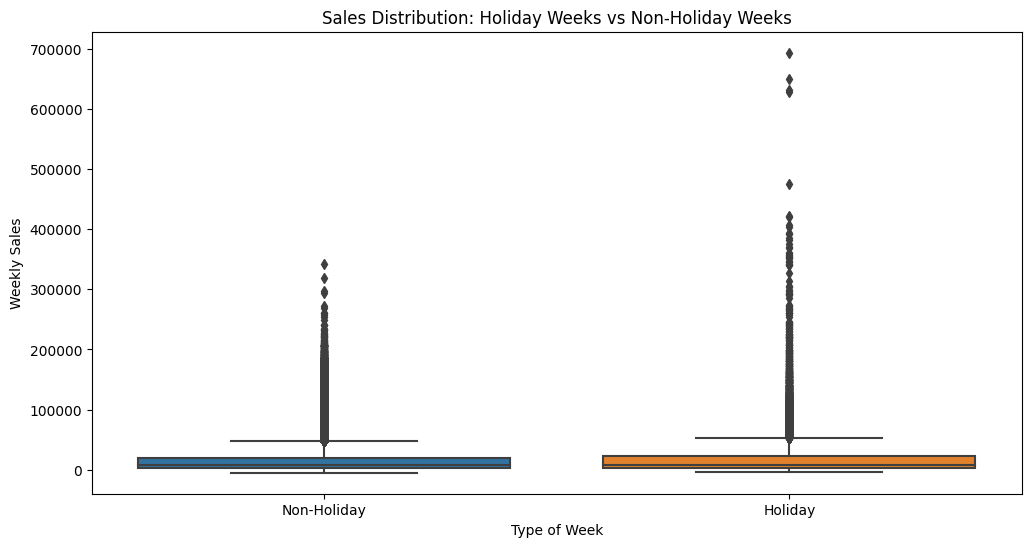

In [ ]:
#Make a binary 'IsHoliday' column combining all holidays
sales_stores_data['IsHoliday'] = sales_stores_data['Holiday'].apply(lambda x: x != 'Non-Holiday')

#Box plot for comparing sales distributions between all holiday weeks combined and non-holiday weeks
plt.figure(figsize=(12, 6))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=sales_stores_data)
plt.title('Sales Distribution: Holiday Weeks vs Non-Holiday Weeks')
plt.ylabel('Weekly Sales')
plt.xlabel('Type of Week')
plt.xticks([False, True], ['Non-Holiday', 'Holiday'])
plt.show()


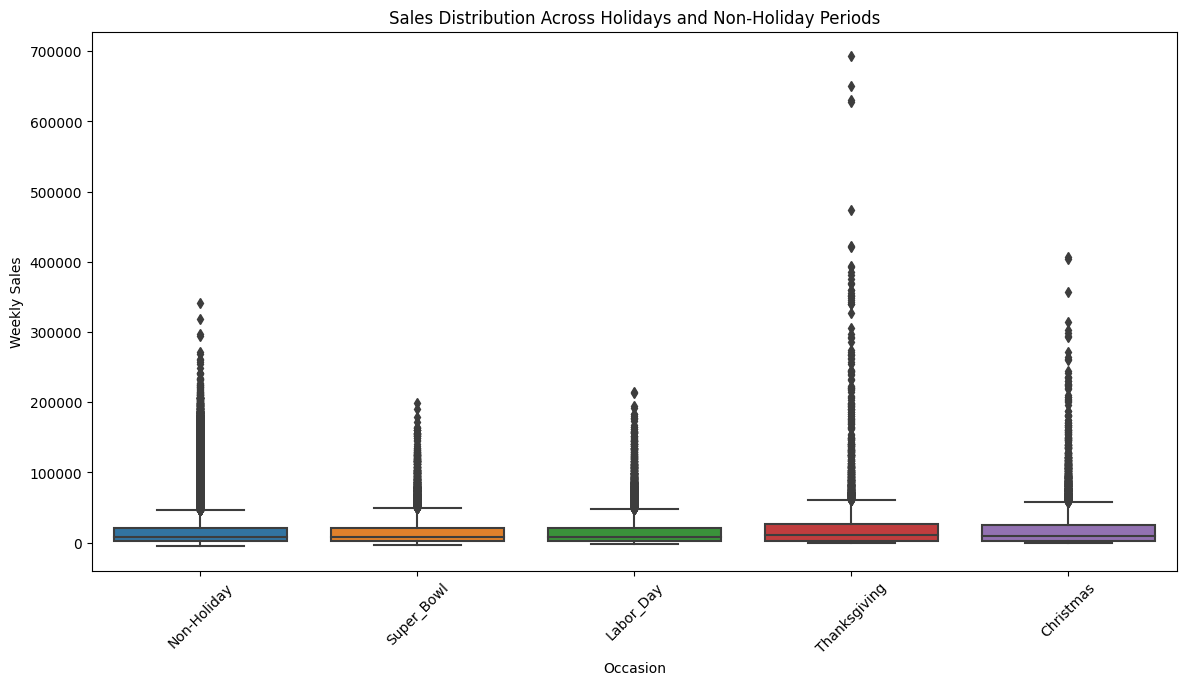

In [ ]:
#Box plot that compares the sales distributions for each specific holiday and non-holiday periods
plt.figure(figsize=(14, 7))
sns.boxplot(x='Holiday', y='Weekly_Sales', data=sales_stores_data, order=['Non-Holiday', 'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas'])
plt.title('Sales Distribution Across Holidays and Non-Holiday Periods')
plt.ylabel('Weekly Sales')
plt.xlabel('Occasion')
plt.xticks(rotation=45)
plt.show()

Question 3:  Which types of departments’ sales benefit the most when there are promotions (markdowns) going on? What are the results when using linear regression to predict Weekly_Sales using the variables: MarkDown1-5, Type, Dept, Date


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading datasets
sales_data_path = 'sales_data-set[1].csv'
features_data_path = 'Features_data_set[1].csv'
stores_data_path = 'stores_data-set[1].csv'


sales_data = pd.read_csv(sales_data_path)
features_data = pd.read_csv(features_data_path)
stores_data = pd.read_csv(stores_data_path)

# Merging datasets
merged_data = pd.merge(sales_data, stores_data, on='Store')

# Convert 'Date' to datetime in both merged_data and features_data for a consistent merge
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
features_data['Date'] = pd.to_datetime(features_data['Date'])
merged_data = pd.merge(merged_data, features_data, on=['Store', 'Date'])

<ipython-input-40-02228ceae9d2>:24: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  merged_data['Date'] = pd.to_datetime(merged_data['Date'])
<ipython-input-40-02228ceae9d2>:25: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  features_data['Date'] = pd.to_datetime(features_data['Date'])


<ipython-input-42-6d98c0022930>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Type'] = df_model['Type'].astype('category')


Mean Squared Error: 493604666.7194618
R-squared: 0.06109738502217943


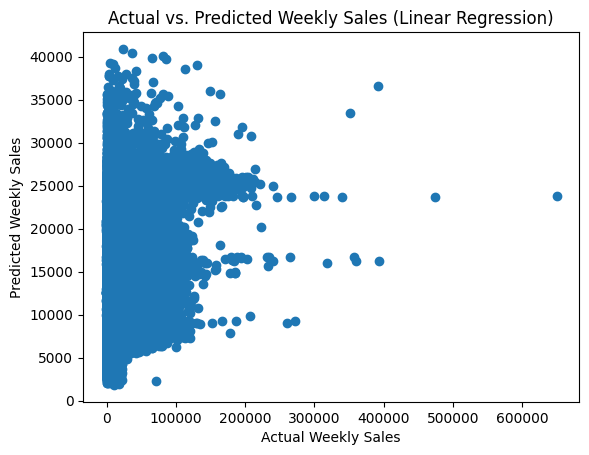

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



# relevant features
selected_features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Type', 'Dept', 'Date', 'Weekly_Sales']

df_model = merged_data[selected_features]

# Categorical dummies
df_model['Type'] = df_model['Type'].astype('category')

df_model = pd.get_dummies(df_model, columns=['Type'], drop_first=True)

# Convert 'Date' to datetime
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model['Year'] = df_model['Date'].dt.year
df_model['Month'] = df_model['Date'].dt.month
df_model['Day'] = df_model['Date'].dt.day
df_model = df_model.drop('Date', axis=1)

# Handle missing values by imputing with the mean
df_model = df_model.fillna(df_model.mean())

# Split data into features and target variable
X = df_model.drop('Weekly_Sales', axis=1)
y = df_model['Weekly_Sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Graph of predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('Actual vs. Predicted Weekly Sales (Linear Regression)')
plt.show()


<ipython-input-14-c1cbb5185569>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Date'] = pd.to_datetime(df_model['Date'])
<ipython-input-14-c1cbb5185569>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Year'] = df_model['Date'].dt.year
<ipython-input-14-c1cbb5185569>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

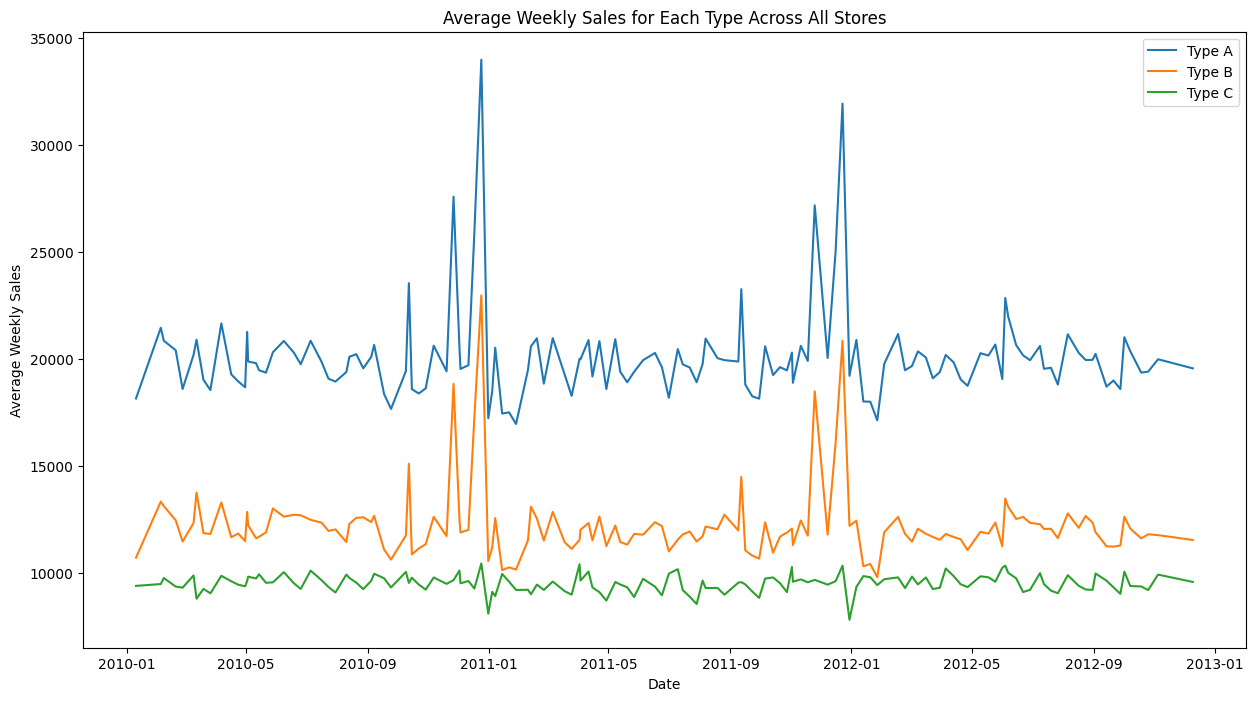

<ipython-input-14-c1cbb5185569>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Date'] = pd.to_datetime(df_model['Date'])
<ipython-input-14-c1cbb5185569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Year'] = df_model['Date'].dt.year
<ipython-input-14-c1cbb5185569>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

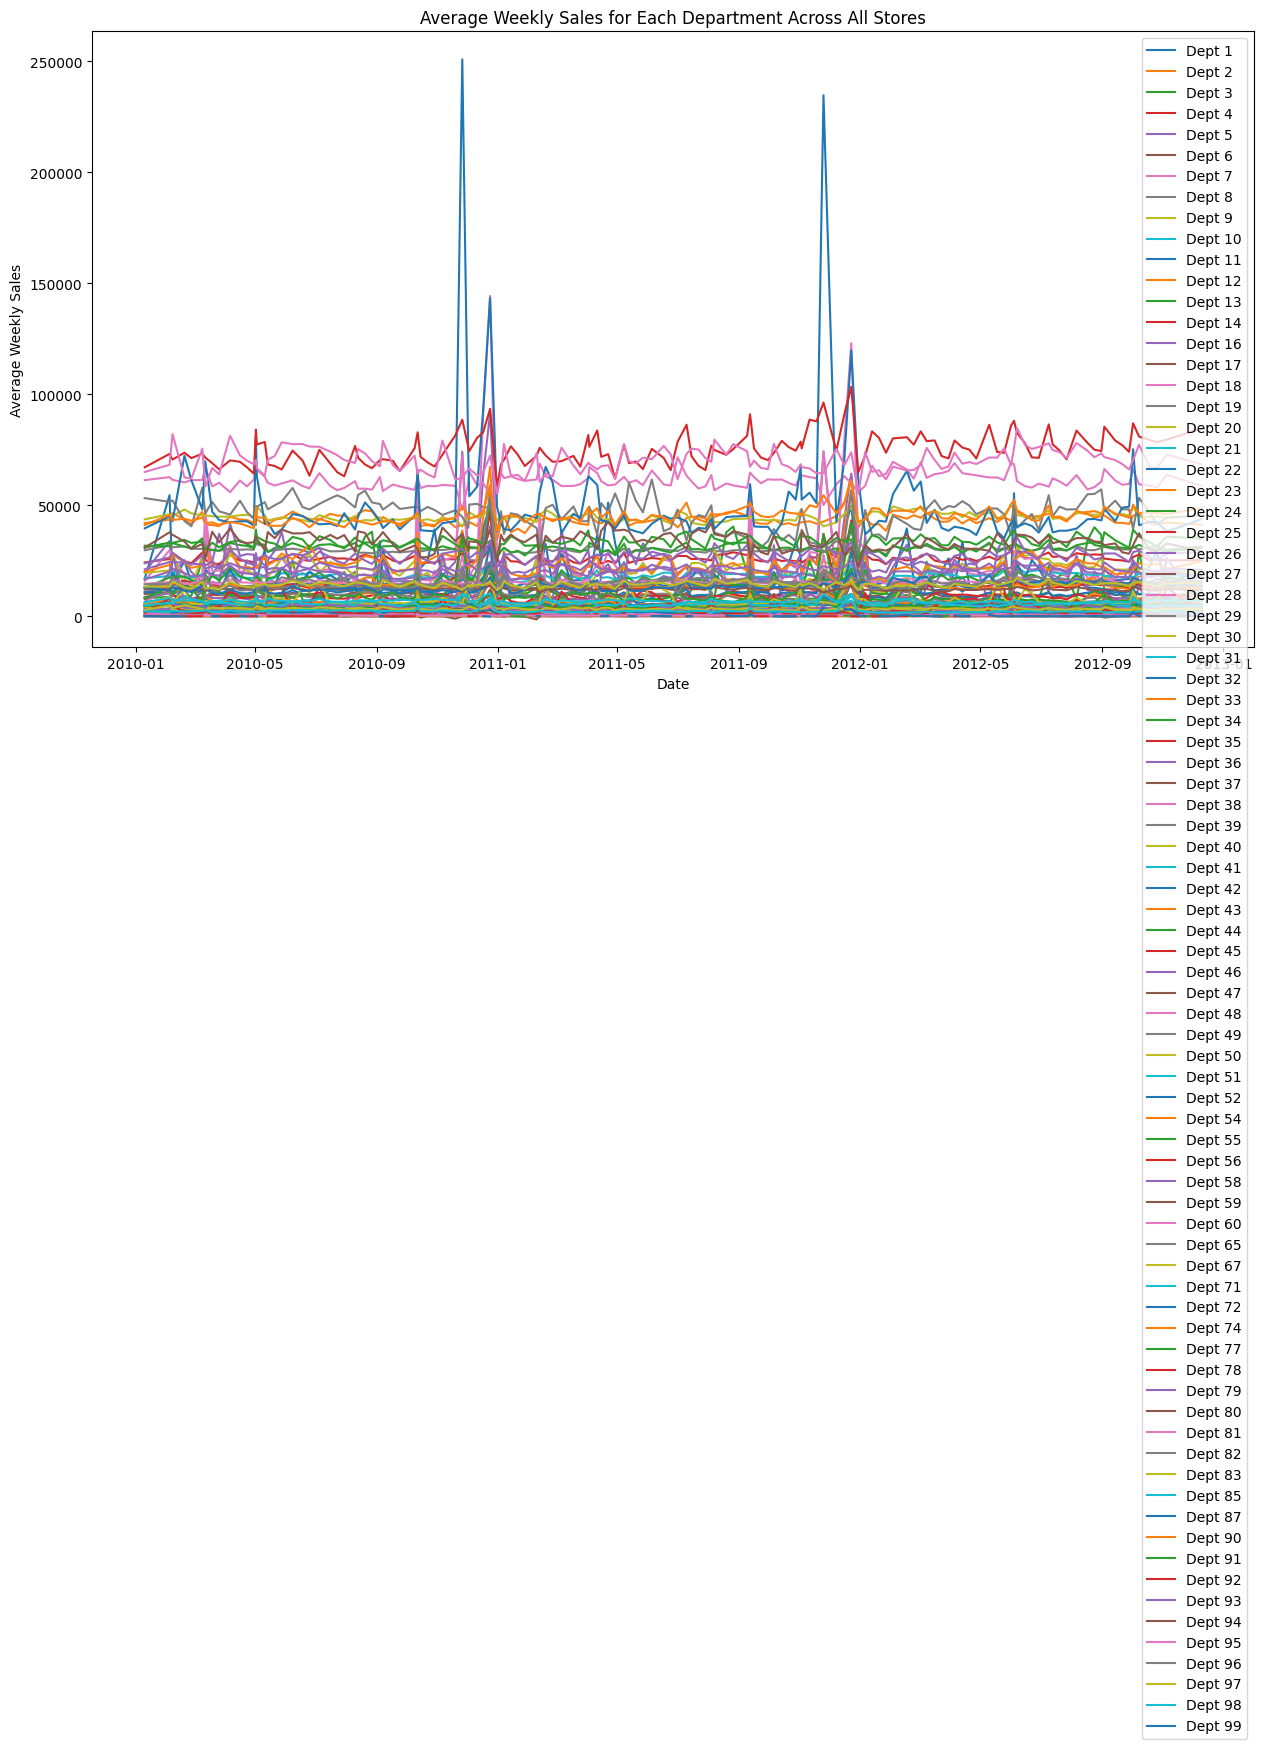

In [ ]:

# relevant features
selected_features = ['Type', 'Date', 'Weekly_Sales']

df_model = merged_data[selected_features]

# Convert 'Date' to datetime
df_model['Date'] = pd.to_datetime(df_model['Date'])

# Extracting numerical features from the datetime
df_model['Year'] = df_model['Date'].dt.year
df_model['Month'] = df_model['Date'].dt.month
df_model['Day'] = df_model['Date'].dt.day

# Group by 'Type' and 'Date' and calculate the average weekly sales
average_sales_by_type = df_model.groupby(['Type', 'Date'])['Weekly_Sales'].mean().reset_index()

# Pivot the data for easier plotting
pivot_table = average_sales_by_type.pivot(index='Date', columns='Type', values='Weekly_Sales')

# Plotting the graph
plt.figure(figsize=(15, 8))

for store_type in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[store_type], label=f'Type {store_type}')

plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales for Each Type Across All Stores')
plt.legend()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
# Select relevant features
selected_features = ['Dept', 'Date', 'Weekly_Sales']

df_model = merged_data[selected_features]

# Convert 'Date' to datetime
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model['Year'] = df_model['Date'].dt.year
df_model['Month'] = df_model['Date'].dt.month
df_model['Day'] = df_model['Date'].dt.day

# Group by 'Dept' and 'Date' and calculate the average weekly sales
average_sales_by_dept = df_model.groupby(['Dept', 'Date'])['Weekly_Sales'].mean().reset_index()

pivot_table = average_sales_by_dept.pivot(index='Date', columns='Dept', values='Weekly_Sales')

# Plotting the graph
plt.figure(figsize=(15, 8))

for dept in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[dept], label=f'Dept {dept}')

plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales for Each Department Across All Stores')
plt.legend()
plt.show()


Number of different stores with 'Type' 'C': 6
Number of different stores with 'Type' 'B': 17
Number of different stores with 'Type' 'A': 22
Stores without Department 1: set()
Stores without Department 2: set()
Stores without Department 3: set()
Stores without Department 4: set()
Stores without Department 5: set()
Stores without Department 6: set()
Stores without Department 7: set()
Stores without Department 8: set()
Stores without Department 9: set()
Stores without Department 10: set()
Stores without Department 11: set()
Stores without Department 12: set()
Stores without Department 13: set()
Stores without Department 14: set()
Stores without Department 15: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}
Stores without Department 16: set()
Stores without Department 17: set()
Stores without Department 18: set()
Stores without Department 19: {33, 36, 37, 38, 42, 43, 

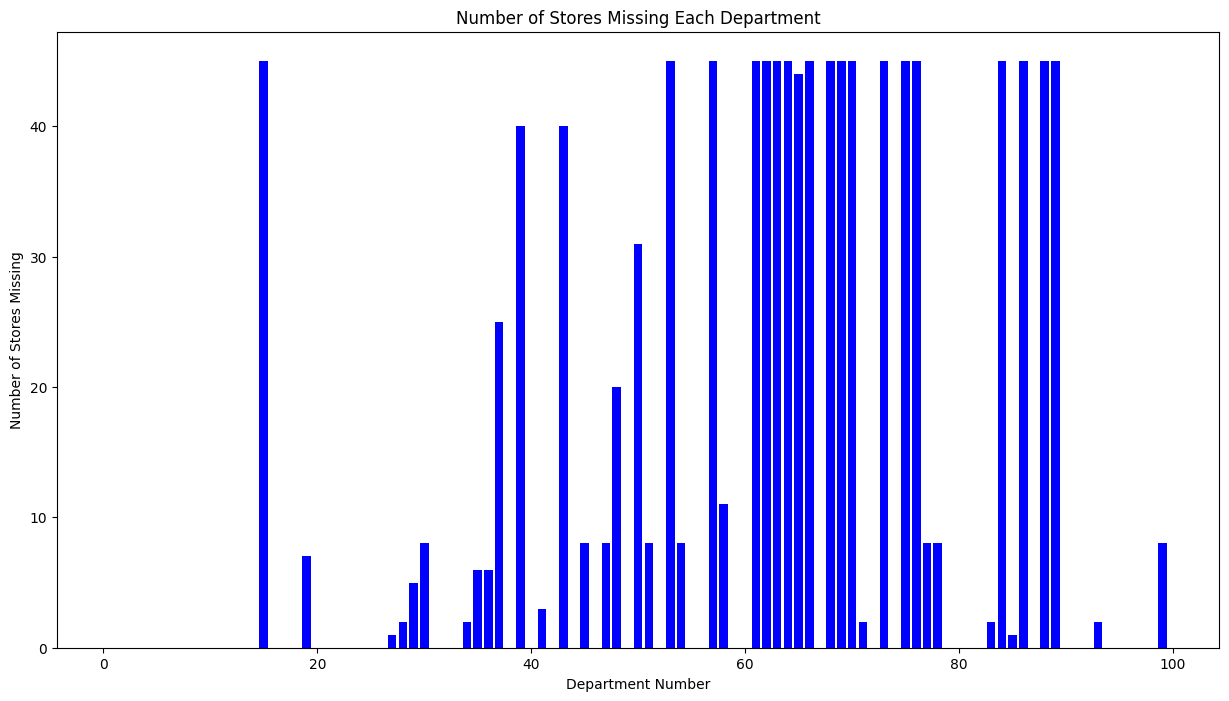

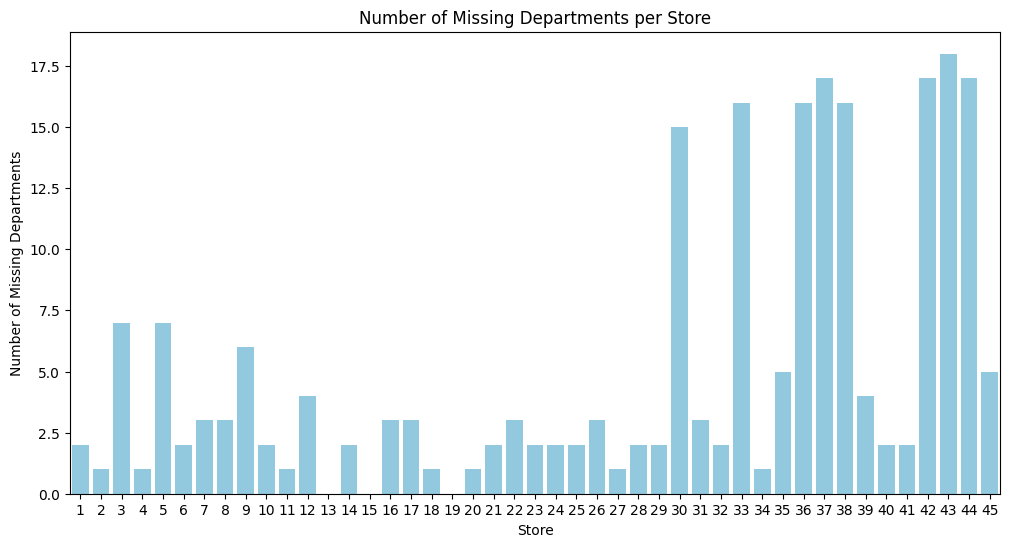

In [ ]:


import pandas as pd
# Filter the data for Type C
type_c_data = merged_data[merged_data['Type'] == 'C']

# Get unique store counts for Type C
unique_stores_type_c = type_c_data['Store'].nunique()

print(f"Number of different stores with 'Type' 'C': {unique_stores_type_c}")

# Filter the data for Type B
type_b_data = merged_data[merged_data['Type'] == 'B']

# Get unique store counts for Type B
unique_stores_type_b = type_b_data['Store'].nunique()

print(f"Number of different stores with 'Type' 'B': {unique_stores_type_b}")

# Filter the data for Type A
type_a_data = merged_data[merged_data['Type'] == 'A']

# Get unique store counts for Type A
unique_stores_type_a = type_a_data['Store'].nunique()

print(f"Number of different stores with 'Type' 'A': {unique_stores_type_a}")
import pandas as pd

# Get a list of all stores
all_stores = merged_data['Store'].unique()

# Iterate through each department (1-99)
for target_dept in range(1, 100):
    # Get a list of stores with the specified department
    stores_with_dept = merged_data[merged_data['Dept'] == target_dept]['Store'].unique()

    # Find stores that don't have the specified department
    stores_without_dept = set(all_stores) - set(stores_with_dept)

    # Print the result
    print(f"Stores without Department {target_dept}: {stores_without_dept}")

import matplotlib.pyplot as plt

# Get a list of all stores
all_stores = merged_data['Store'].unique()

# Create a DataFrame to store the results
missing_stores_df = pd.DataFrame(index=range(1, 100), columns=['Missing Stores'])

# Iterate through each department (1-99)
for target_dept in range(1, 100):
    stores_with_dept = merged_data[merged_data['Dept'] == target_dept]['Store'].unique()
    stores_without_dept = set(all_stores) - set(stores_with_dept)

# Store the result in the DataFrame
    missing_stores_df.loc[target_dept, 'Missing Stores'] = len(stores_without_dept)

# Plotting the graph
plt.figure(figsize=(15, 8))
plt.bar(missing_stores_df.index, missing_stores_df['Missing Stores'], color='blue')
plt.xlabel('Department Number')
plt.ylabel('Number of Stores Missing')
plt.title('Number of Stores Missing Each Department')
plt.show()

# Count the number of missing departments for each store
missing_departments_count = merged_data.groupby('Store')['Dept'].nunique().max() - merged_data.groupby('Store')['Dept'].nunique()

# Create a bar plot for the number of missing departments per store
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_departments_count.index, y=missing_departments_count.values, color='skyblue')
plt.title('Number of Missing Departments per Store')
plt.xlabel('Store')
plt.ylabel('Number of Missing Departments')
plt.show()




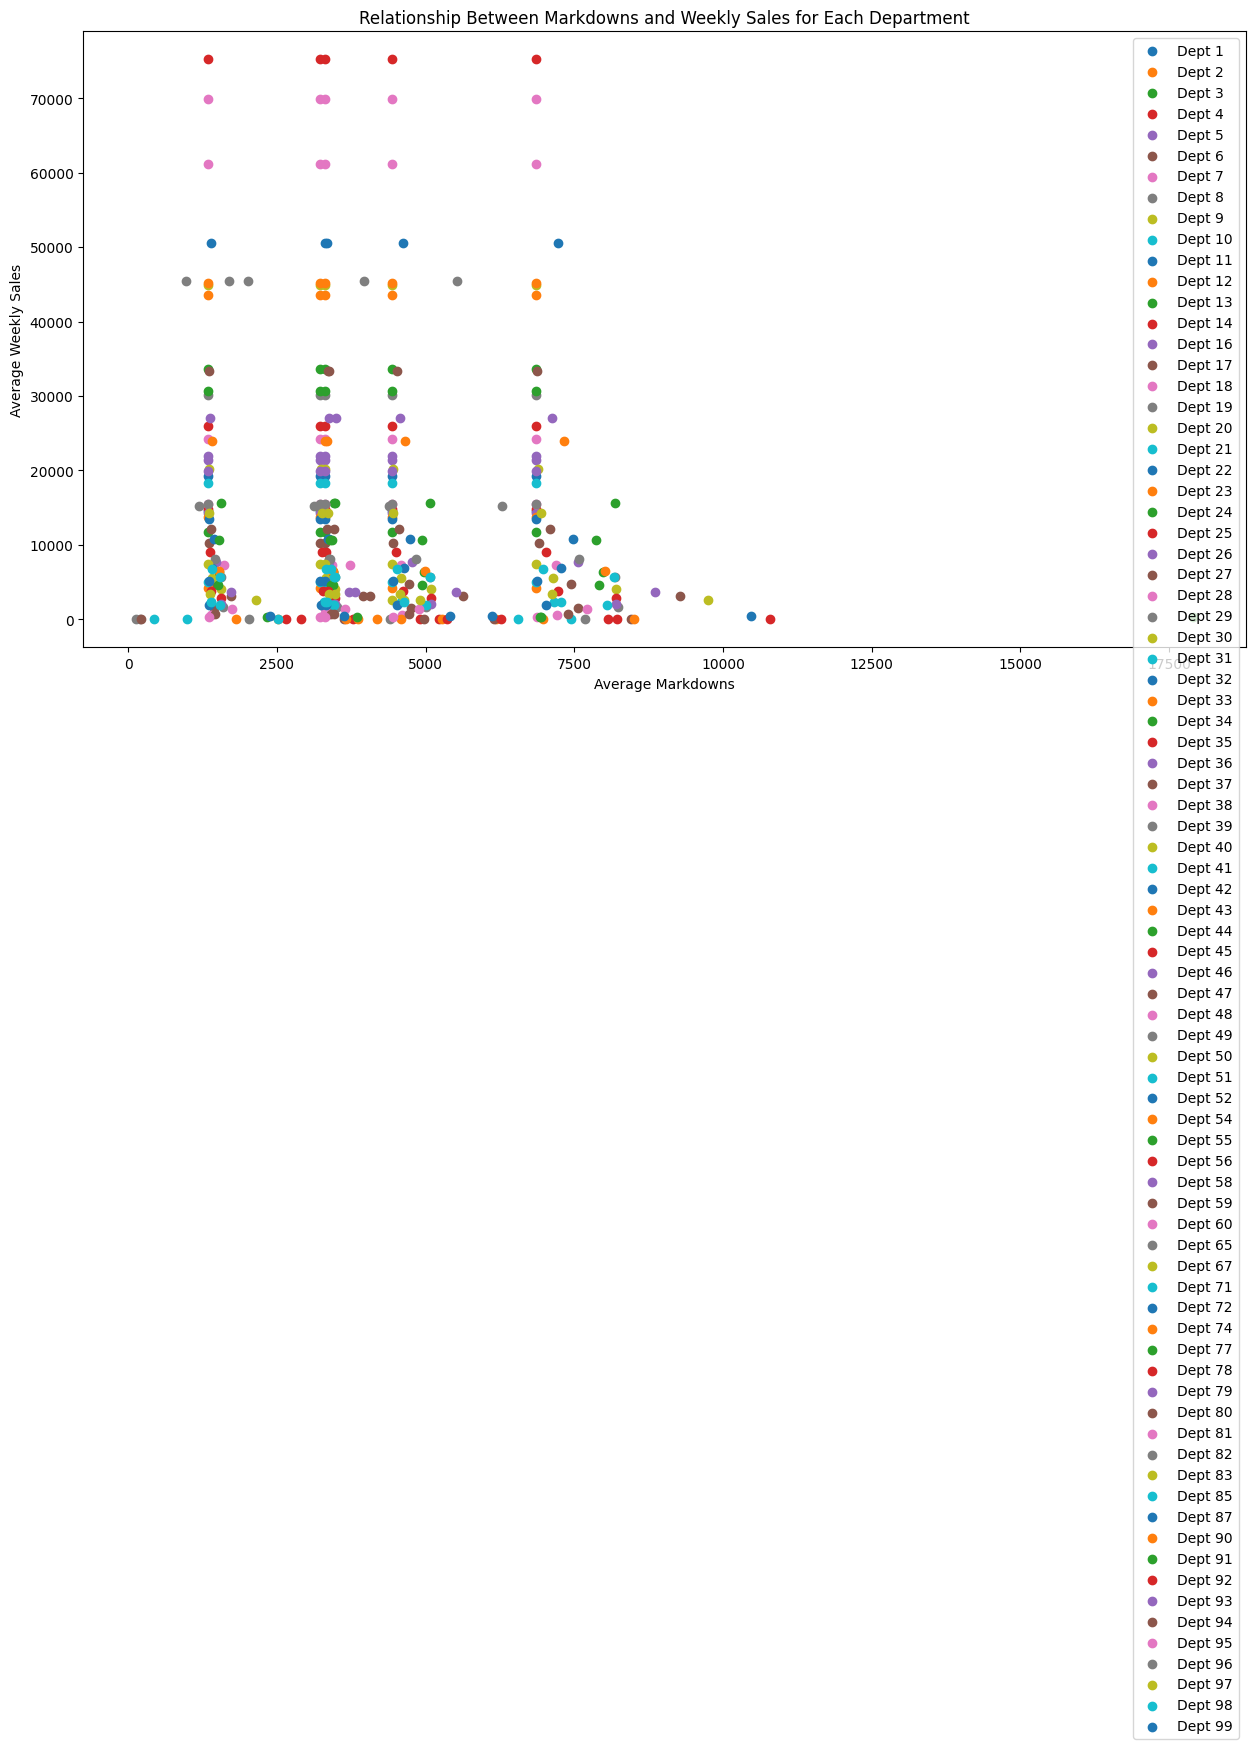

In [ ]:
# relevant features
selected_features = ['Dept', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales']

df_model = merged_data[selected_features]

# Group by department and calculate the average weekly sales and markdowns
average_sales_and_markdowns = df_model.groupby('Dept').mean()

# Filter out rows with missing values in either MarkDown or Weekly_Sales
average_sales_and_markdowns = average_sales_and_markdowns.dropna(subset=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales'])

# Plotting the graph
plt.figure(figsize=(15, 8))

# Scatter plot for each department
for dept in average_sales_and_markdowns.index:
    markdown_values = average_sales_and_markdowns.loc[dept, 'MarkDown1':'MarkDown5']
    weekly_sales_value = average_sales_and_markdowns.loc[dept, 'Weekly_Sales']

    # Scatter plot with multiple x values for each y value
    plt.scatter(markdown_values, [weekly_sales_value] * len(markdown_values), label=f'Dept {dept}')

plt.xlabel('Average Markdowns')
plt.ylabel('Average Weekly Sales')
plt.title('Relationship Between Markdowns and Weekly Sales for Each Department')
plt.legend()
plt.show()



Question 4: Which markdown types 1-5 are most effective in increasing overall sales? Are there better markdown promotions for certain departments?   


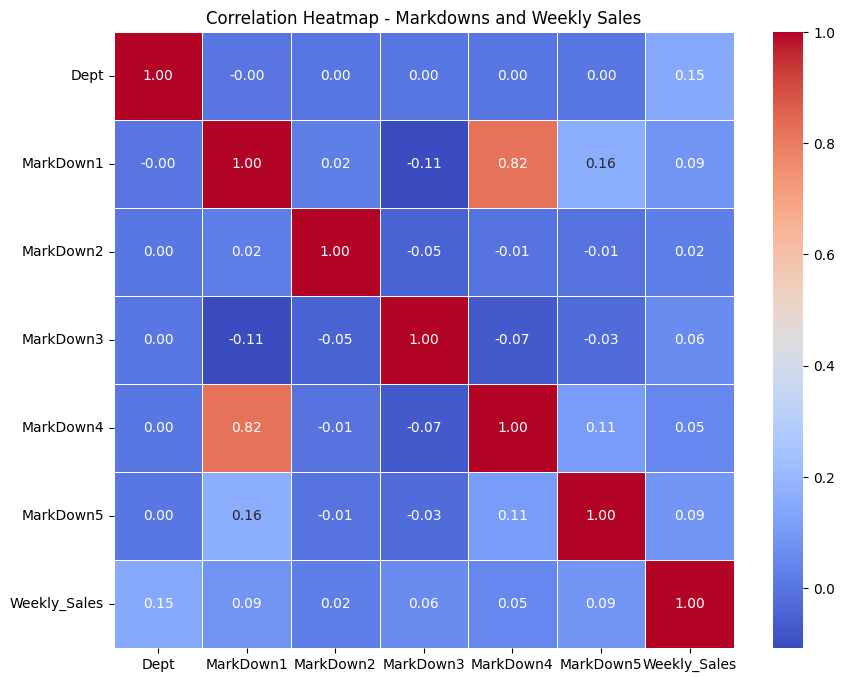

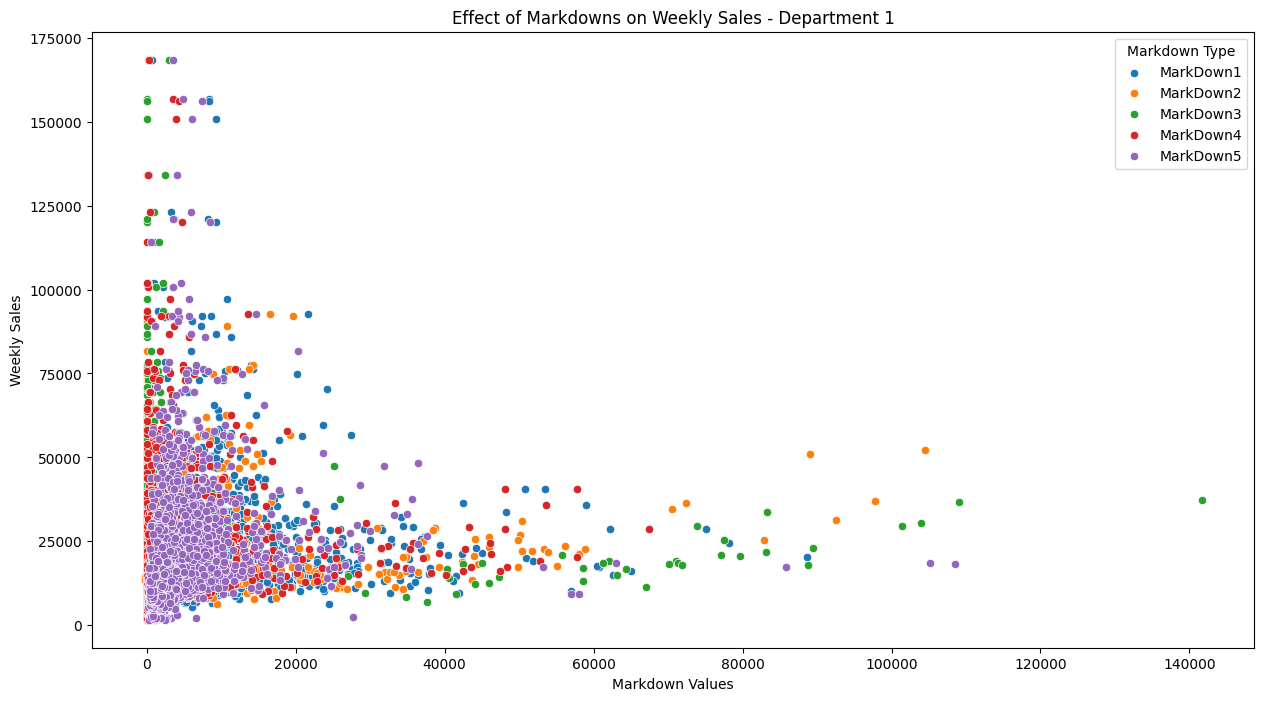

In [ ]:
# relevant features
selected_features = ['Dept', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales']

df_model = merged_data[selected_features]

# Calculate the correlation matrix
correlation_matrix = df_model.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap - Markdowns and Weekly Sales')
plt.show()

# analyze Department 1
department_1_data = df_model[df_model['Dept'] == 1]

plt.figure(figsize=(15, 8))

# Scatter plot for each markdown type
for markdown_type in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    sns.scatterplot(x=markdown_type, y='Weekly_Sales', data=department_1_data, label=markdown_type)

plt.title('Effect of Markdowns on Weekly Sales - Department 1')
plt.xlabel('Markdown Values')
plt.ylabel('Weekly Sales')
plt.legend(title='Markdown Type')
plt.show()


Mean Squared Error: 511202716.93436205


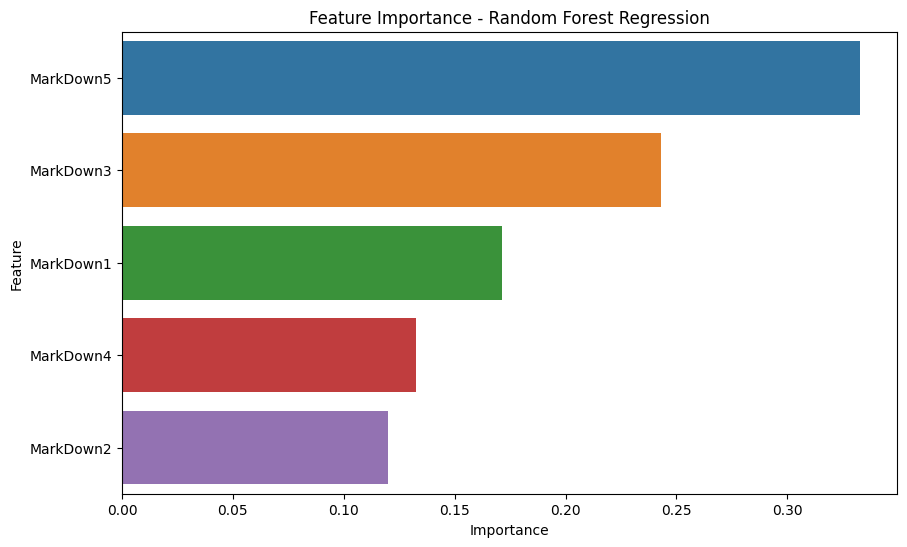

In [ ]:

# Features
selected_features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales']

df_model = merged_data[selected_features]

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
df_model_imputed = pd.DataFrame(imputer.fit_transform(df_model), columns=df_model.columns)

# Split data into features and target variable
X = df_model_imputed.drop('Weekly_Sales', axis=1)
y = df_model_imputed['Weekly_Sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Feature importance analysis
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sorting features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Random Forest Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



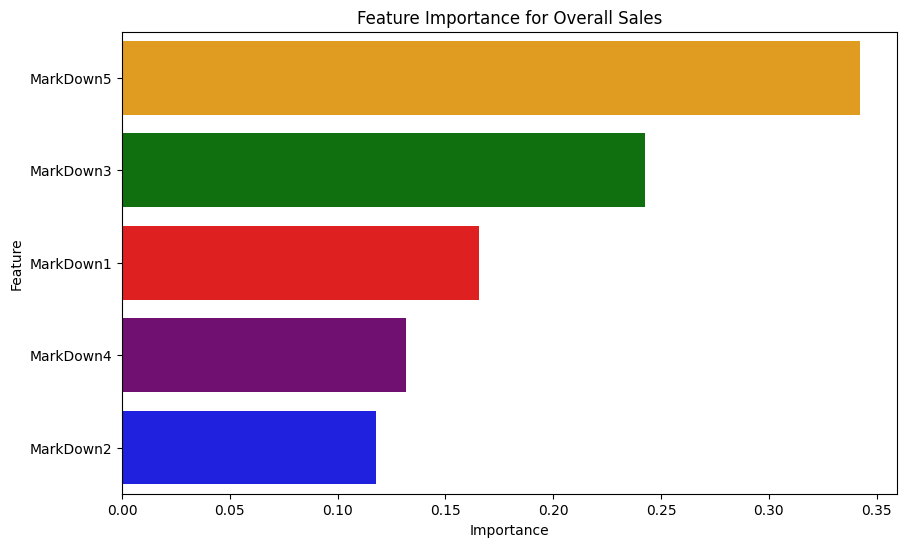

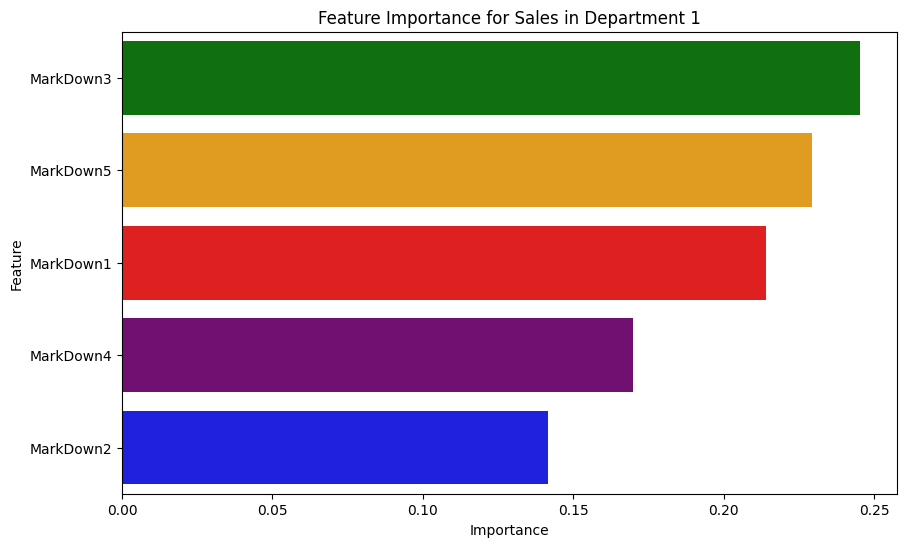

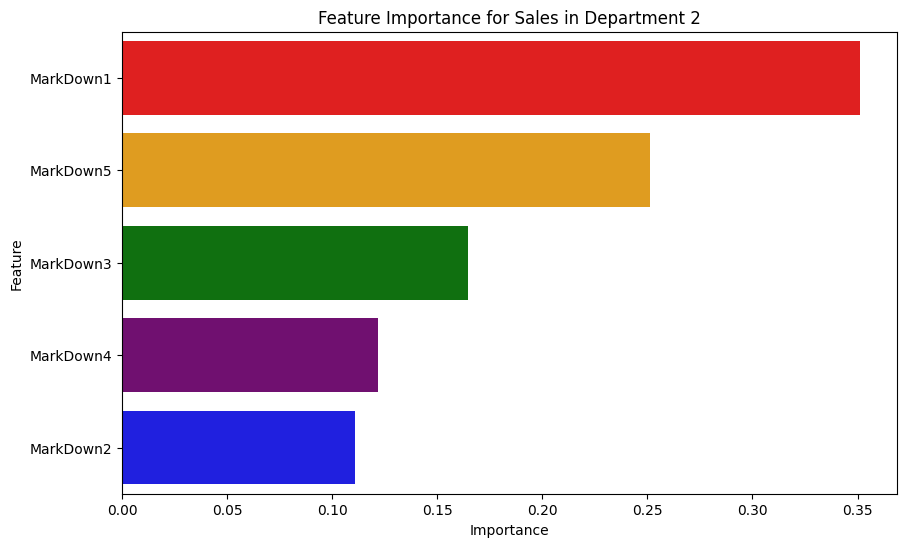

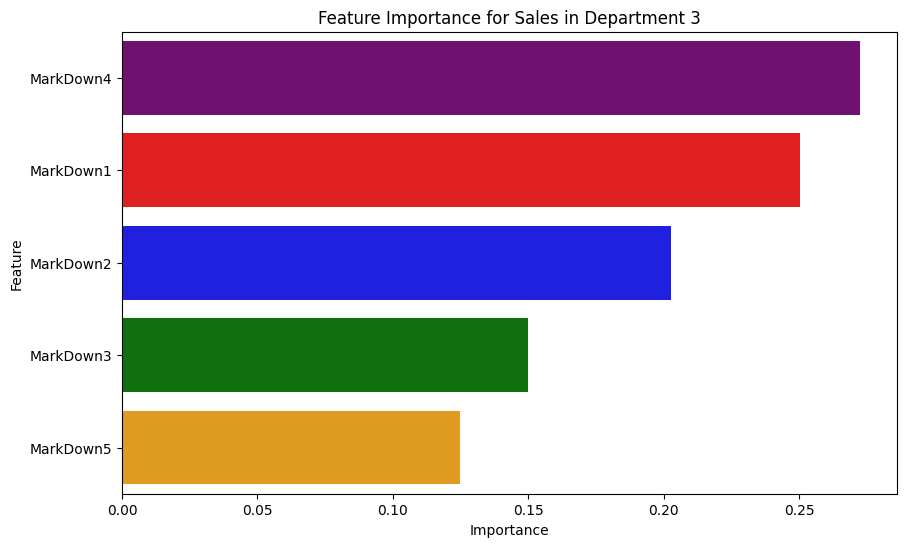

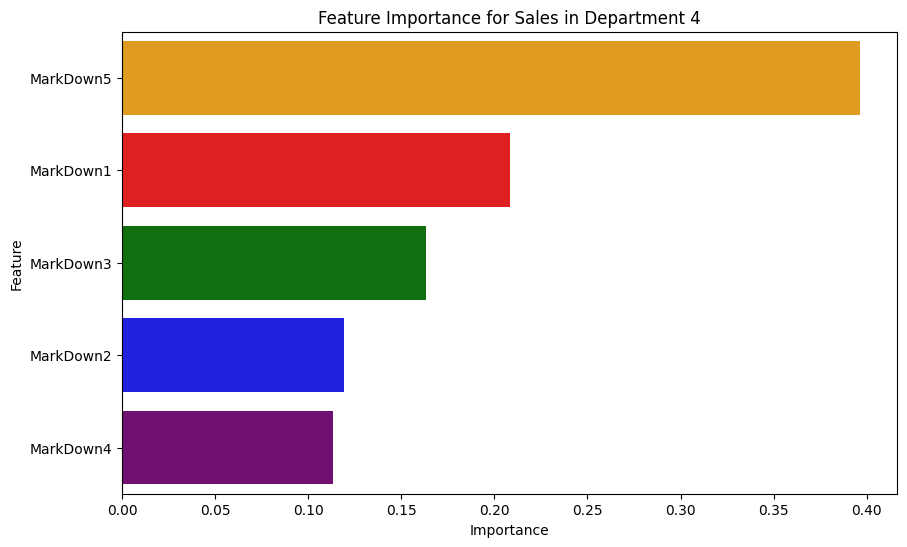

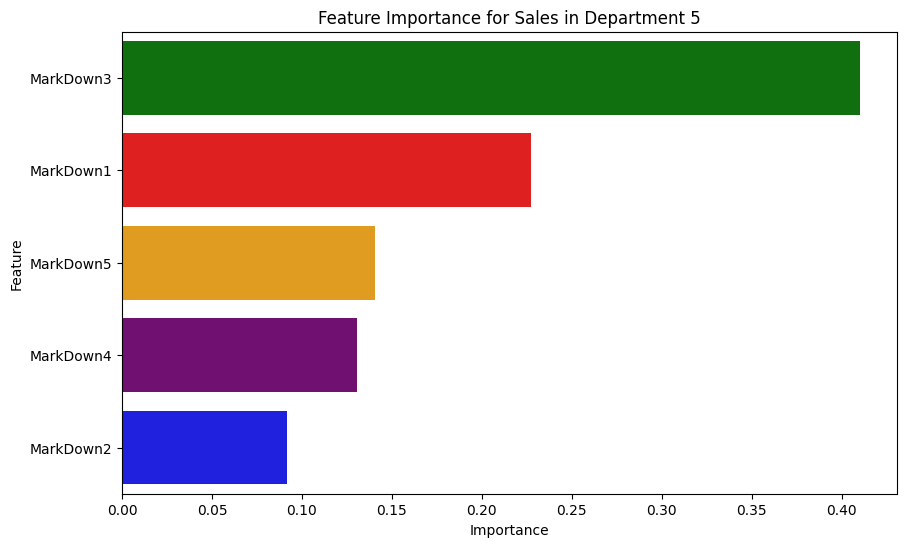

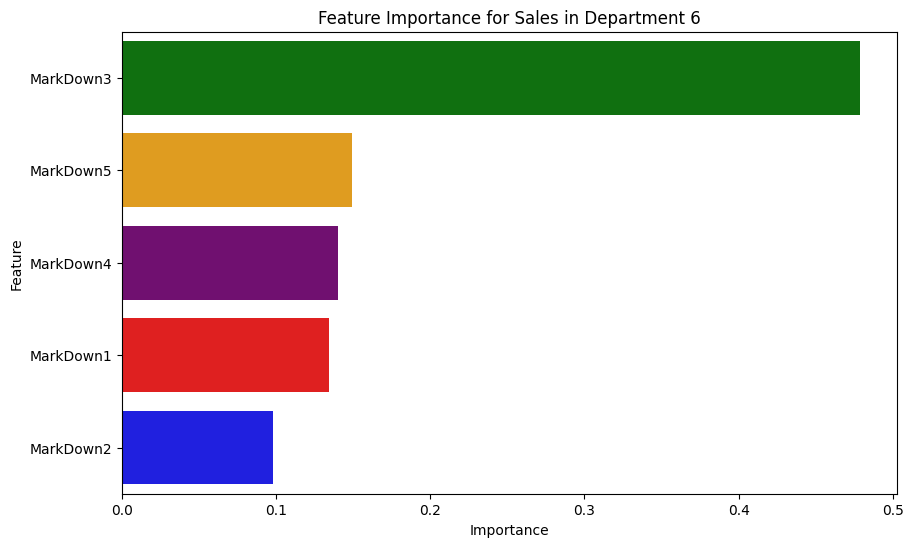

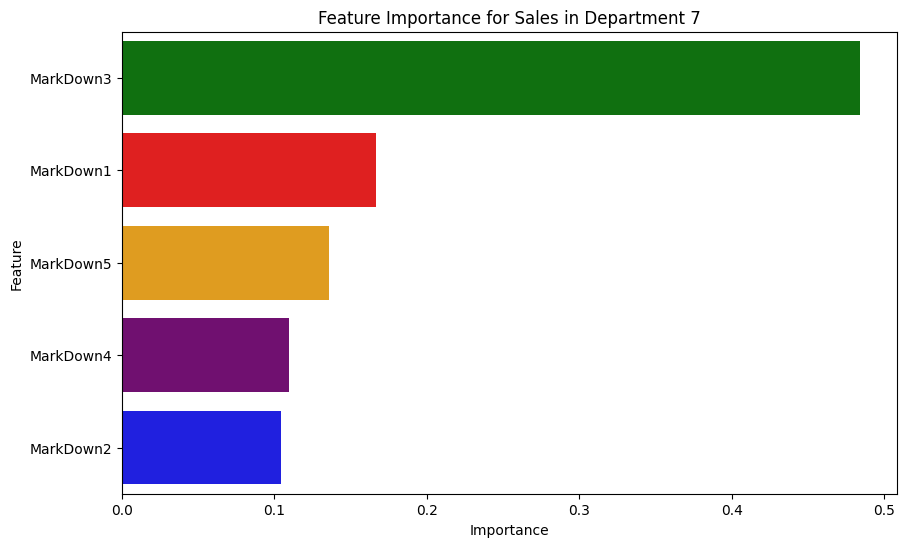

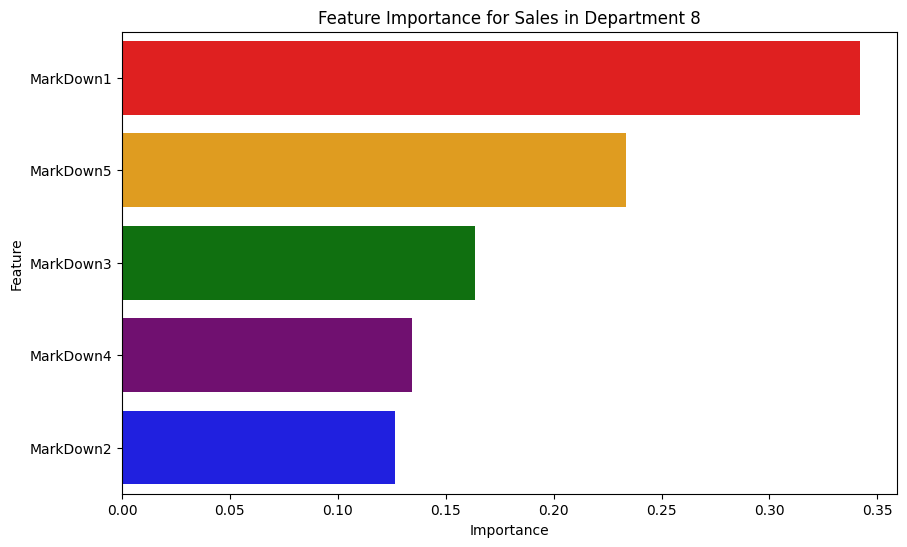

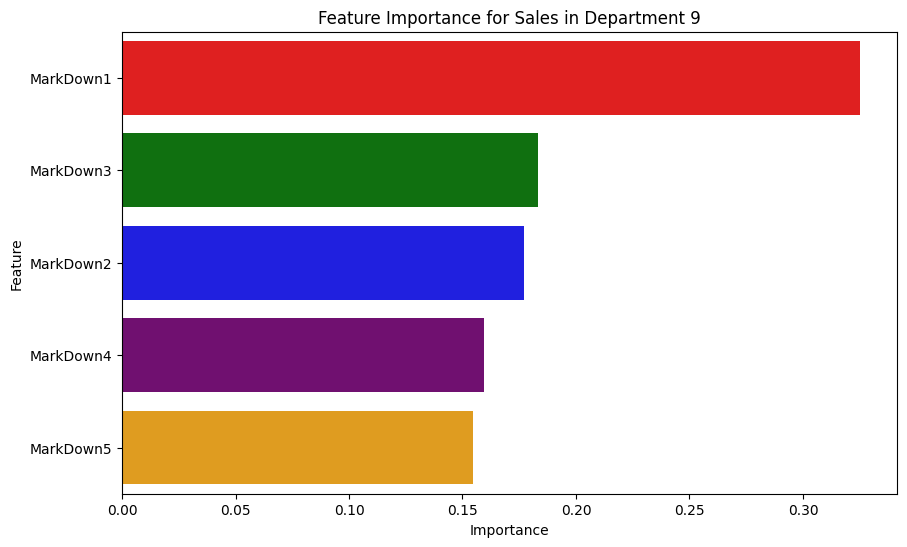

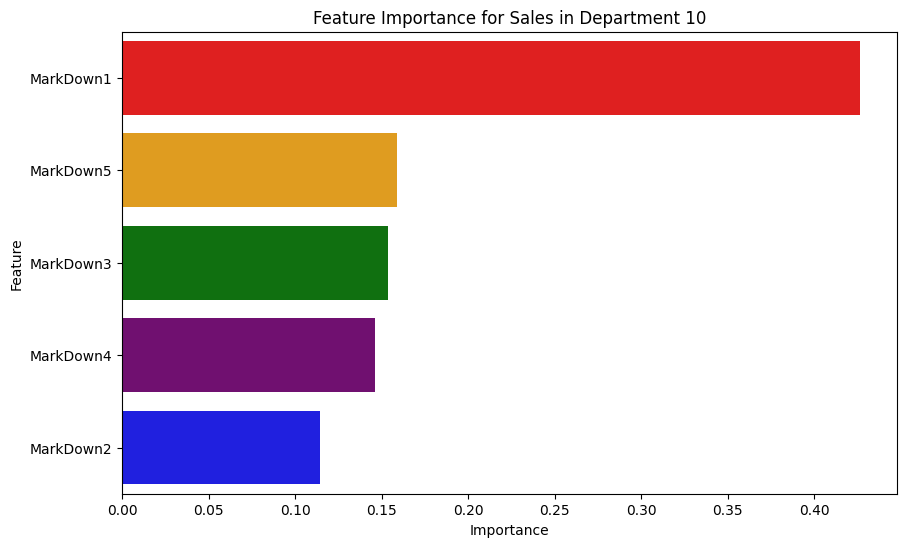

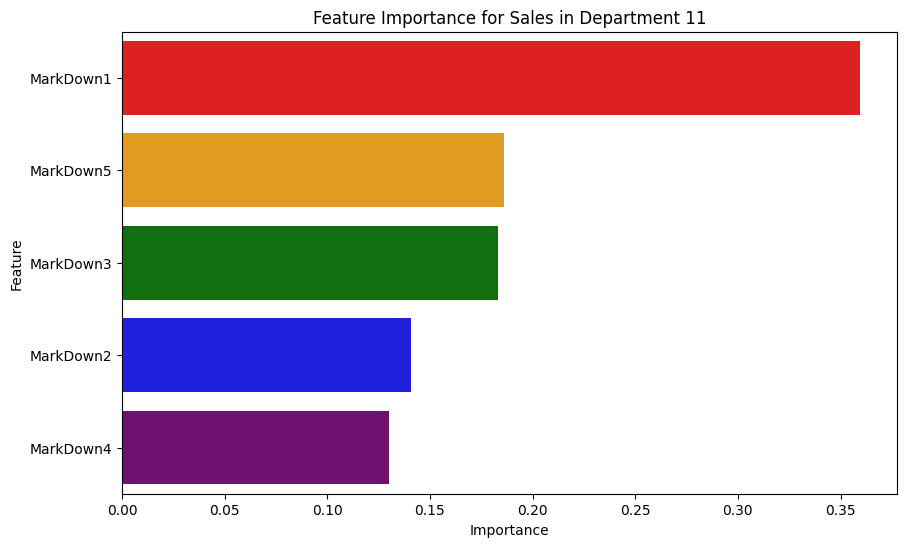

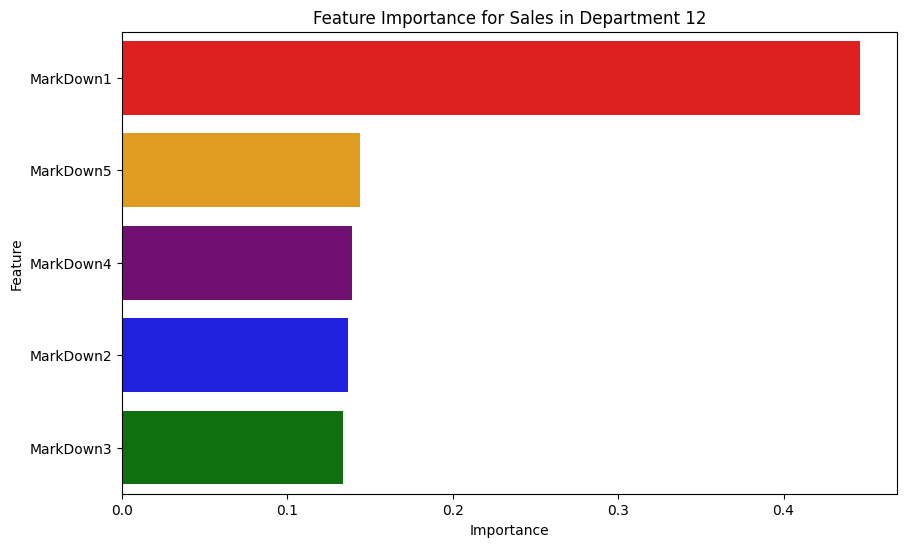

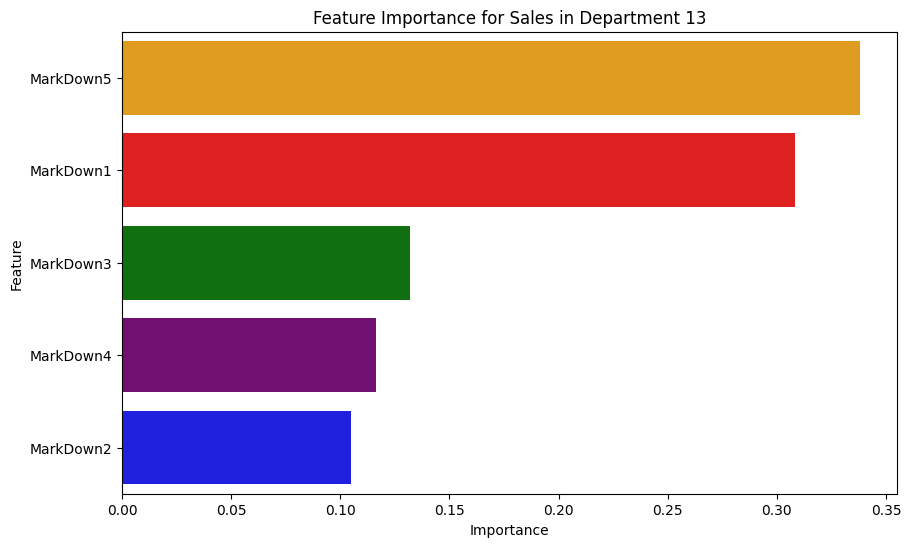

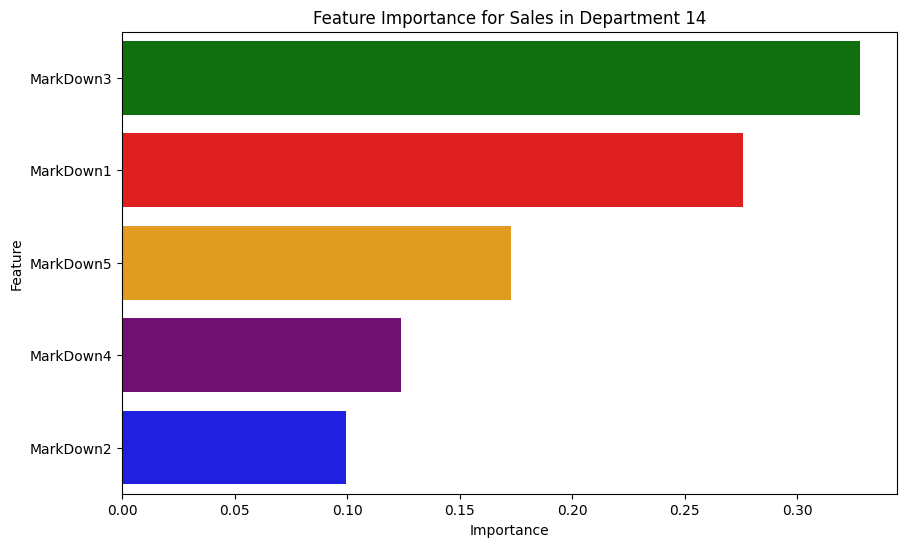

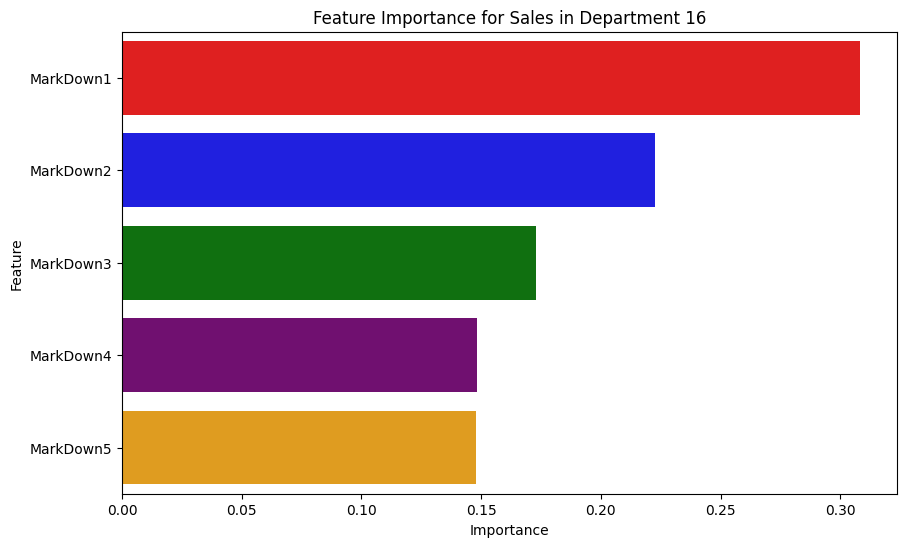

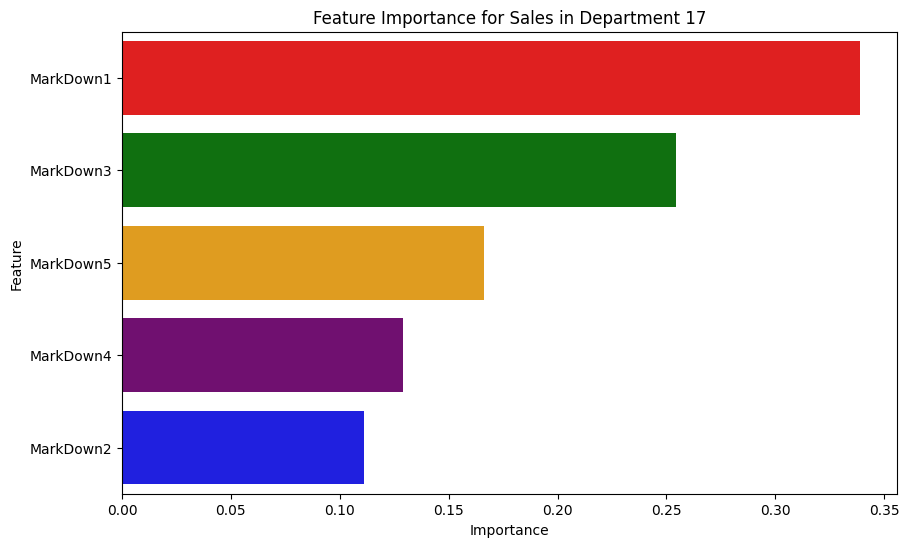

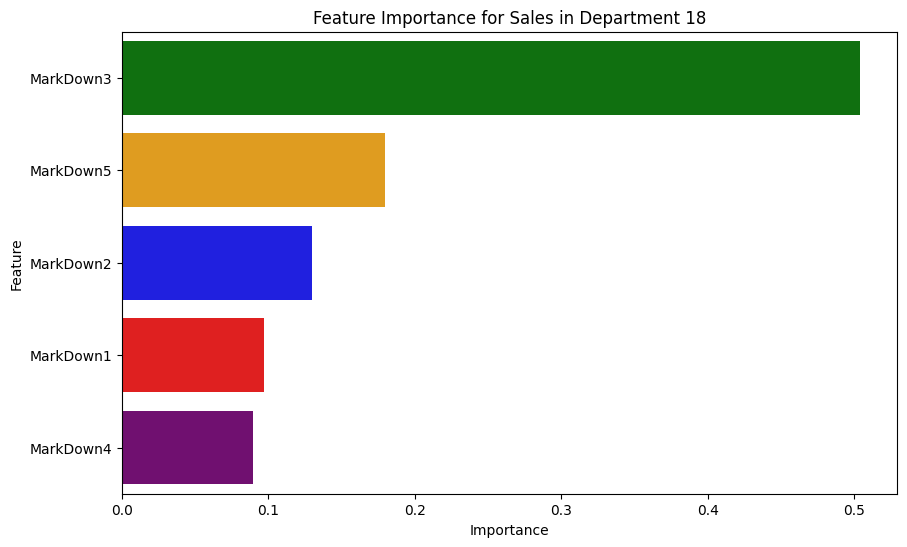

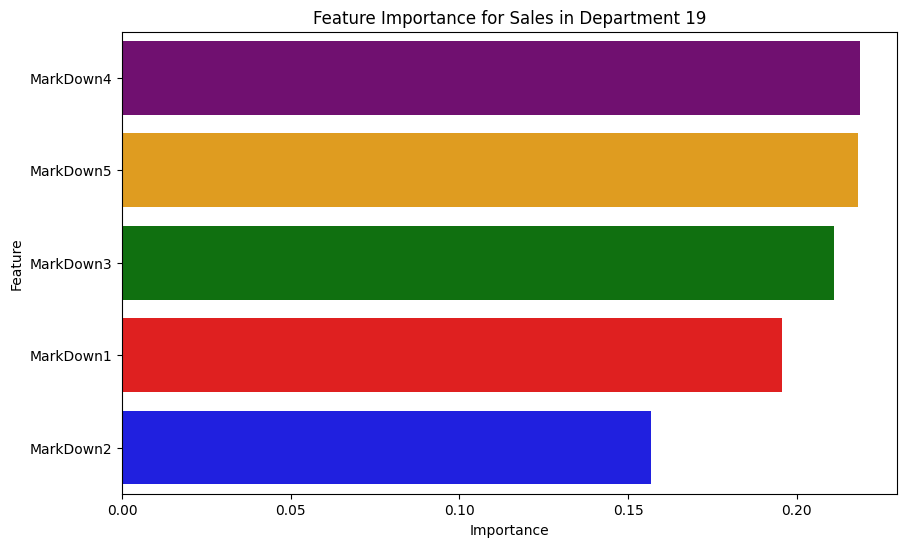

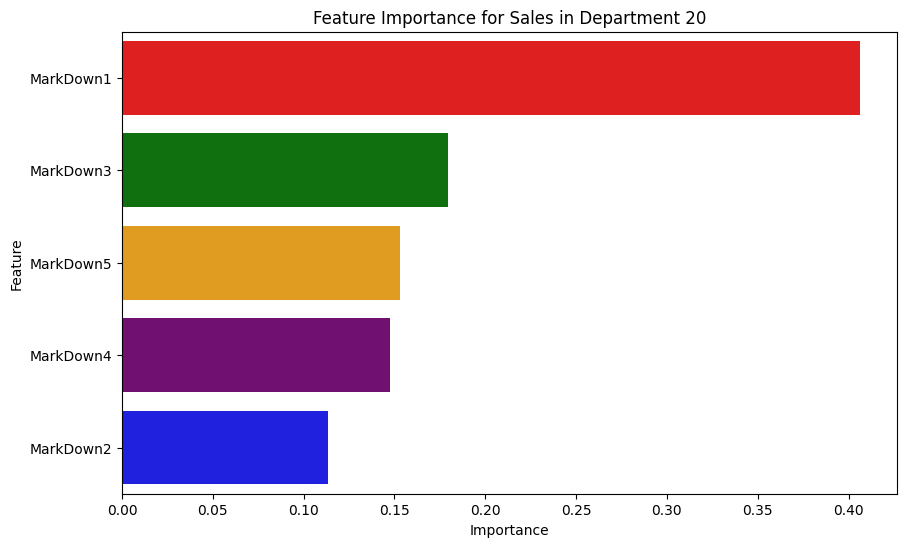

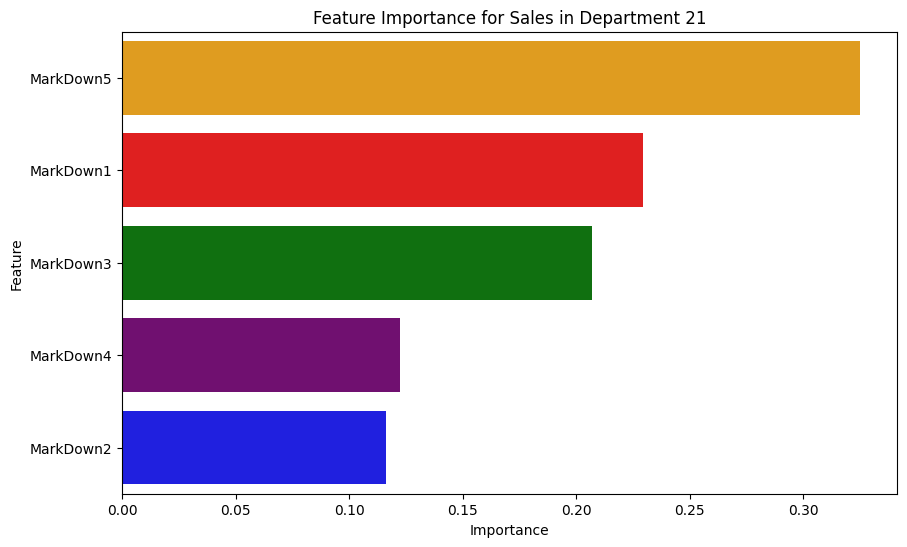

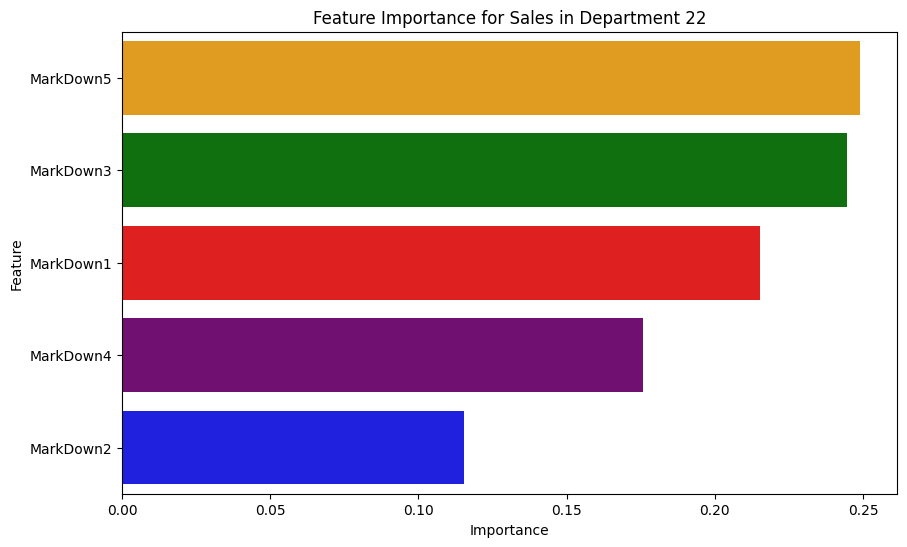

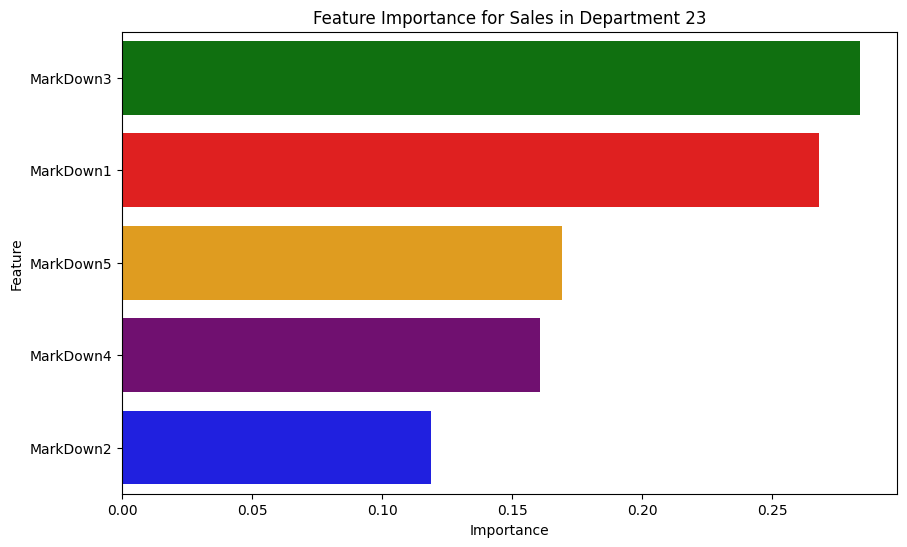

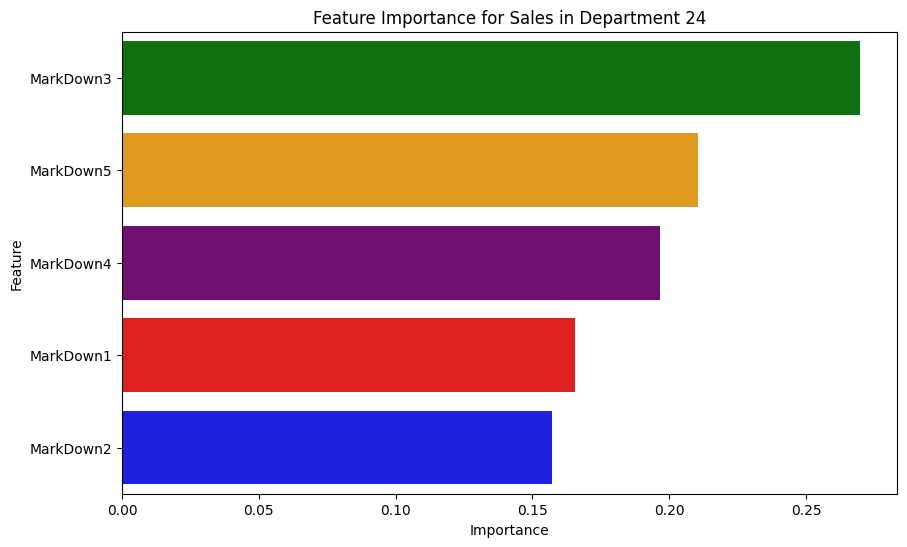

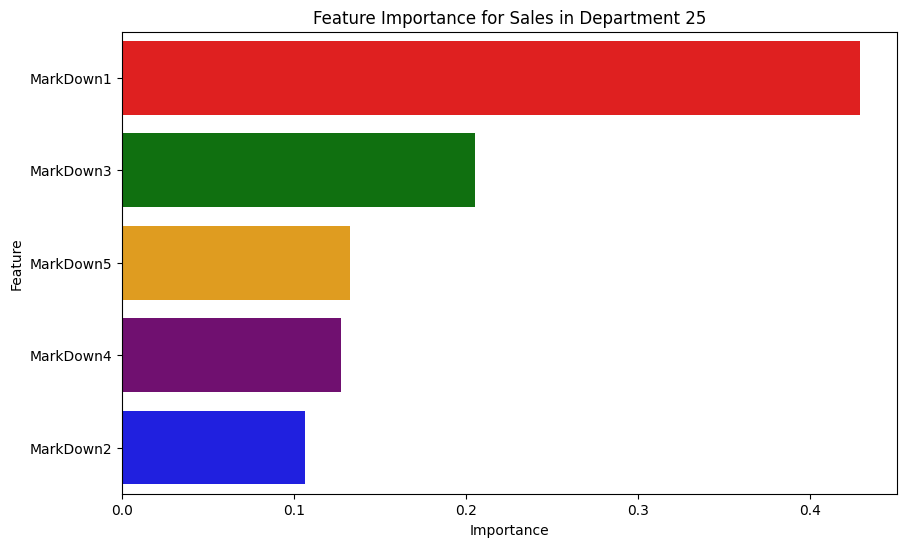

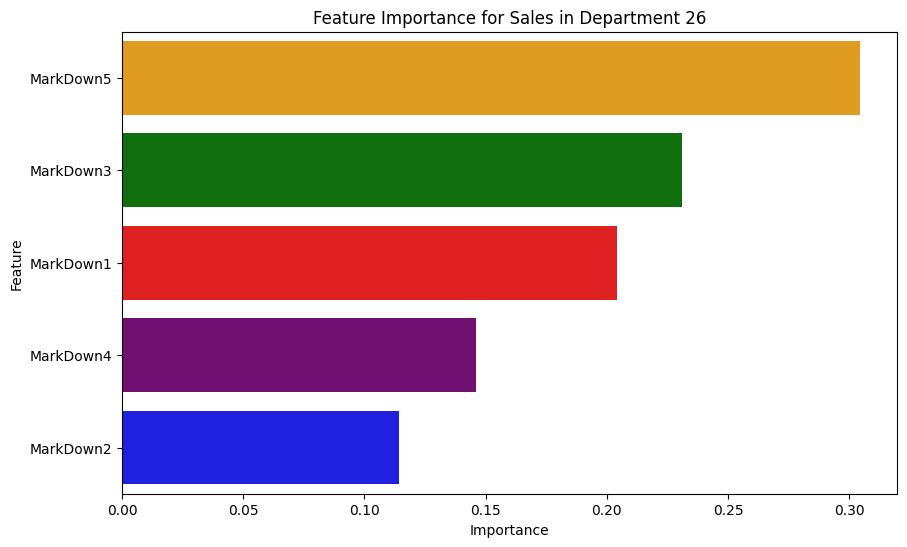

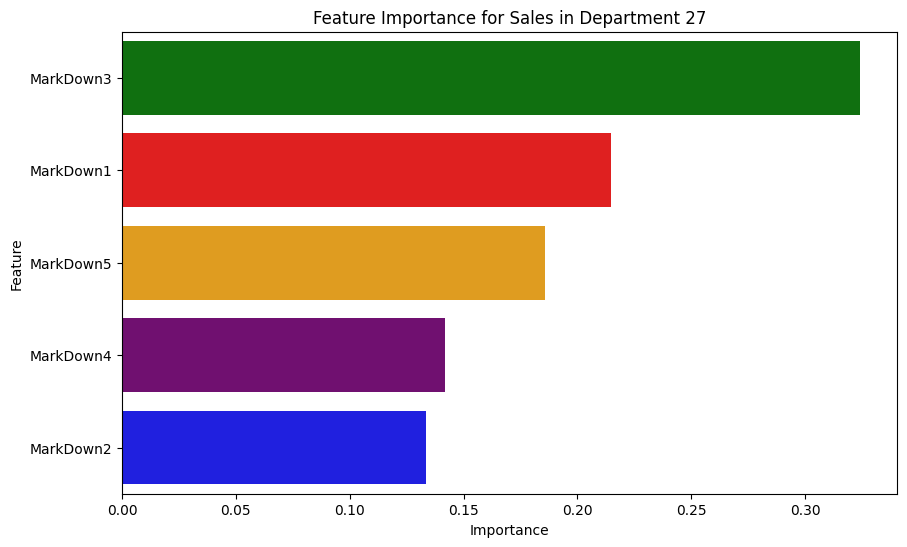

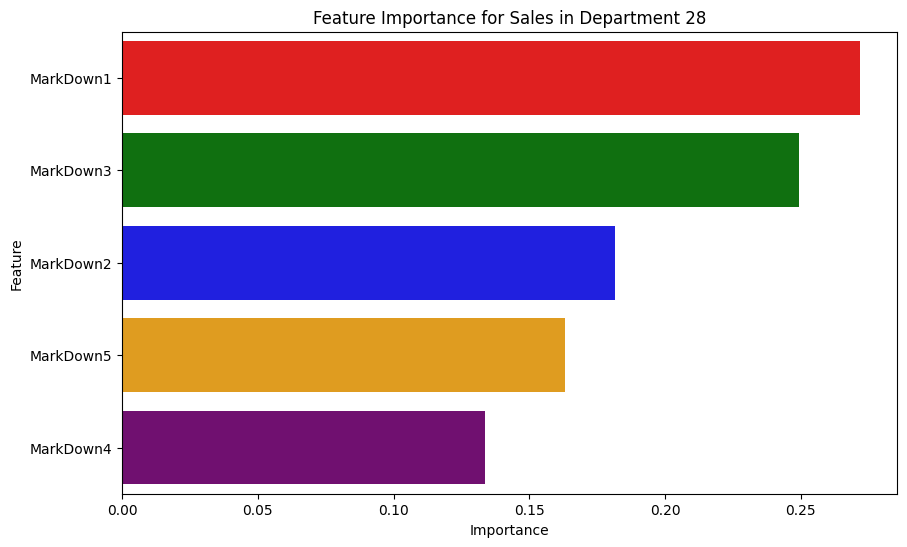

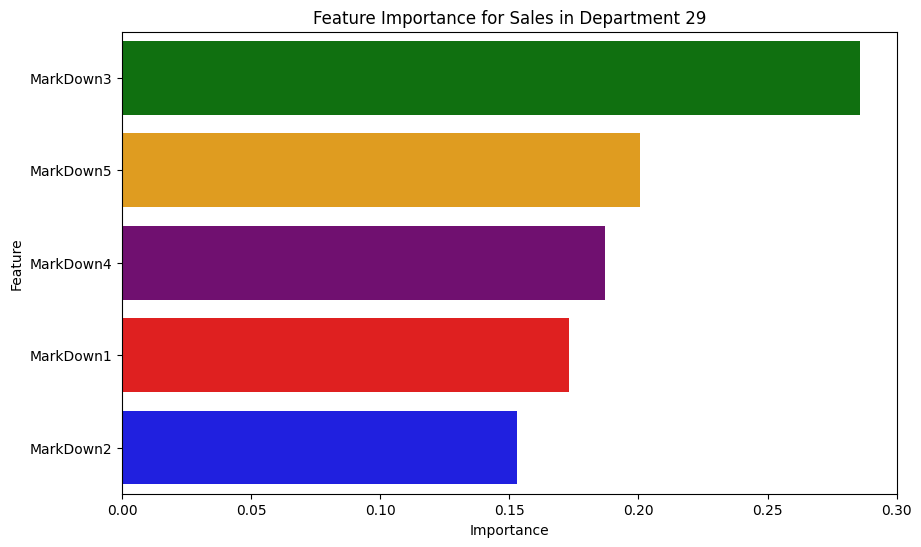

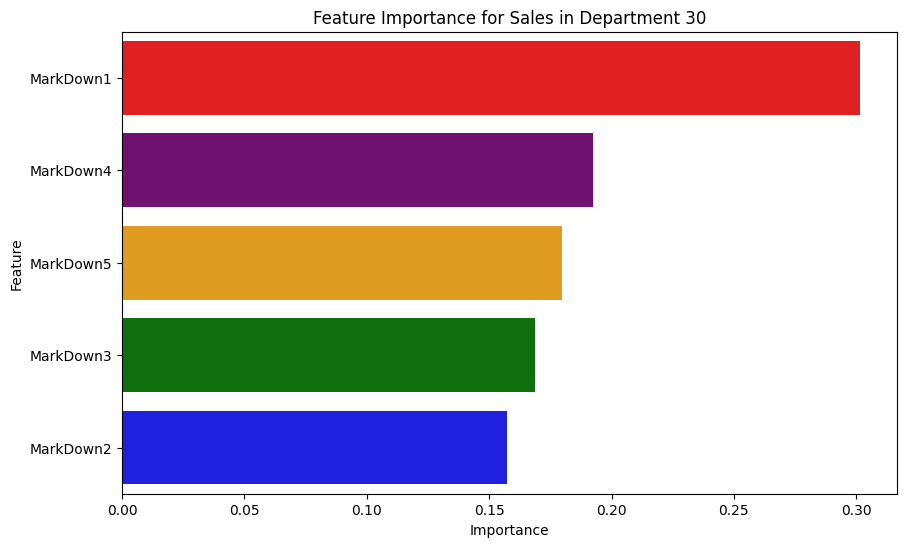

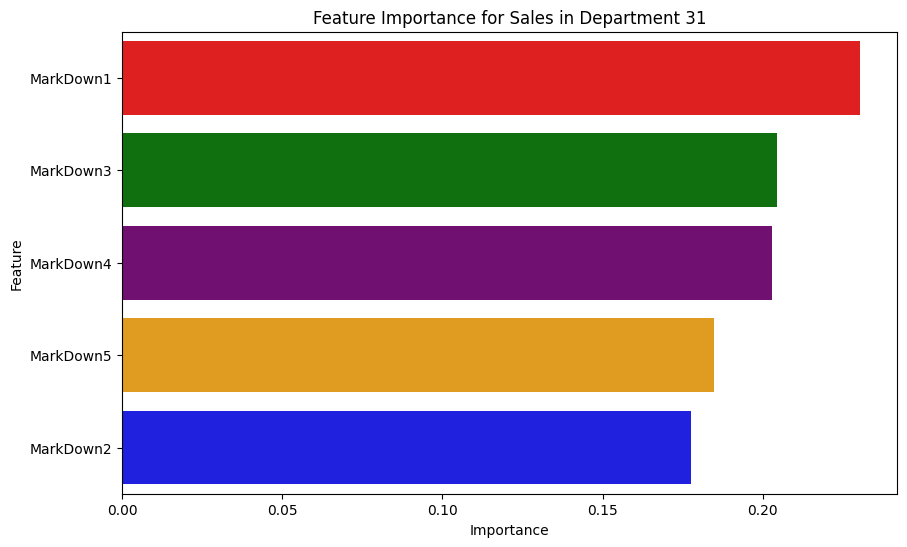

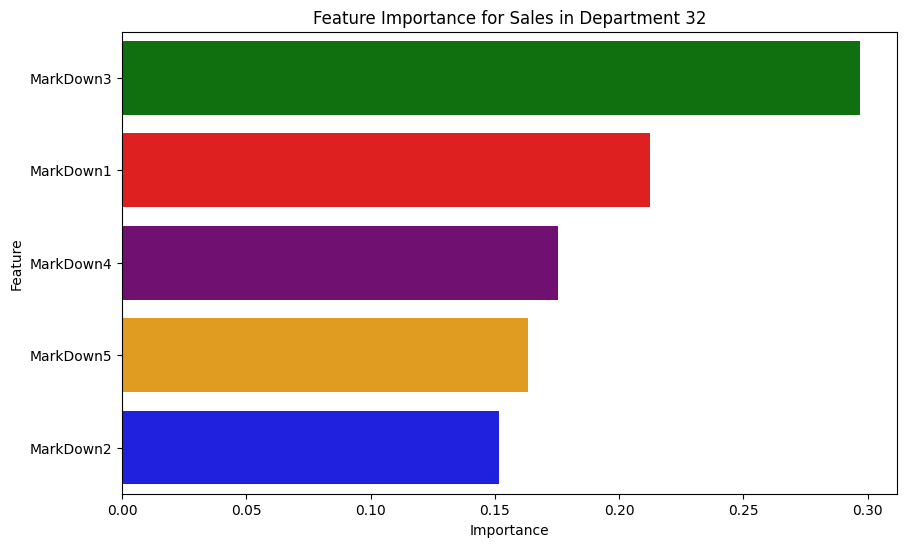

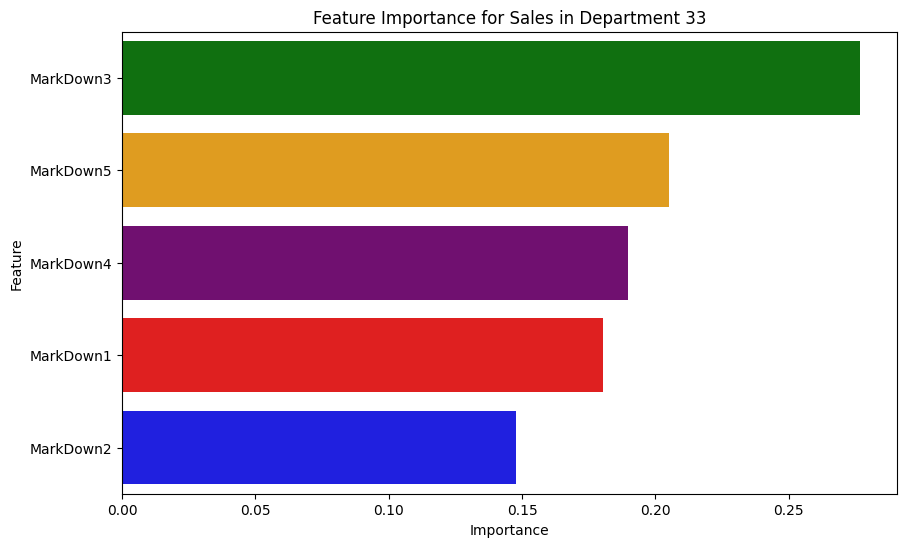

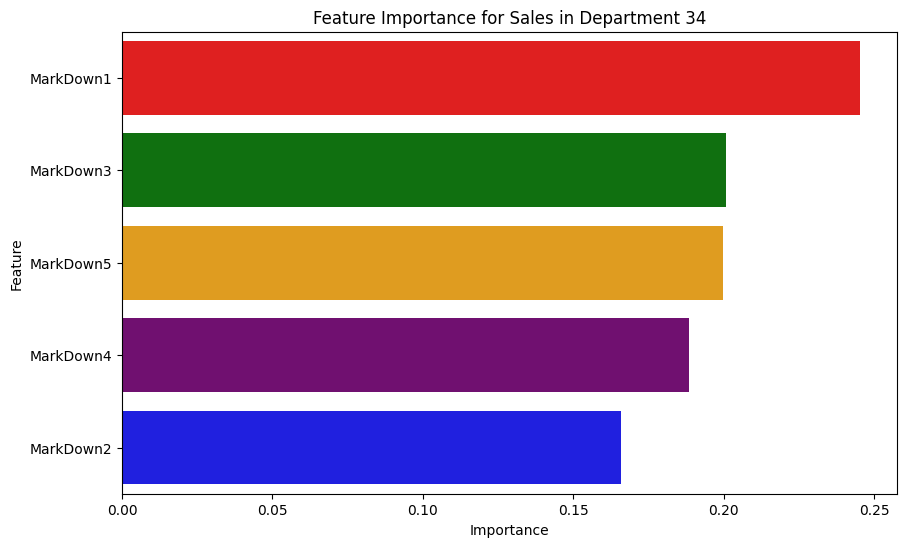

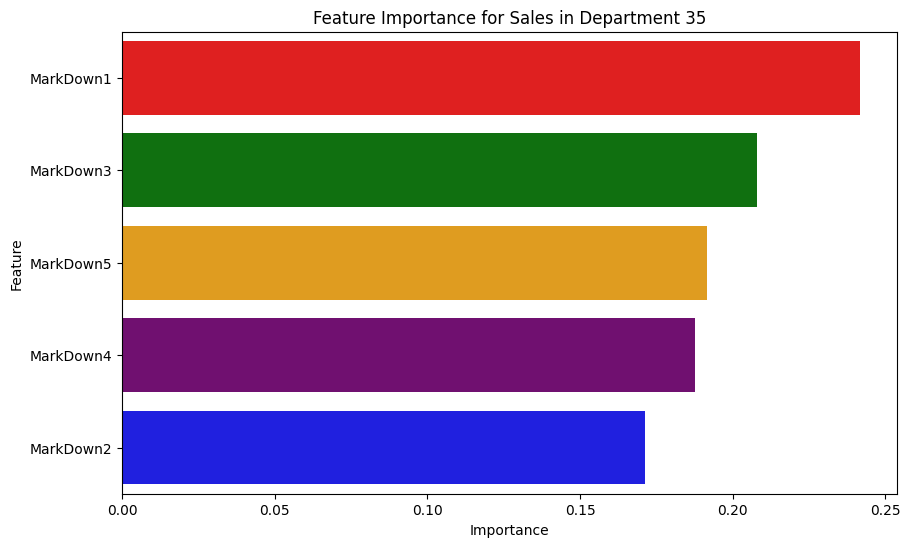

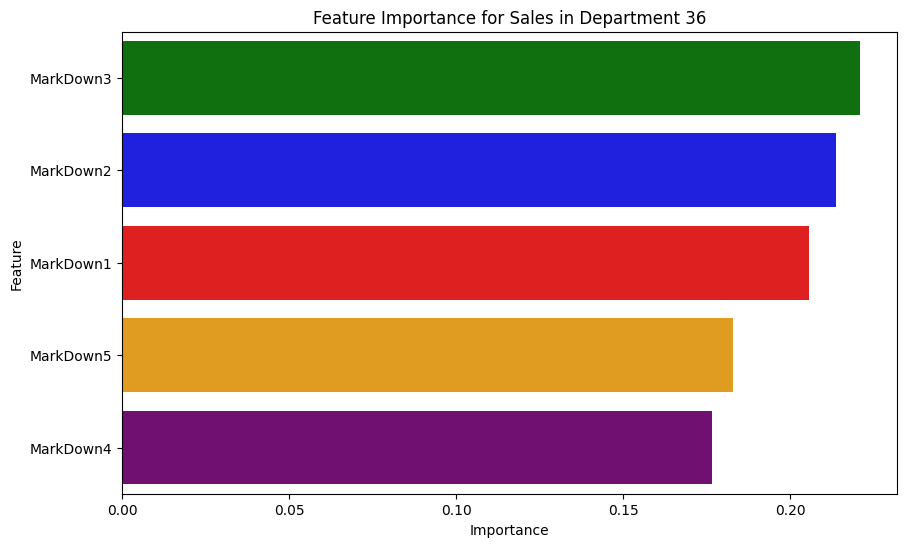

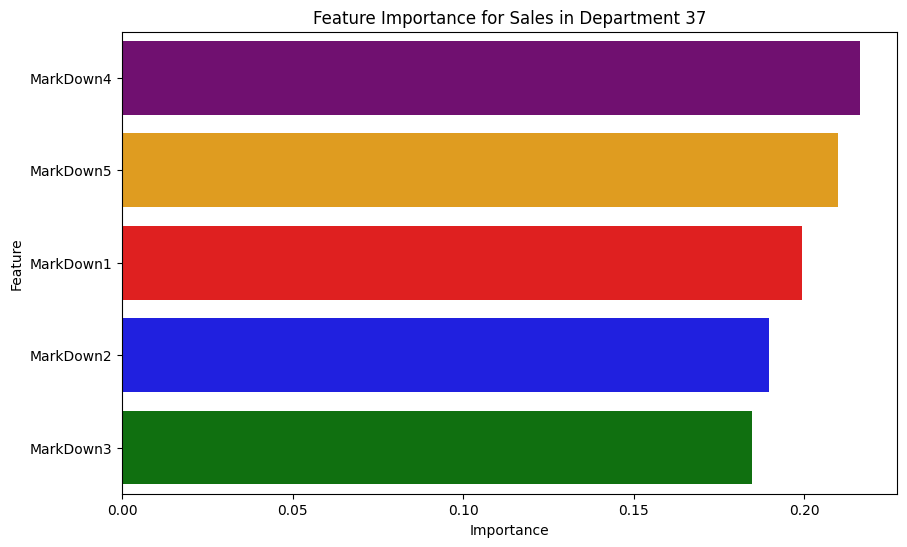

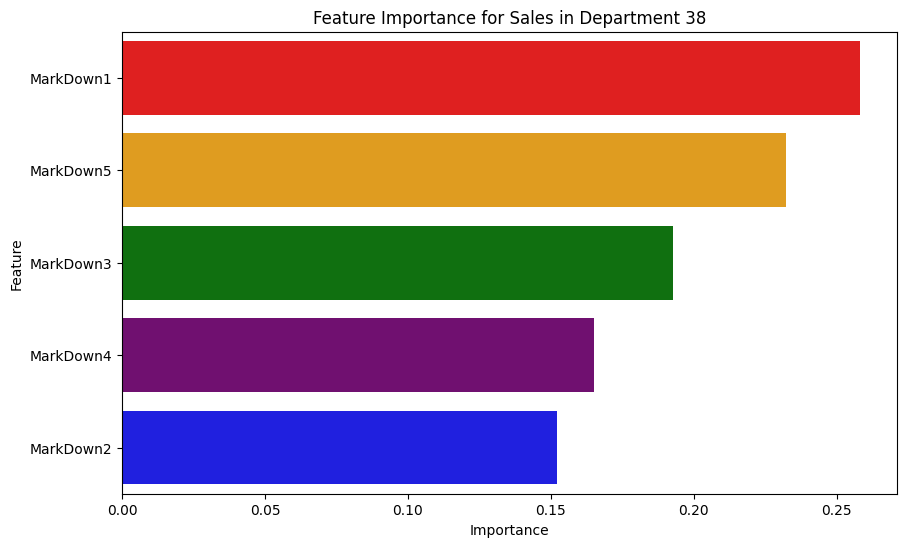

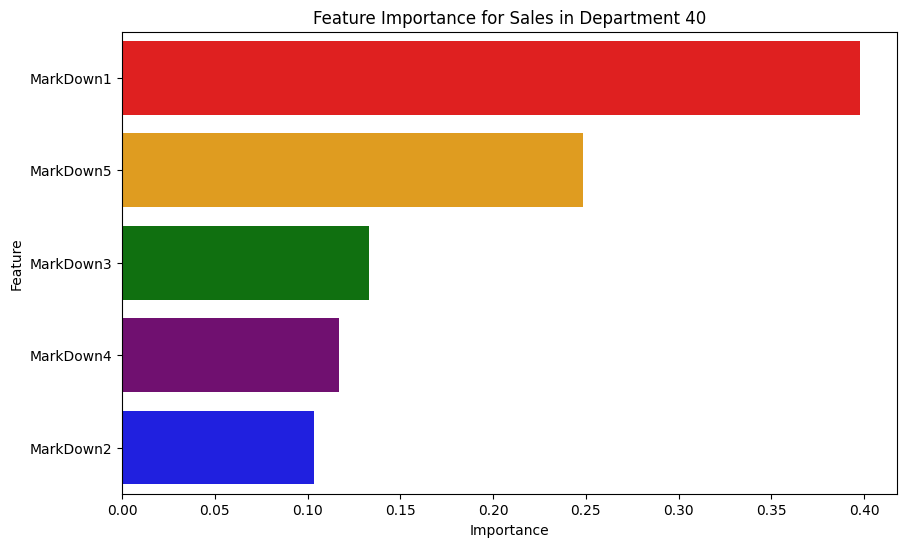

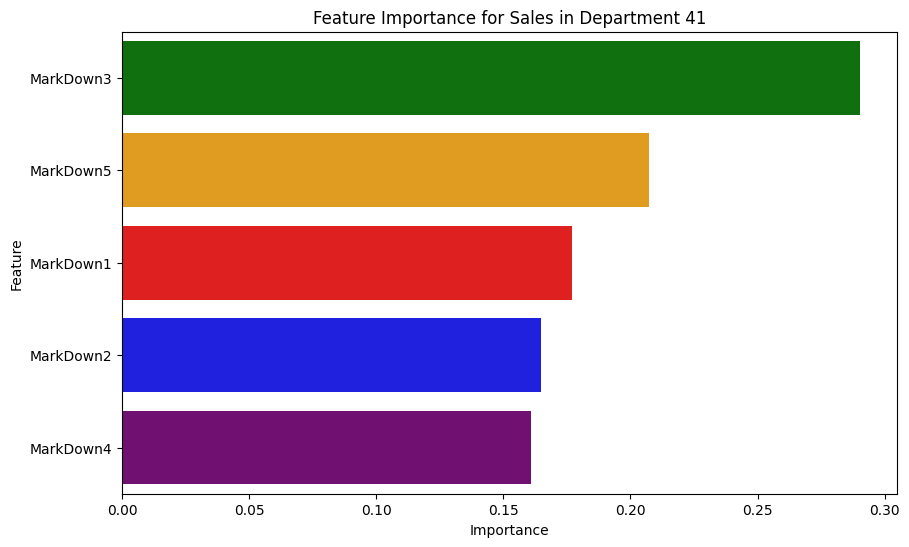

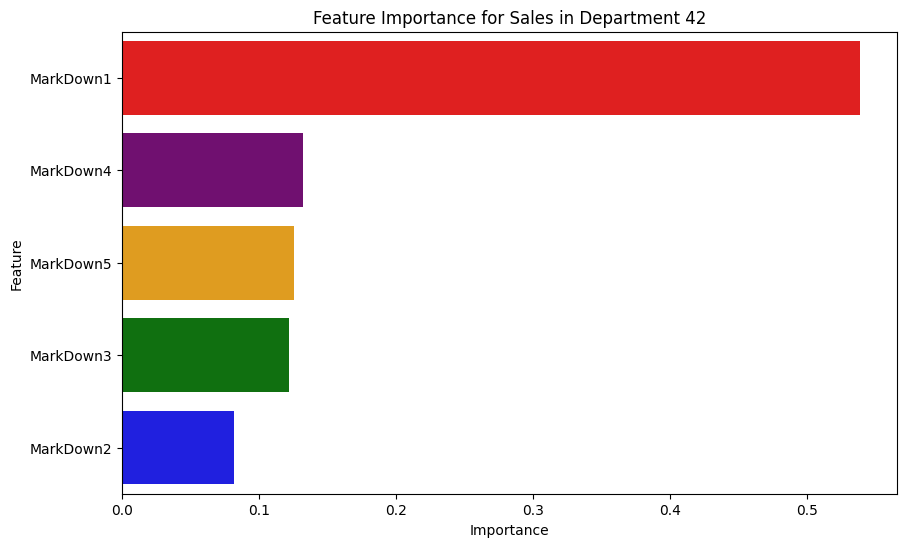

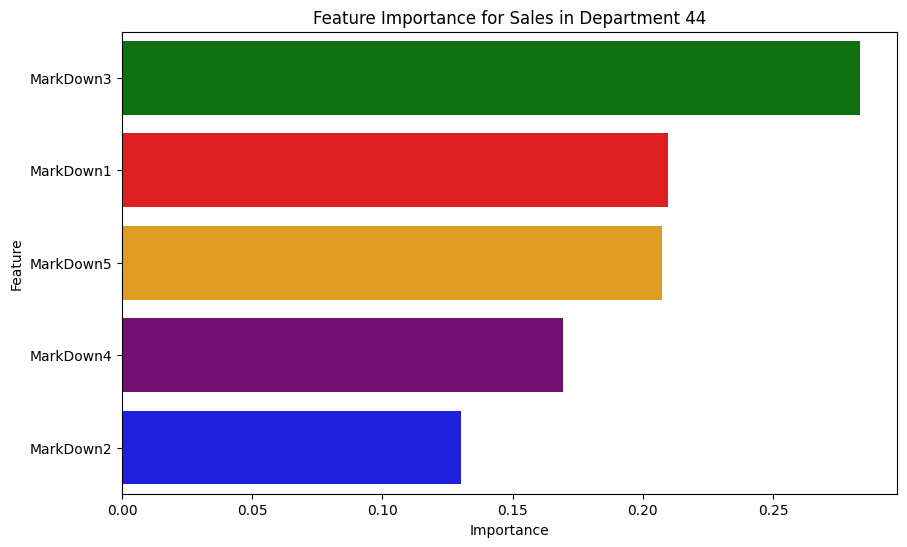

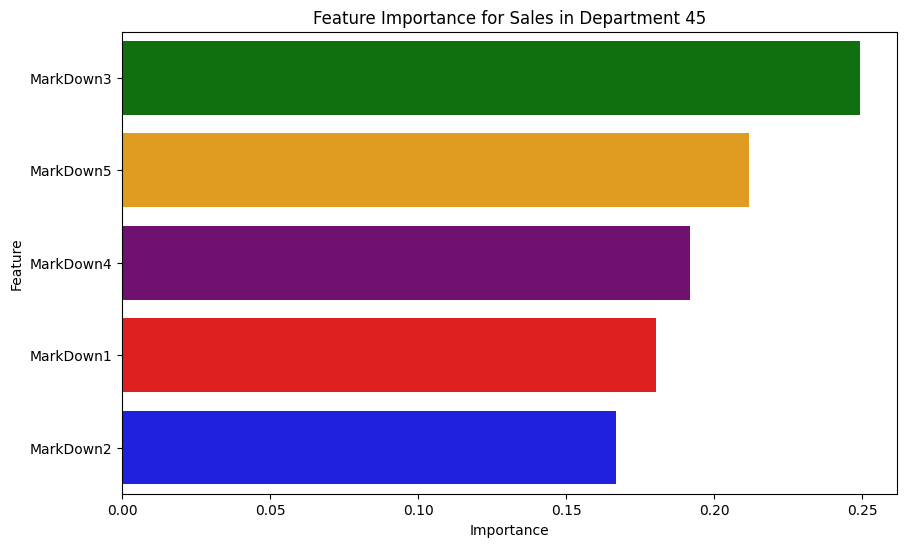

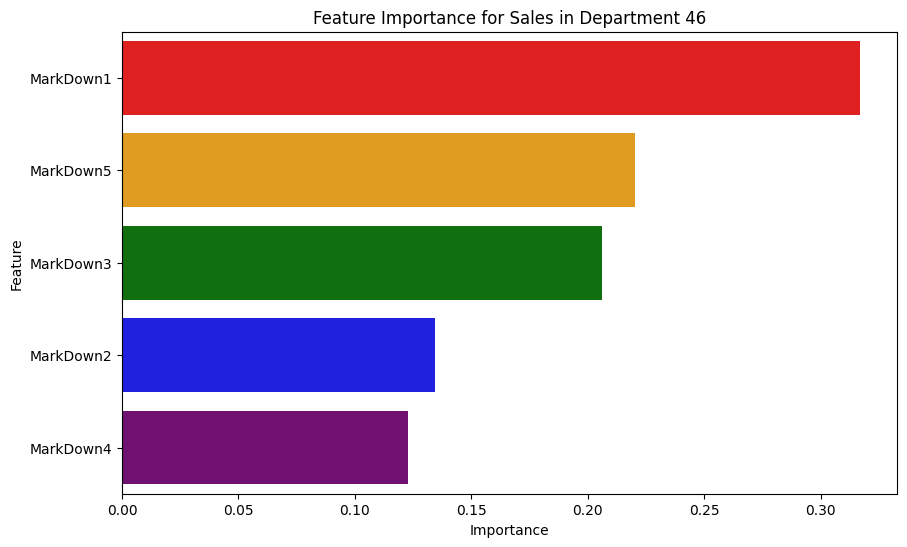

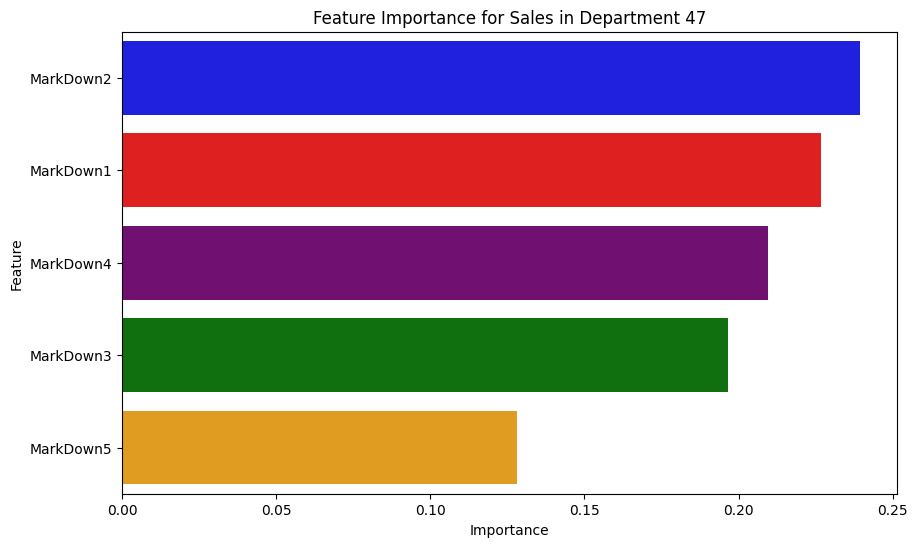

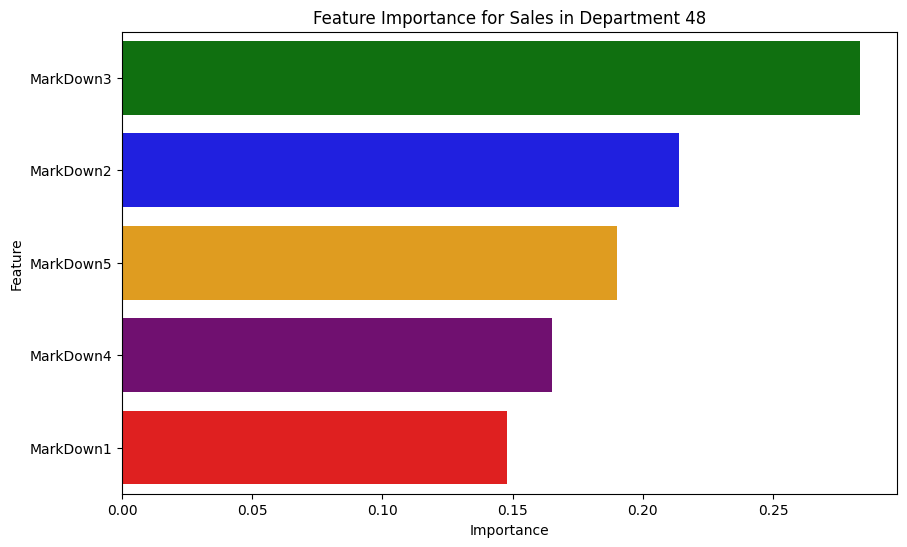

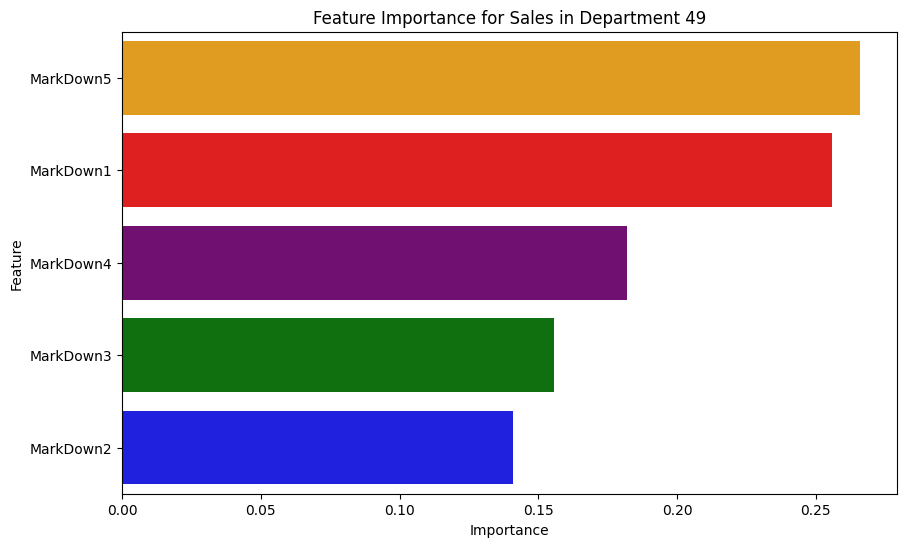

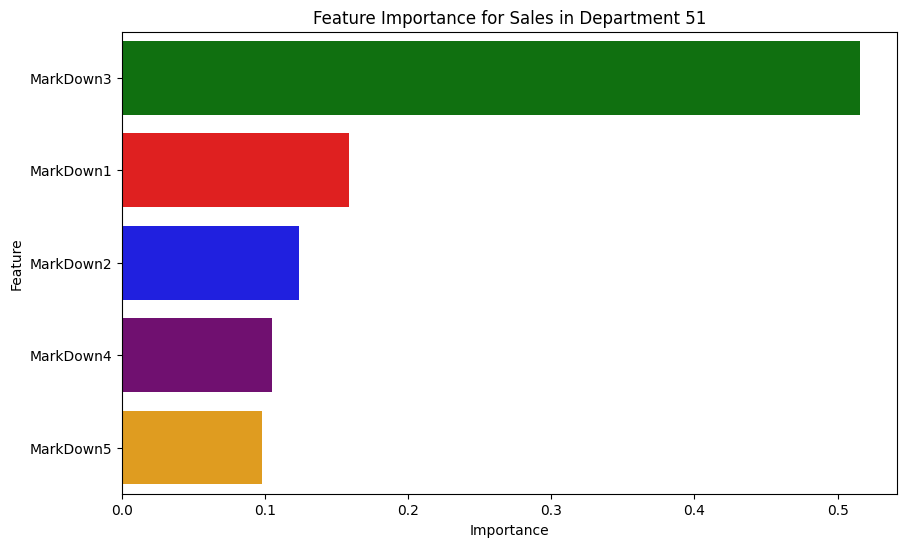

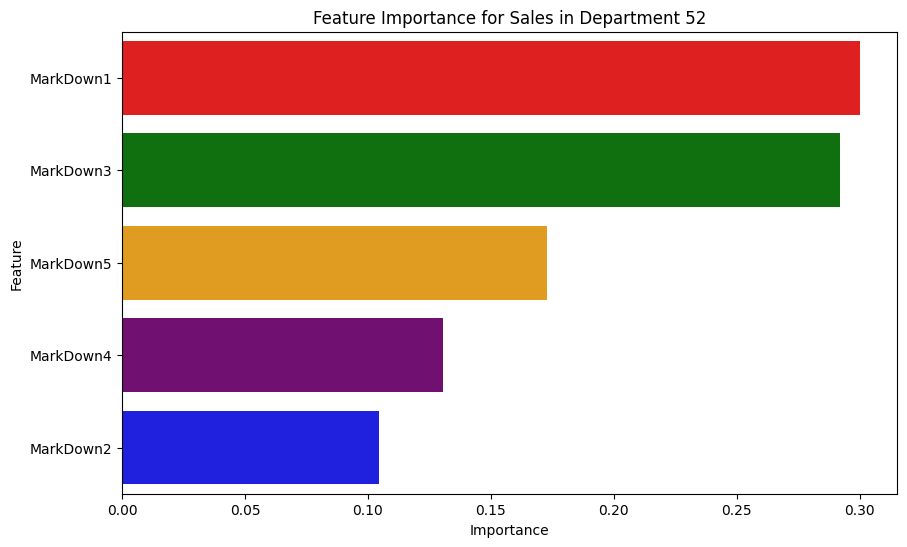

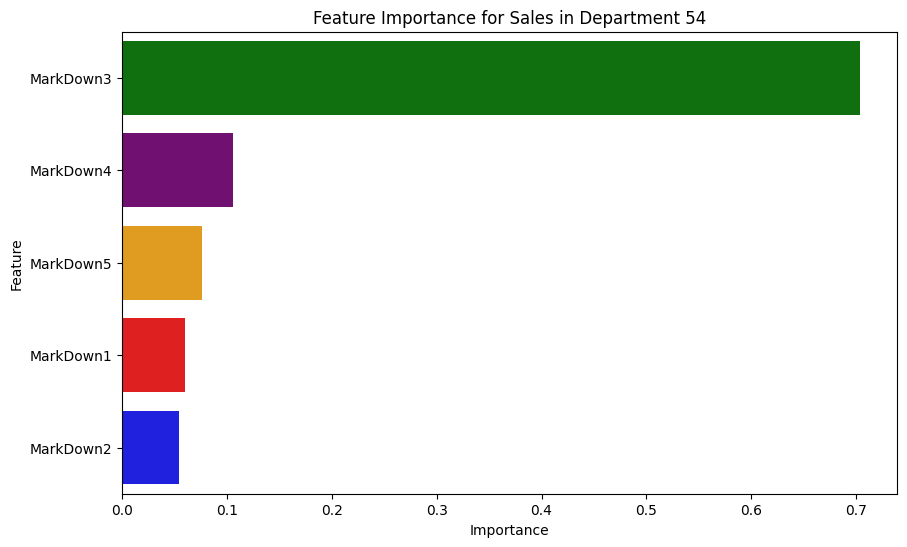

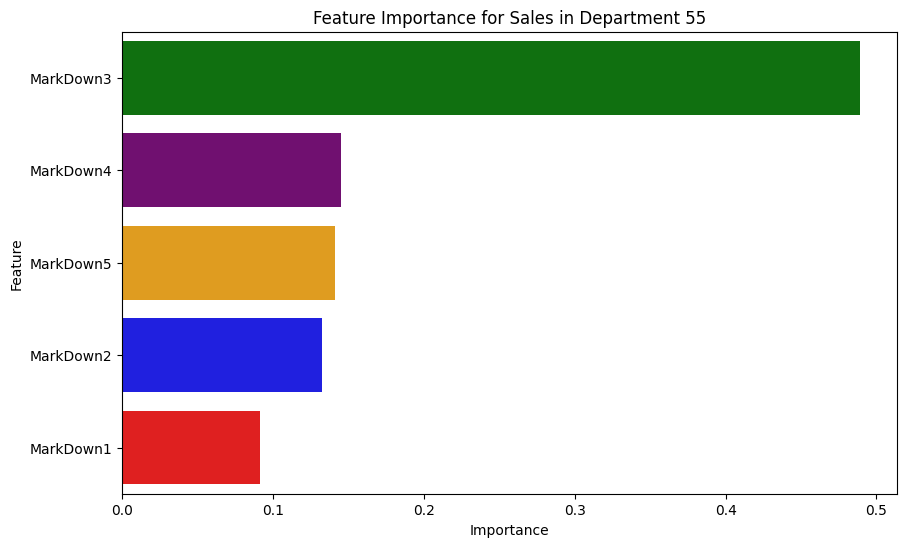

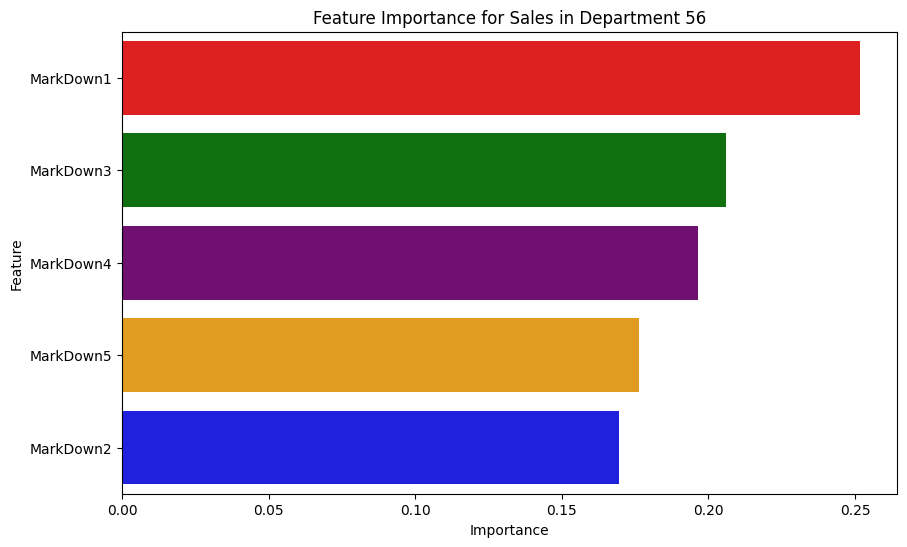

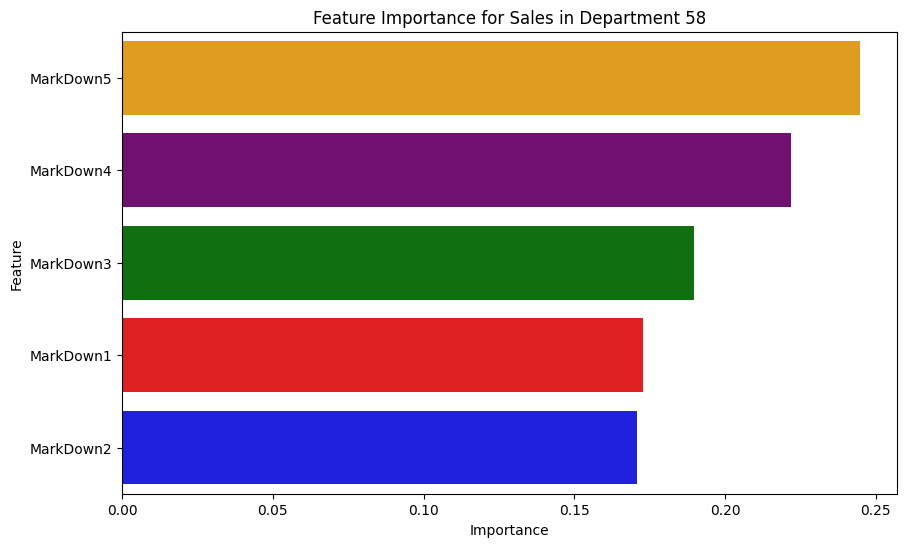

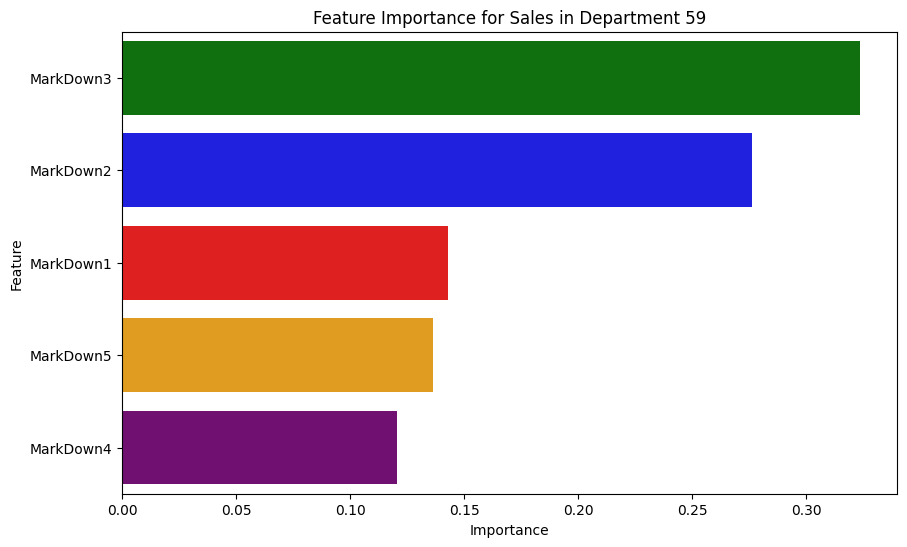

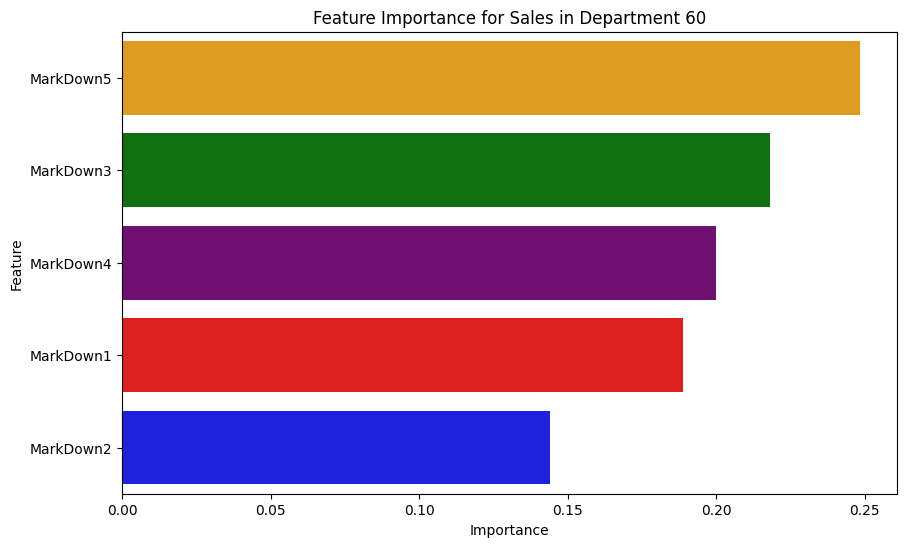

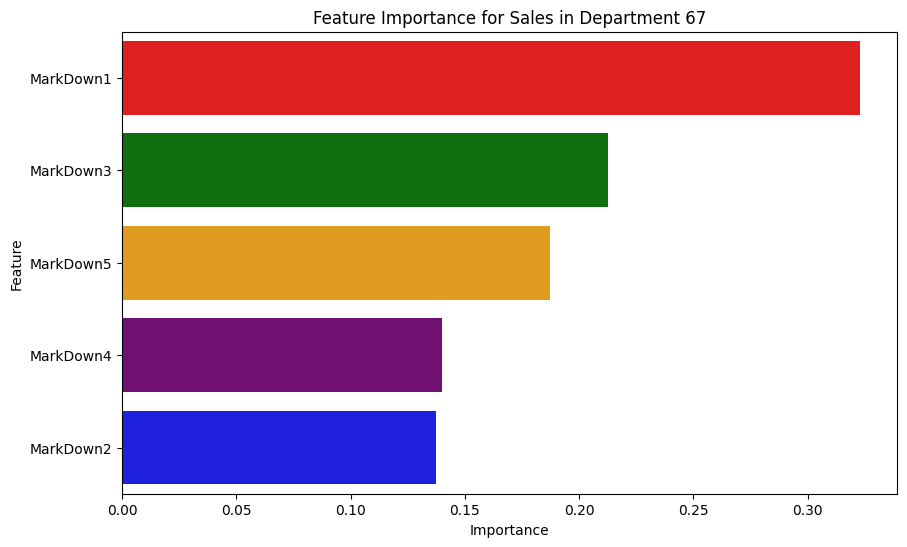

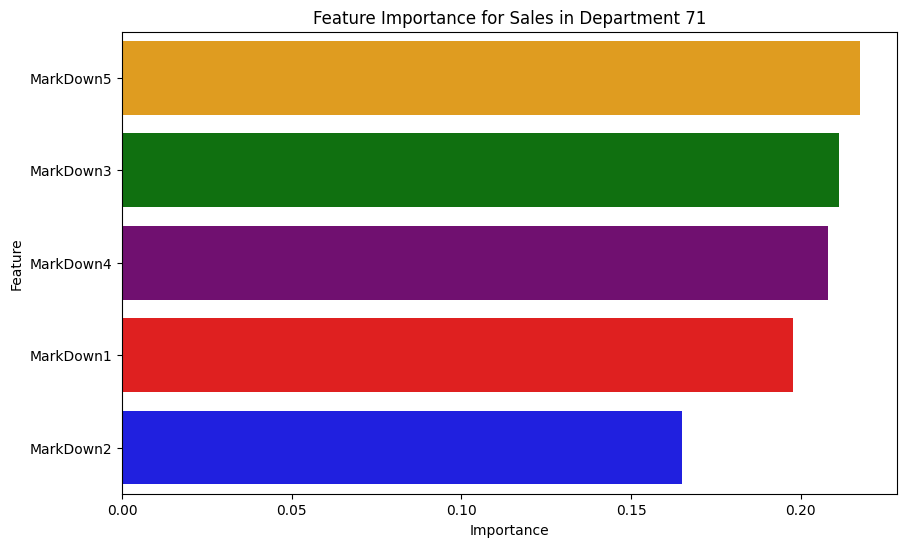

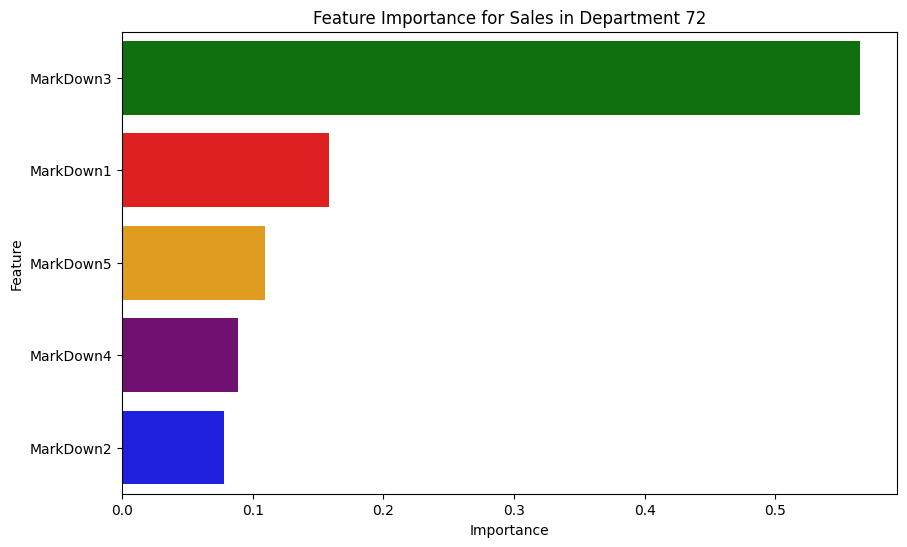

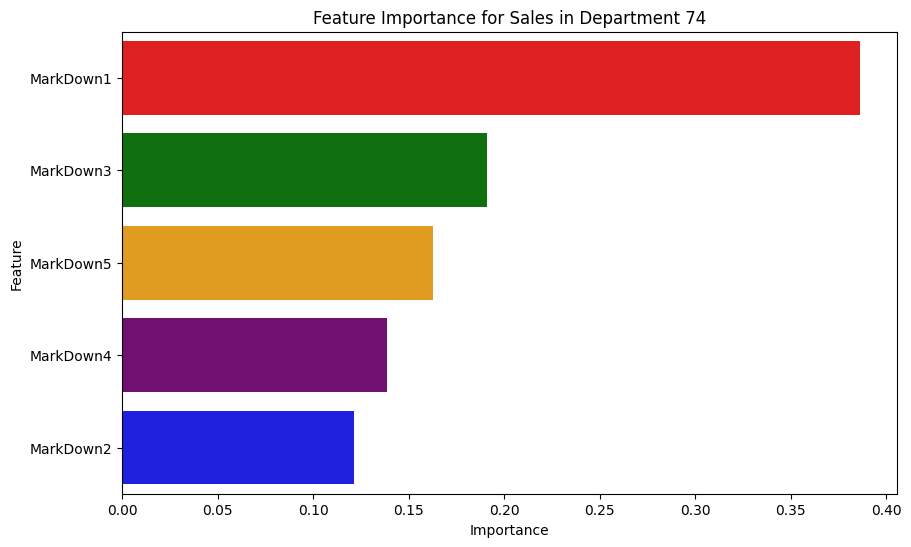

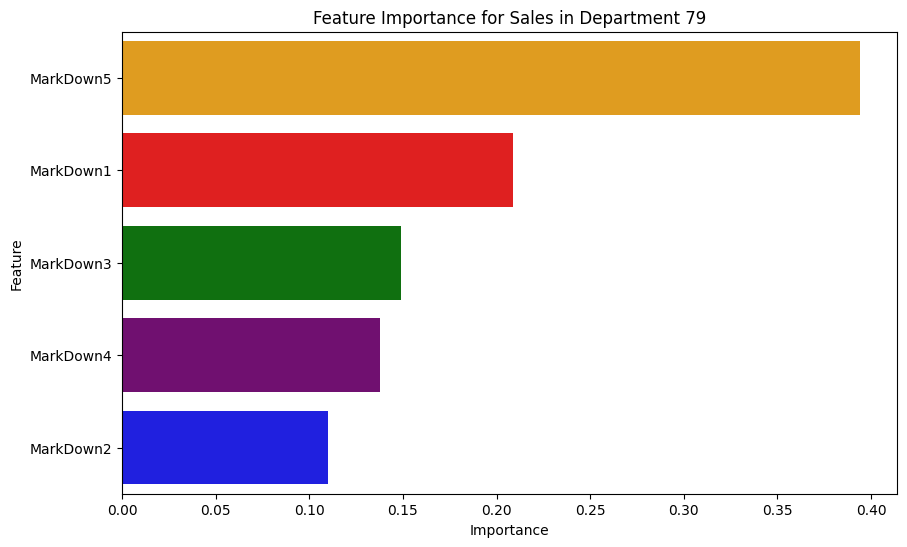

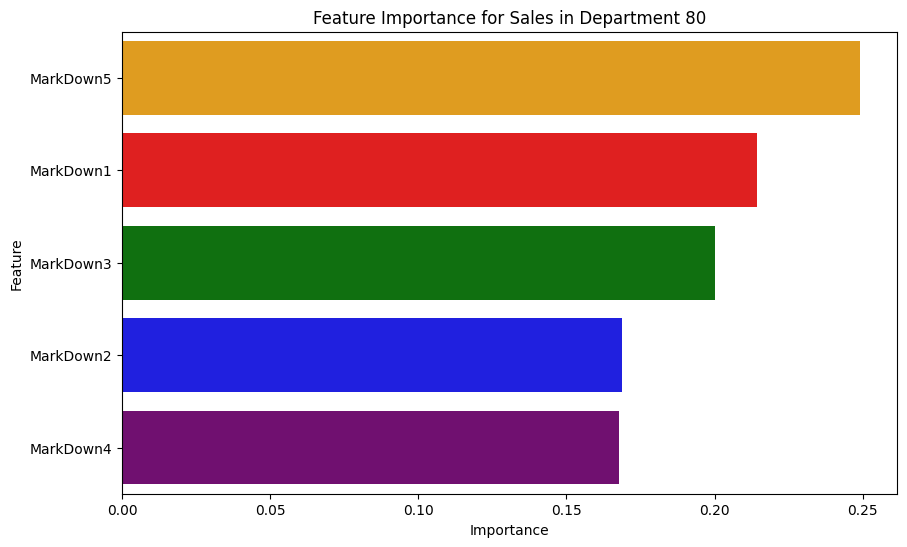

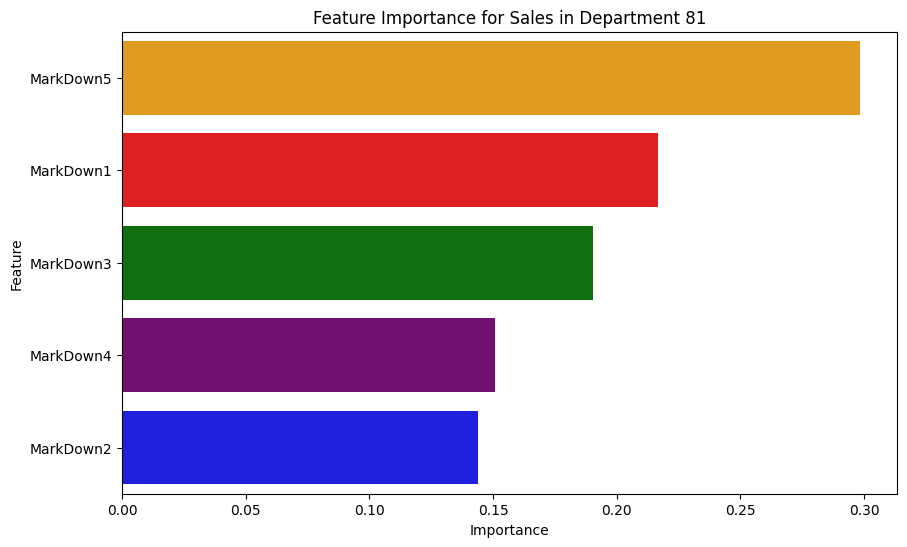

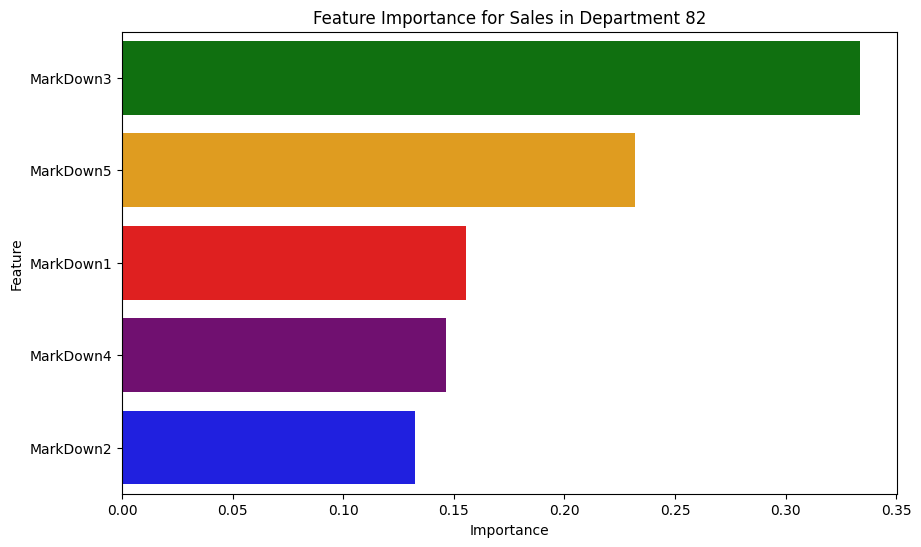

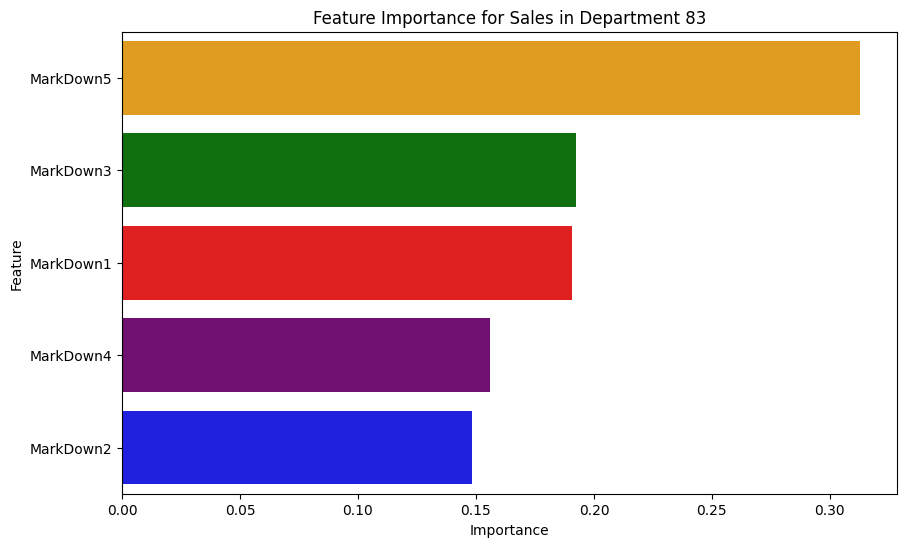

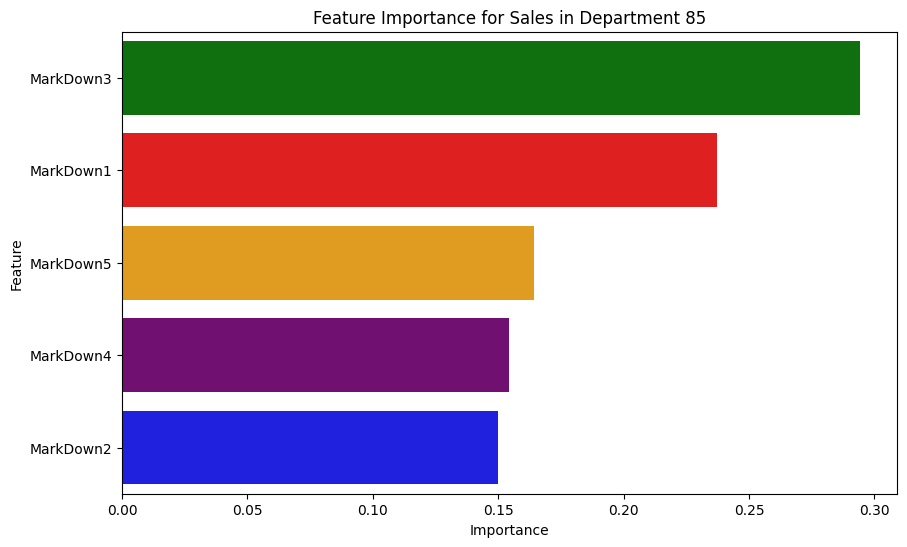

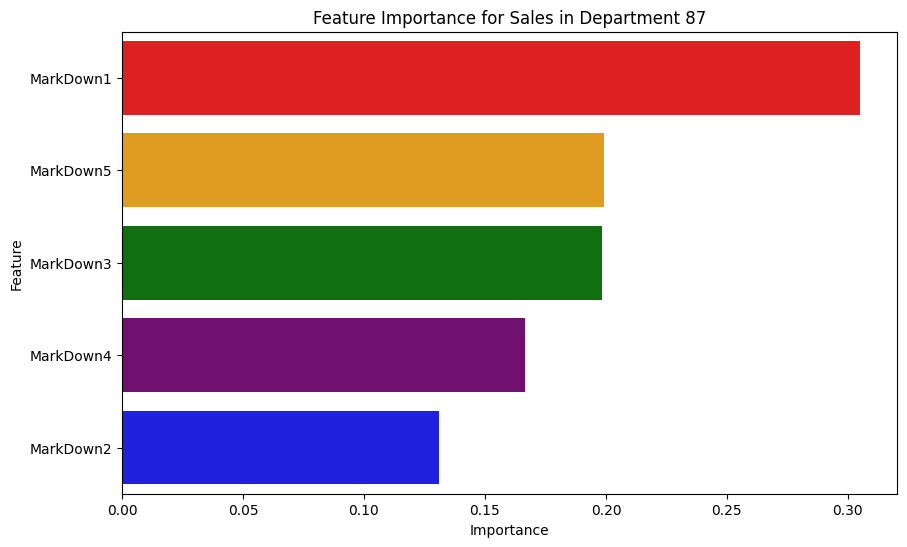

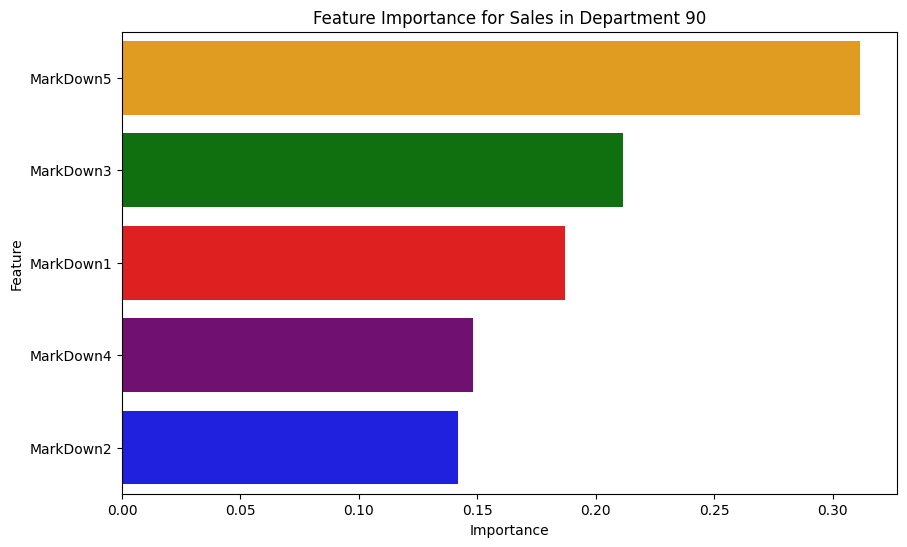

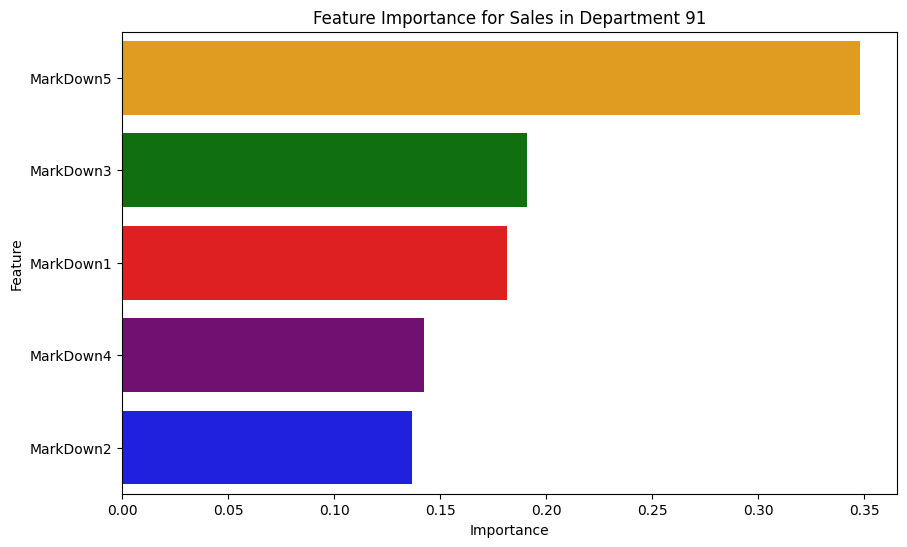

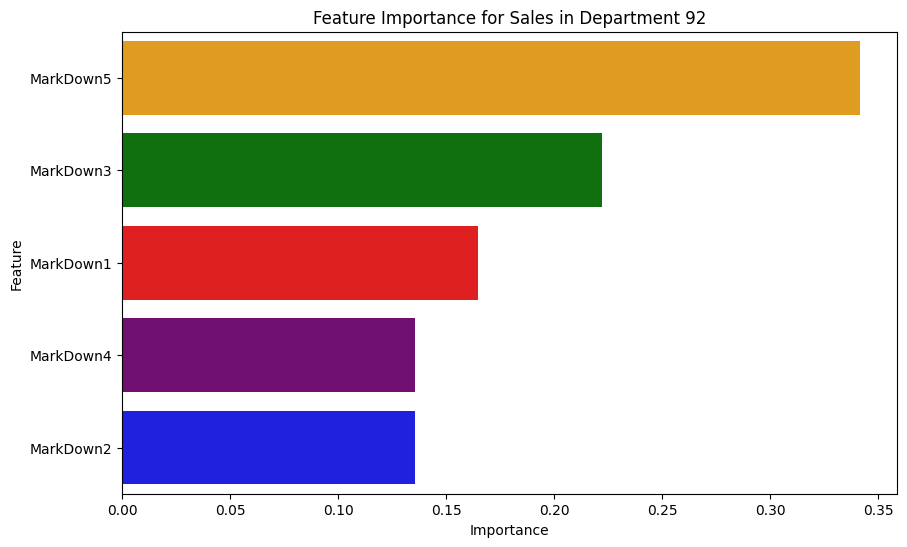

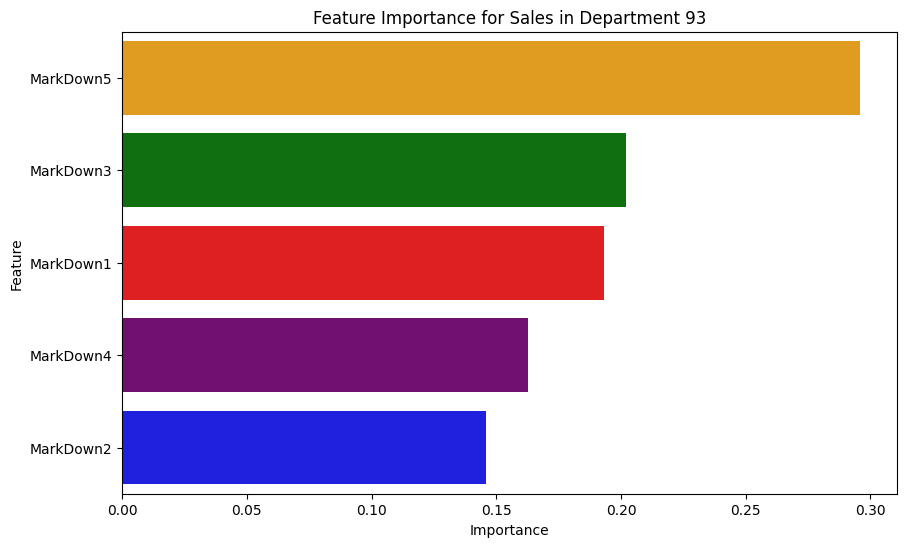

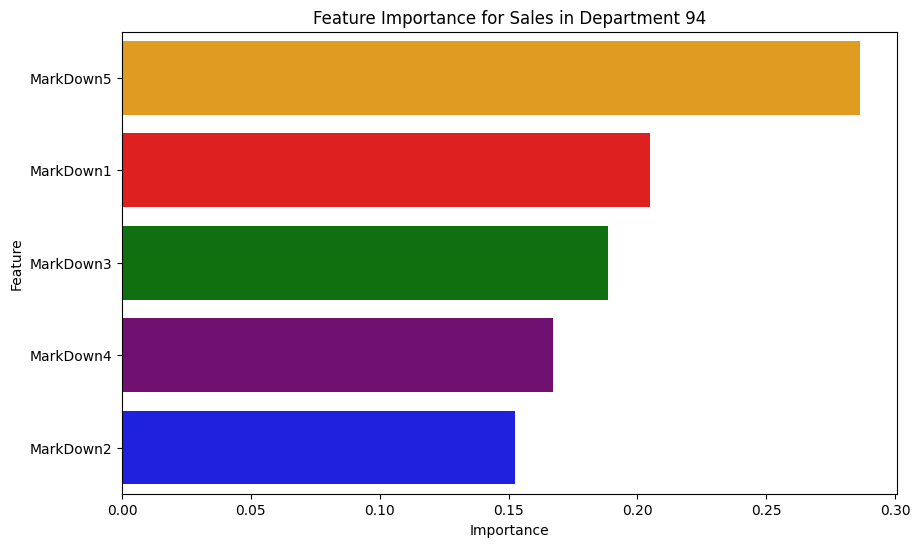

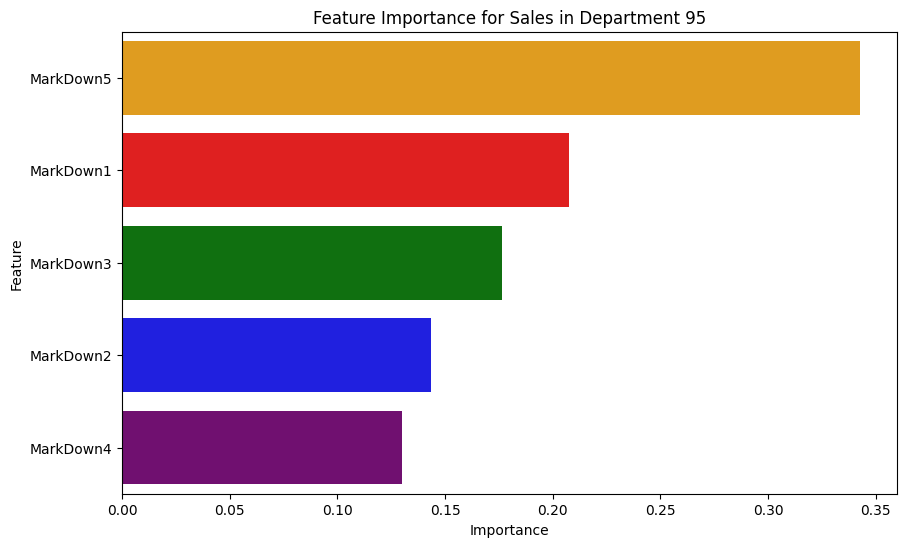

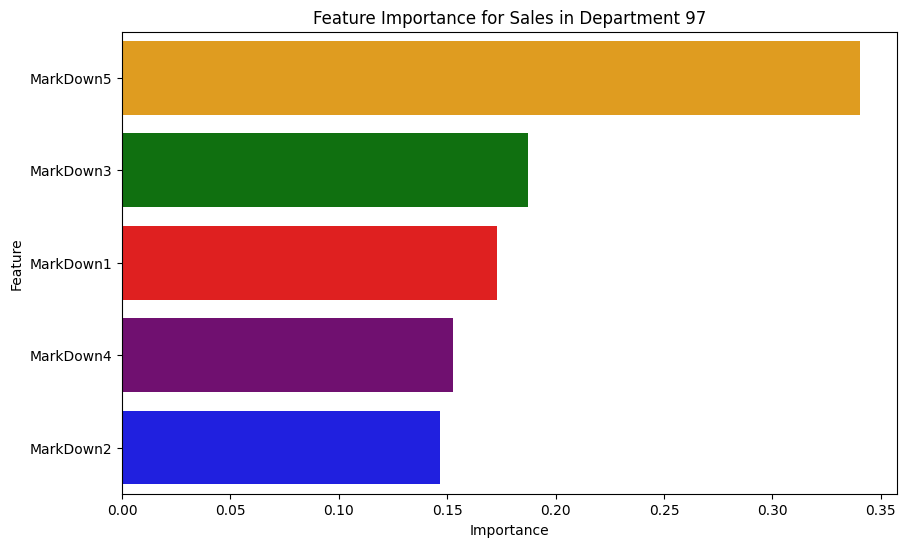

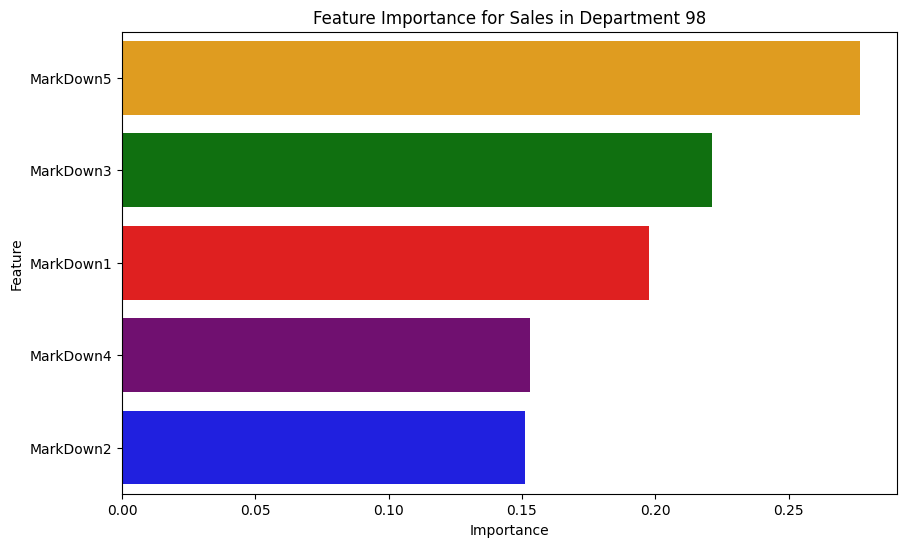

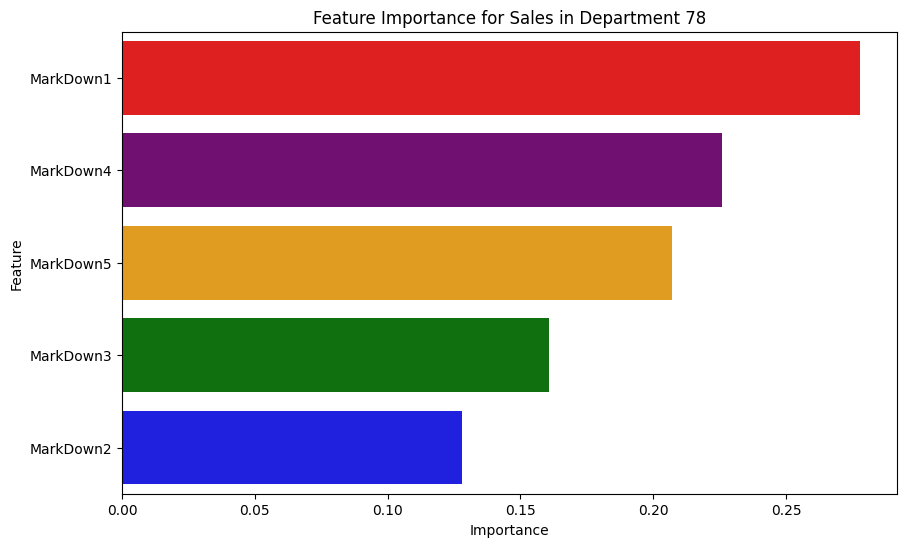

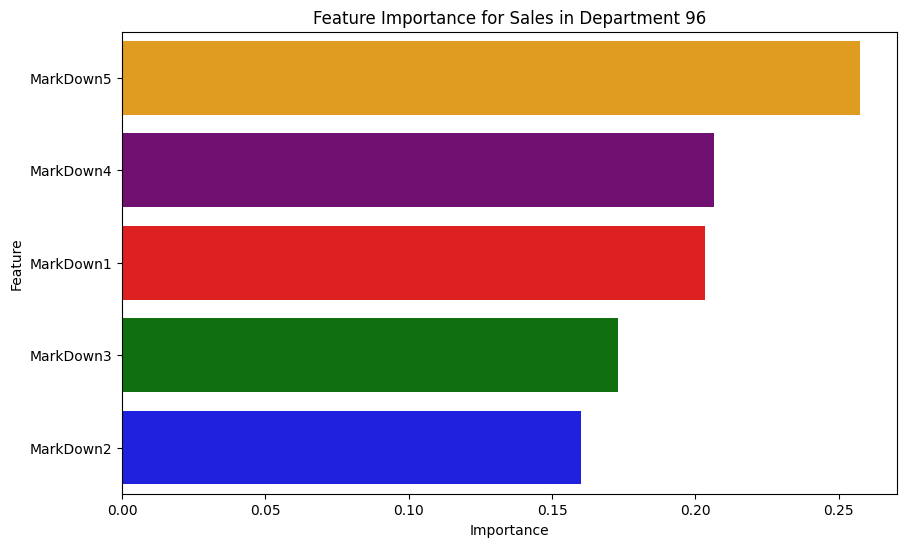

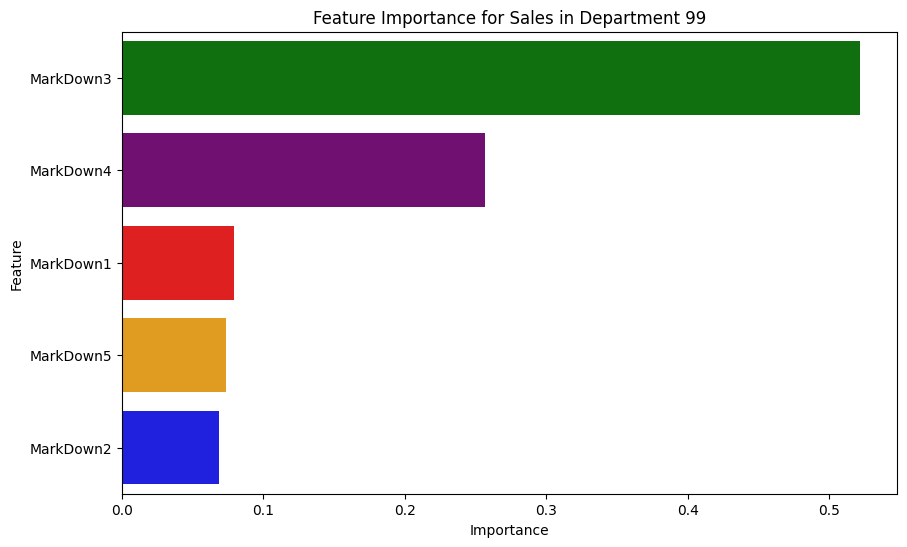

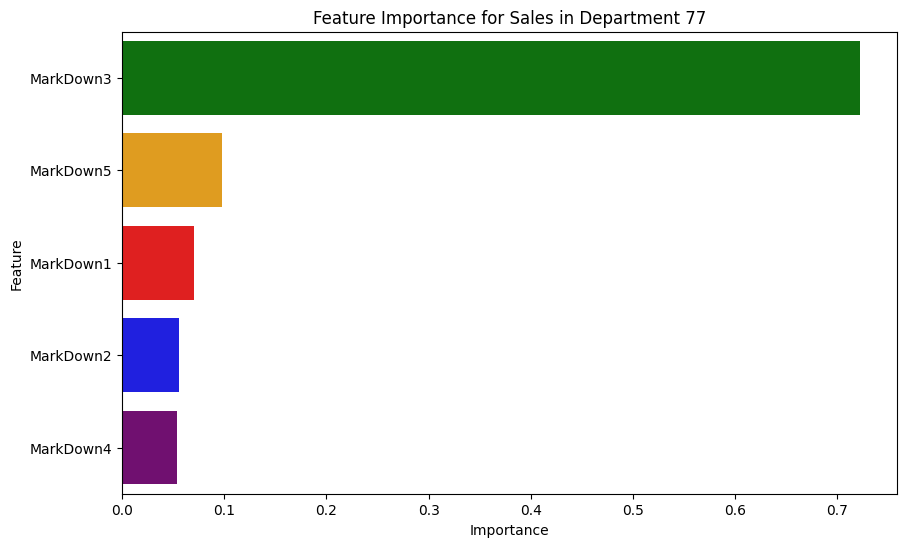

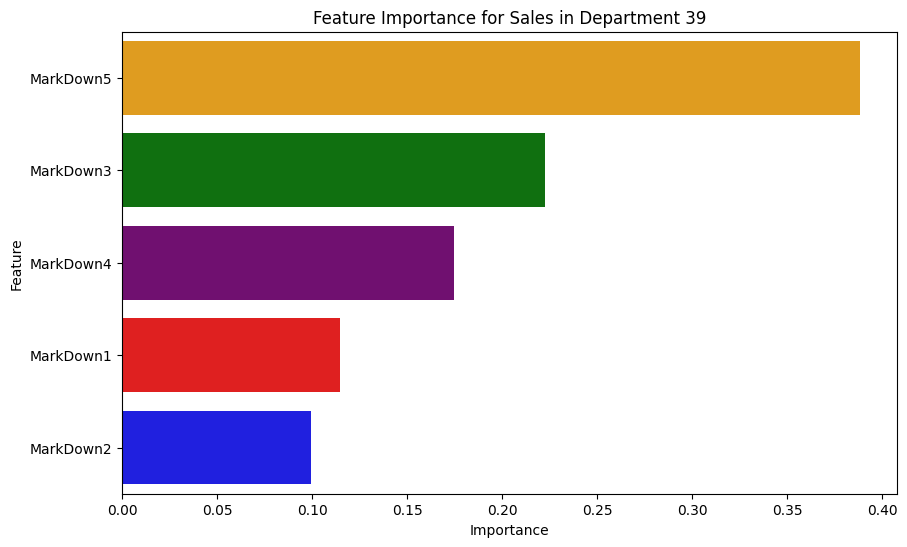

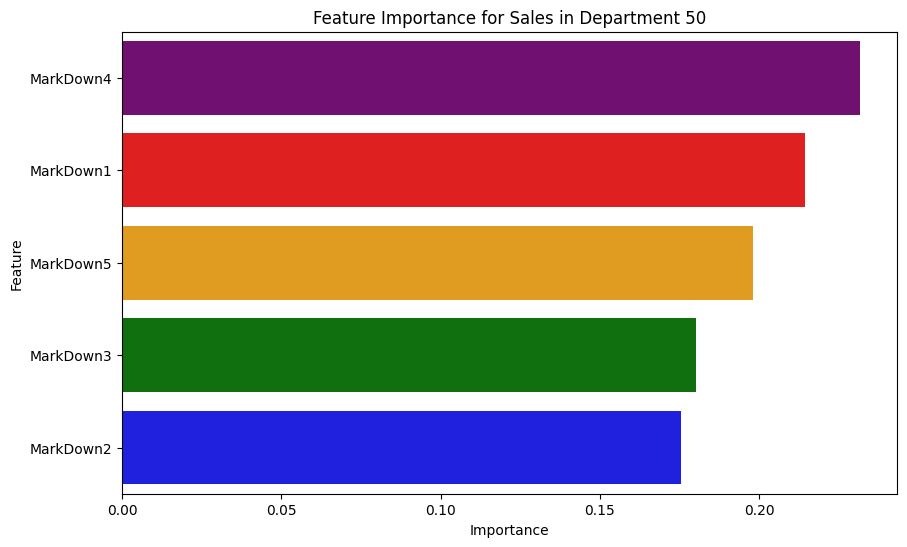

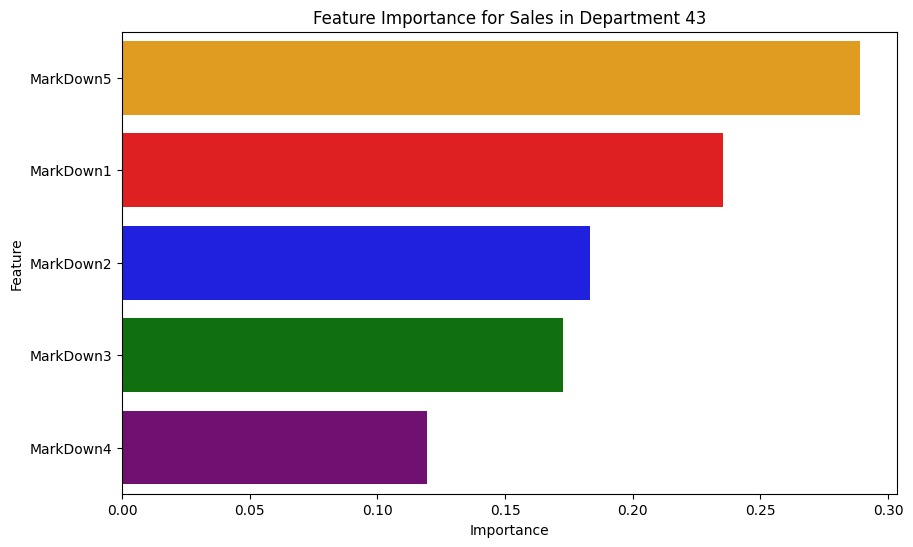

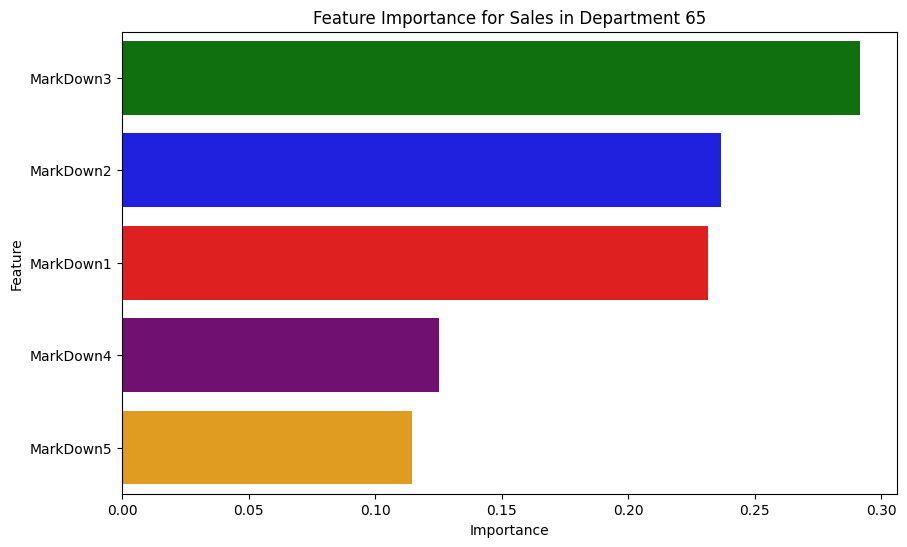

In [ ]:
# Markdown types
markdown_types = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Define color mapping for each Markdown type
color_mapping = {'MarkDown1': 'red', 'MarkDown2': 'blue', 'MarkDown3': 'green', 'MarkDown4': 'purple', 'MarkDown5': 'orange'}

# Select relevant features for overall sales
selected_features_overall = markdown_types + ['Weekly_Sales']

df_model_overall = merged_data[selected_features_overall]

# Handle missing values by imputing with the mean
df_model_overall = df_model_overall.fillna(df_model_overall.mean())

# Split data into features and target variable
X_overall = df_model_overall.drop('Weekly_Sales', axis=1)
y_overall = df_model_overall['Weekly_Sales']

# Train Random Forest Regression model for overall sales
model_overall = RandomForestRegressor(n_estimators=100, random_state=42)
model_overall.fit(X_overall, y_overall)

# Feature importance analysis for overall sales
feature_importance_overall = model_overall.feature_importances_
feature_importance_df_overall = pd.DataFrame({'Feature': X_overall.columns, 'Importance': feature_importance_overall})

# Sorting features by importance
feature_importance_df_overall = feature_importance_df_overall.sort_values(by='Importance', ascending=False)

# Bar plot for feature importance for overall sales
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_overall, palette=[color_mapping.get(feature, 'gray') for feature in feature_importance_df_overall['Feature']])
plt.title('Feature Importance for Overall Sales')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Iterate over unique departments for sales by department
for dept in merged_data['Dept'].unique():
    df_dept = merged_data[merged_data['Dept'] == dept]
    selected_features_dept = markdown_types + ['Weekly_Sales']
    df_model_dept = df_dept[selected_features_dept]
    df_model_dept = df_model_dept.fillna(df_model_dept.mean())

# Split data into features and target variable
    X_dept = df_model_dept.drop('Weekly_Sales', axis=1)
    y_dept = df_model_dept['Weekly_Sales']

# Train Random Forest Regression model for the current department
    model_dept = RandomForestRegressor(n_estimators=100, random_state=42)
    model_dept.fit(X_dept, y_dept)

# Feature importance analysis for the current department
    feature_importance_dept = model_dept.feature_importances_
    feature_importance_df_dept = pd.DataFrame({'Feature': X_dept.columns, 'Importance': feature_importance_dept})

# Sorting features by importance
    feature_importance_df_dept = feature_importance_df_dept.sort_values(by='Importance', ascending=False)

# Bar plot for feature importance for the current department
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df_dept, palette=[color_mapping.get(feature, 'gray') for feature in feature_importance_df_dept['Feature']])
    plt.title(f'Feature Importance for Sales in Department {dept}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()




<ipython-input-37-3b3c28db8517>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  markdown_importance_by_department = markdown_importance_by_department.append(pd.Series(importance_values, index=markdown_importance_by_department.columns), ignore_index=True)
<ipython-input-37-3b3c28db8517>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  markdown_importance_by_department = markdown_importance_by_department.append(pd.Series(importance_values, index=markdown_importance_by_department.columns), ignore_index=True)
<ipython-input-37-3b3c28db8517>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  markdown_importance_by_department = markdown_importance_by_department.append(pd.Series(importance_values, index=markdown_importance_by_de

Markdown Importance by Department:
      Markdown1  Markdown2  Markdown3  Markdown4  Markdown5
Dept                                                       
1.0    0.211409   0.142155   0.245205   0.168713   0.232519
2.0    0.349259   0.111122   0.165816   0.124178   0.249625
3.0    0.247134   0.202539   0.149808   0.272617   0.127902
4.0    0.210530   0.121063   0.164179   0.113820   0.390408
5.0    0.218085   0.095542   0.406380   0.132220   0.147774
...         ...        ...        ...        ...        ...
77.0   0.068846   0.055505   0.733044   0.048674   0.093930
39.0   0.108189   0.139394   0.197803   0.203962   0.350652
50.0   0.222762   0.170678   0.181738   0.230024   0.194798
43.0   0.208522   0.178716   0.274019   0.210612   0.128131
65.0   0.256562   0.236702   0.232001   0.124464   0.150271

[81 rows x 5 columns]


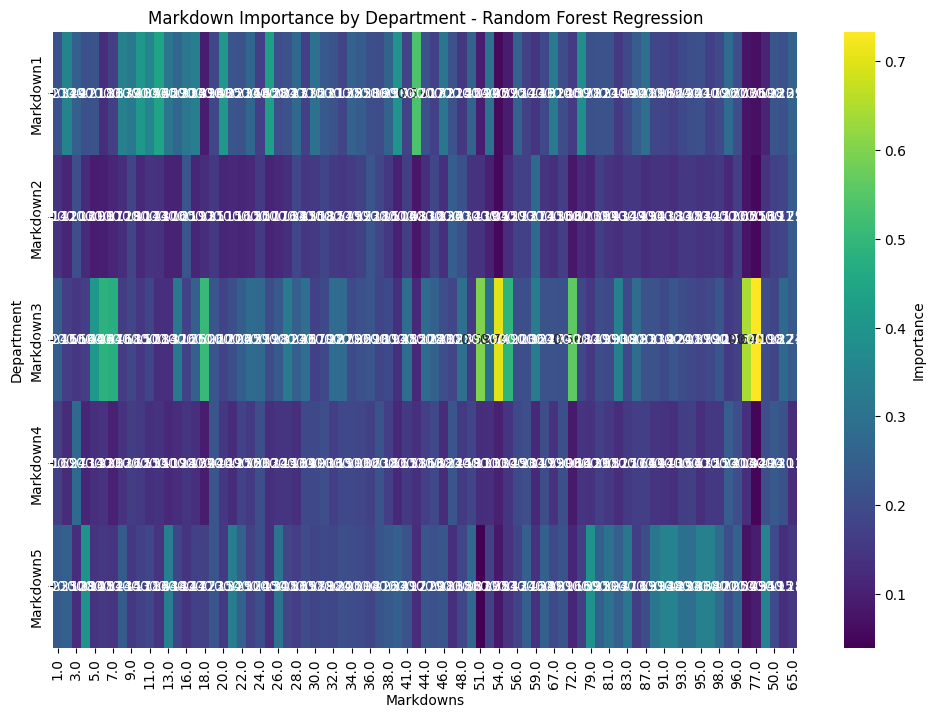

In [ ]:
# Select relevant features
selected_features = ['Dept', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales']

df_model = merged_data[selected_features]

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
df_model_imputed = pd.DataFrame(imputer.fit_transform(df_model), columns=df_model.columns)

# Iterate over unique departments
departments = df_model_imputed['Dept'].unique()

# Create an empty DataFrame to store results
markdown_importance_by_department = pd.DataFrame(columns=['Dept', 'Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5'])

# Train Random Forest Regression model for each department
for dept in departments:
    df_dept = df_model_imputed[df_model_imputed['Dept'] == dept]
    X_dept = df_dept.drop('Weekly_Sales', axis=1)
    y_dept = df_dept['Weekly_Sales']
    model_dept = RandomForestRegressor(n_estimators=100, random_state=42)
    model_dept.fit(X_dept, y_dept)

# Store feature importance in the DataFrame
    importance_values = [dept] + list(model_dept.feature_importances_[1:])  # Exclude 'Dept' from feature importance
    markdown_importance_by_department = markdown_importance_by_department.append(pd.Series(importance_values, index=markdown_importance_by_department.columns), ignore_index=True)

# Set 'Dept' column as index
markdown_importance_by_department.set_index('Dept', inplace=True)

# Display DataFrame
print("Markdown Importance by Department:")
print(markdown_importance_by_department)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.heatmap(markdown_importance_by_department.T, cmap='viridis', annot=True, fmt=".3f", cbar_kws={'label': 'Importance'})
plt.title('Markdown Importance by Department - Random Forest Regression')
plt.xlabel('Markdowns')
plt.ylabel('Department')
plt.show()



In [ ]:
# Get the shape of the DataFrame
num_rows, num_columns = merged_data.shape

# Print the results
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 421570
Number of Columns: 17


In [ ]:
merged_data.sample(10)

Store  Dept       Date  Weekly_Sales  IsHoliday_x Type    Size  \
350423     37    67 2011-12-08       1585.78        False    C   39910   
82079       9    11 2011-04-03      12592.16        False    B  125833   
98166      11    51 2010-05-03         50.23        False    A  207499   
152320     16    41 2011-05-13        577.80        False    B   57197   
131345     14    32 2010-12-24      67652.68        False    A  200898   
263078     27    40 2011-10-14      68100.82        False    A  204184   
407480     44    59 2011-02-25         84.60        False    C   39910   
364019     39    42 2010-11-26       3373.89         True    A  184109   
38342       4    95 2012-08-06     175664.14        False    A  205863   
393794     42    60 2011-03-18        352.00        False    C   39690   

        Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
350423        87.64       3.638        NaN        NaN        NaN        NaN   
82079         60.67       3.288        NaN        NaN        NaN        NaN   
98166         53.96       2.625        NaN        NaN        NaN        NaN   
152320        43.29       3.767        NaN        NaN        NaN        NaN   
131345        30.59       3.141        NaN        NaN        NaN        NaN   
263078        64.78       3.744        NaN        NaN        NaN        NaN   
407480        33.17       3.120        NaN        NaN        NaN        NaN   
364019        67.75       2.735        NaN        NaN        NaN        NaN   
38342         78.11       3.433    7429.46      249.8       7.86    4235.27   
393794        70.12       3.892        NaN        NaN        NaN        NaN   

        MarkDown5         CPI  Unemployment  IsHoliday_y  
350423        NaN  214.360270         8.177        False  
82079         NaN  217.403650         6.416        False  
98166         NaN  214.675139         7.368        False  
152320        NaN  192.826069         6.339        False  
131345        NaN  182.544590         8.724        False  
263078        NaN  140.478419         7.906        False  
407480        NaN  128.130000         7.224        False  
364019        NaN  210.515276         8.476         True  
38342     9690.55  130.889677         4.308        False  
393794        NaN  128.512193         8.744        False

Question 5: What is the relationship between unemployment rates and sales performance in individual departments? Do certain departments thrive in regions with lower unemployment, while others perform better in higher unemployment areas?

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving merged_dataset.csv to merged_dataset.csv


In [ ]:
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('merged_dataset.csv')

         Store                                                      \
         count       mean        std   min   25%   50%   75%   max   
Type                                                                 
A     215478.0  21.736419  12.780946   1.0  11.0  24.0  32.0  41.0   
B     163495.0  18.450417  10.626568   3.0  10.0  17.0  23.0  45.0   
C      42597.0  38.942015   4.760921  30.0  37.0  38.0  43.0  44.0   

     Temperature             ... Weekly_Sales                 Size  \
           count       mean  ...          75%        max     count   
Type                         ...                                     
A       215478.0  60.531945  ...     26357.18  474330.10  215478.0   
B       163495.0  57.562951  ...     15353.74  693099.36  163495.0   
C        42597.0  67.554266  ...     12695.01  112152.35   42597.0   

                                                                          \
               mean           std      min       25%       50%       75%   
Type  

<Figure size 800x600 with 0 Axes>

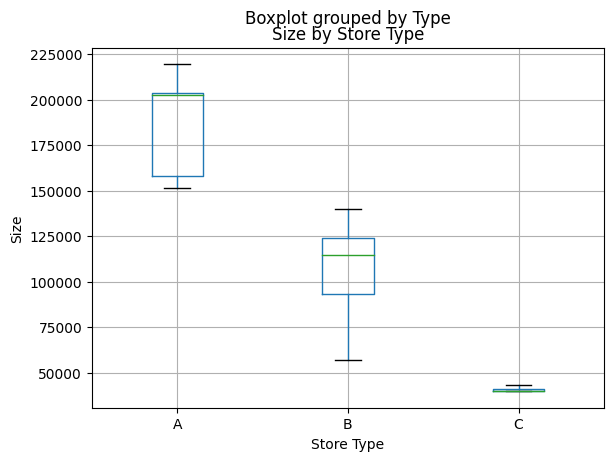

<Figure size 800x600 with 0 Axes>

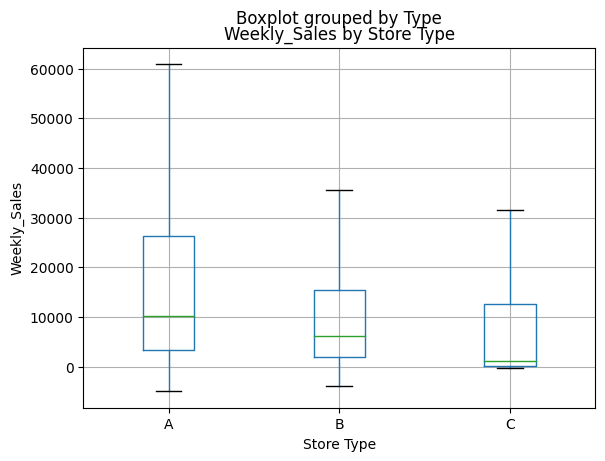

<Figure size 800x600 with 0 Axes>

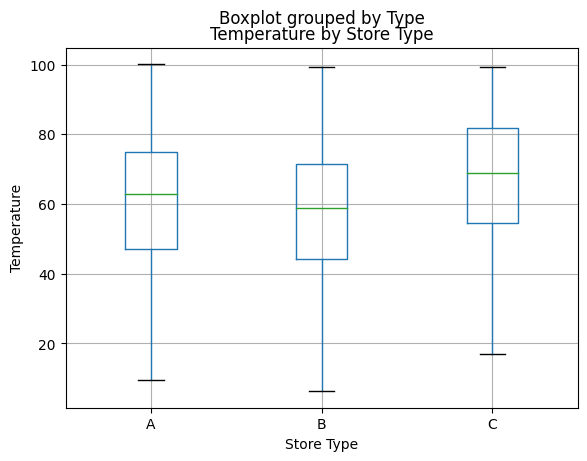

<Figure size 800x600 with 0 Axes>

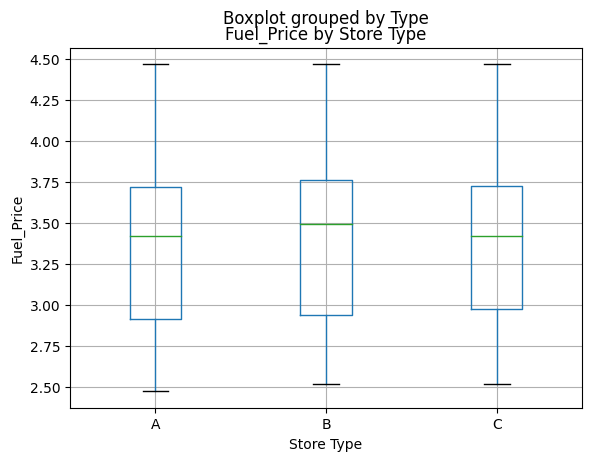

<Figure size 800x600 with 0 Axes>

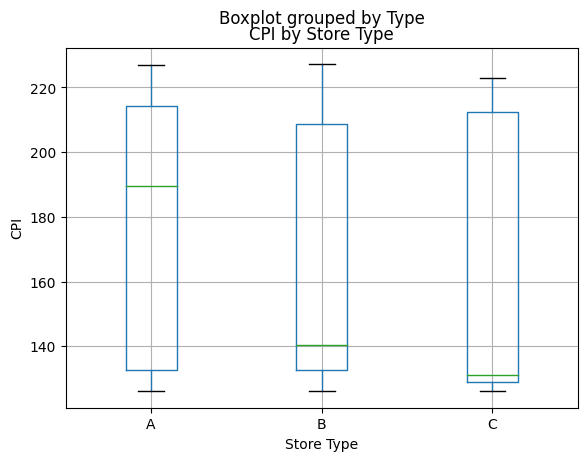

<Figure size 800x600 with 0 Axes>

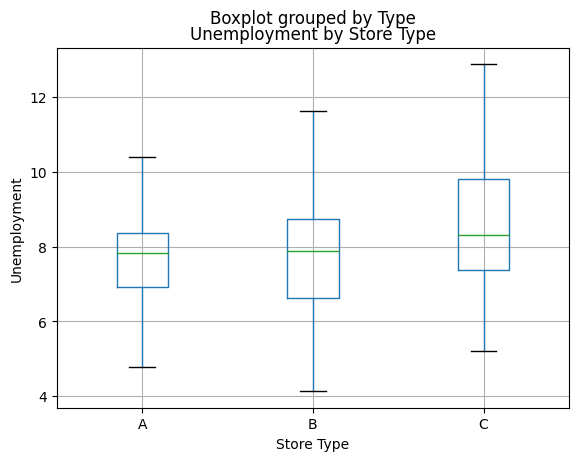

In [ ]:
# Descriptive statistics for each store type
store_type_stats = df.groupby('Type').describe()

# Print the descriptive statistics
print(store_type_stats)

# Visual comparison using box plots
numeric_columns = ['Size', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    df.boxplot(column=column, by='Type', showfliers=False)
    plt.title(f'{column} by Store Type')
    plt.xlabel('Store Type')
    plt.ylabel(column)
    plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


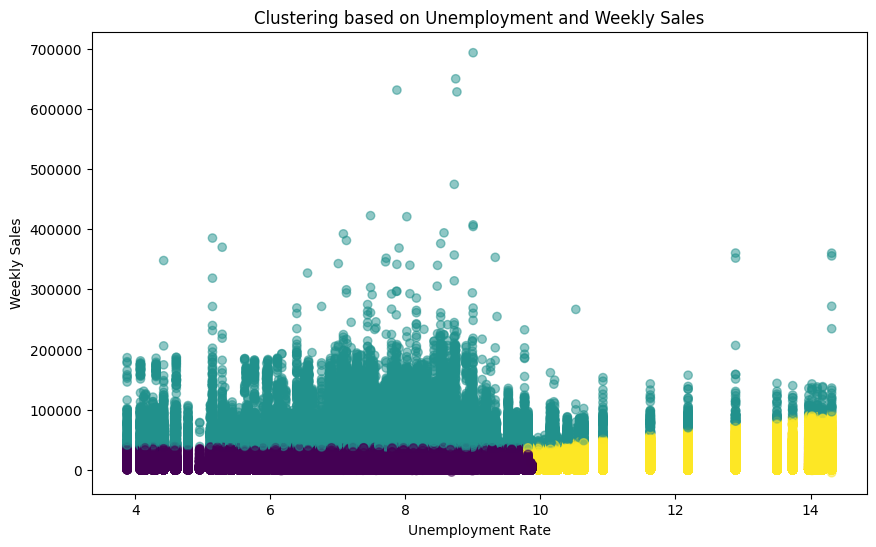

Average Sales by Cluster:
Cluster
0     9235.904194
1    65756.866771
2    11663.913595
Name: Weekly_Sales, dtype: float64

Average Unemployment Rate by Cluster:
Cluster
0     7.509512
1     7.605203
2    12.223830
Name: Unemployment, dtype: float64


In [ ]:
# Select relevant columns
selected_columns = ['Store', 'Unemployment', 'Dept', 'Weekly_Sales']

# Create a new DataFrame with the selected columns
data_for_clustering = df[selected_columns].copy()

# Fill missing values with the mean
data_for_clustering.fillna(data_for_clustering.mean(), inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering[['Unemployment', 'Weekly_Sales']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data_for_clustering['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_for_clustering['Unemployment'], data_for_clustering['Weekly_Sales'], c=data_for_clustering['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering based on Unemployment and Weekly Sales')
plt.xlabel('Unemployment Rate')
plt.ylabel('Weekly Sales')
plt.show()

# Analyze the relationship between unemployment rates and sales performance in individual departments
average_sales_by_cluster = data_for_clustering.groupby('Cluster')['Weekly_Sales'].mean()
average_unemployment_by_cluster = data_for_clustering.groupby('Cluster')['Unemployment'].mean()

# Print the results
print("Average Sales by Cluster:")
print(average_sales_by_cluster)
print("\nAverage Unemployment Rate by Cluster:")
print(average_unemployment_by_cluster)

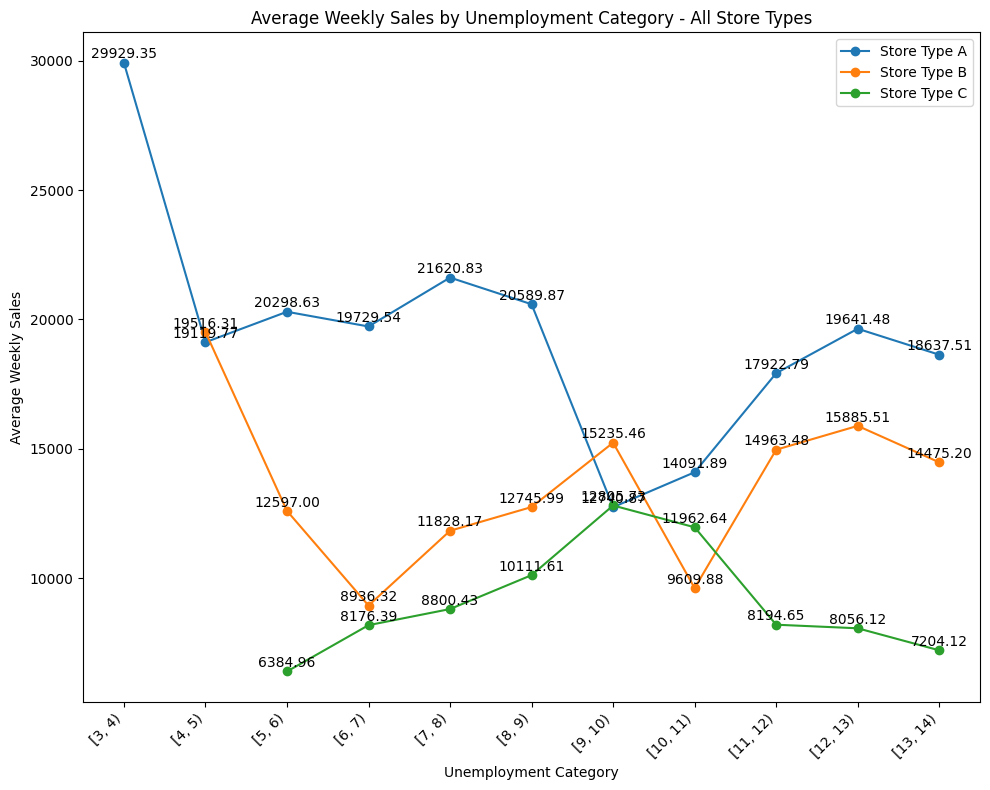

In [ ]:
# Bin the unemployment rates into categories
df['Unemployment_Category'] = pd.cut(df['Unemployment'], bins=np.arange(0, 15, 1), right=False)

# Separate the data by store type
store_types = df['Type'].unique()

# Plot a line chart for all store types
plt.figure(figsize=(10, 8))

for store_type in store_types:
    subset = df[df['Type'] == store_type]
    average_sales_by_unemployment = subset.groupby('Unemployment_Category')['Weekly_Sales'].mean()

    plt.plot(average_sales_by_unemployment.index.astype(str), average_sales_by_unemployment, marker='o', label=f'Store Type {store_type}')

    # Display values on top of each data point for the combined chart
    for i, value in enumerate(average_sales_by_unemployment):
        plt.text(i, value + 50, f'{value:.2f}', ha='center', va='bottom')

# Customize the overall chart
plt.title('Average Weekly Sales by Unemployment Category - All Store Types')
plt.xlabel('Unemployment Category')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

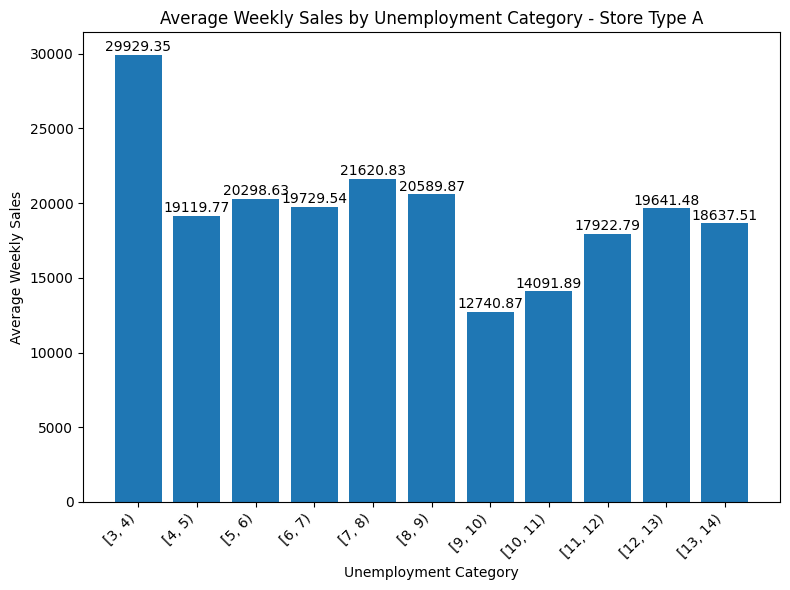

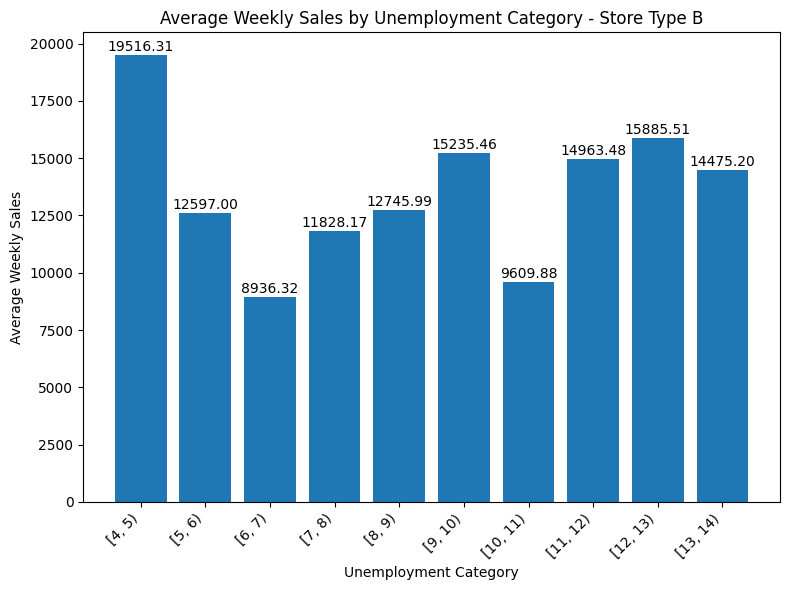

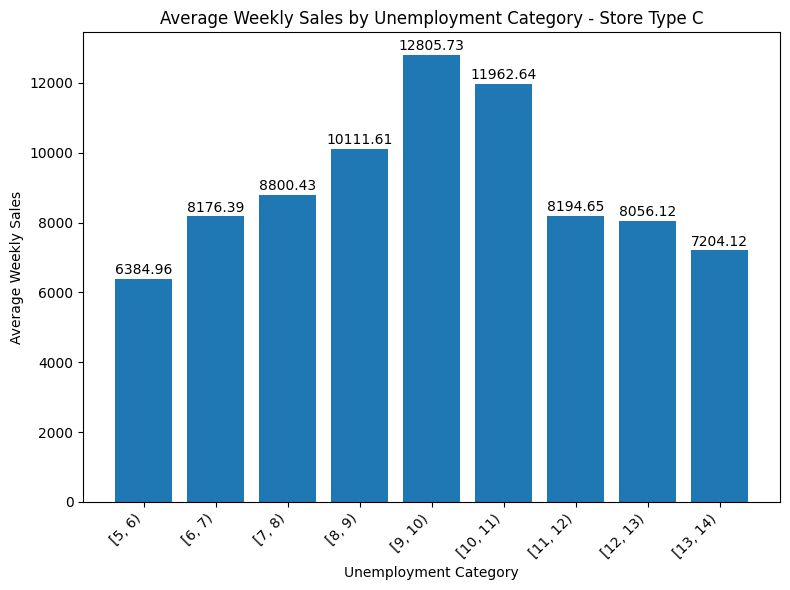

In [ ]:
# Separate the data by store type
store_types = df['Type'].unique()

# Plot a bar chart for each store type
for store_type in store_types:
    subset = df[df['Type'] == store_type]
    average_sales_by_unemployment = subset.groupby('Unemployment_Category')['Weekly_Sales'].mean()

    plt.figure(figsize=(8, 6))
    plt.bar(average_sales_by_unemployment.index.astype(str), average_sales_by_unemployment)
    plt.title(f'Average Weekly Sales by Unemployment Category - Store Type {store_type}')
    plt.xlabel('Unemployment Category')
    plt.ylabel('Average Weekly Sales')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Display values on top of each bar
    for i, value in enumerate(average_sales_by_unemployment):
        plt.text(i, value + 50, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Question 6: How do different store types respond to special holiday weeks? Do certain store types experience more significant increases in sales during holidays, and are there specific departments that contribute more to this boost?

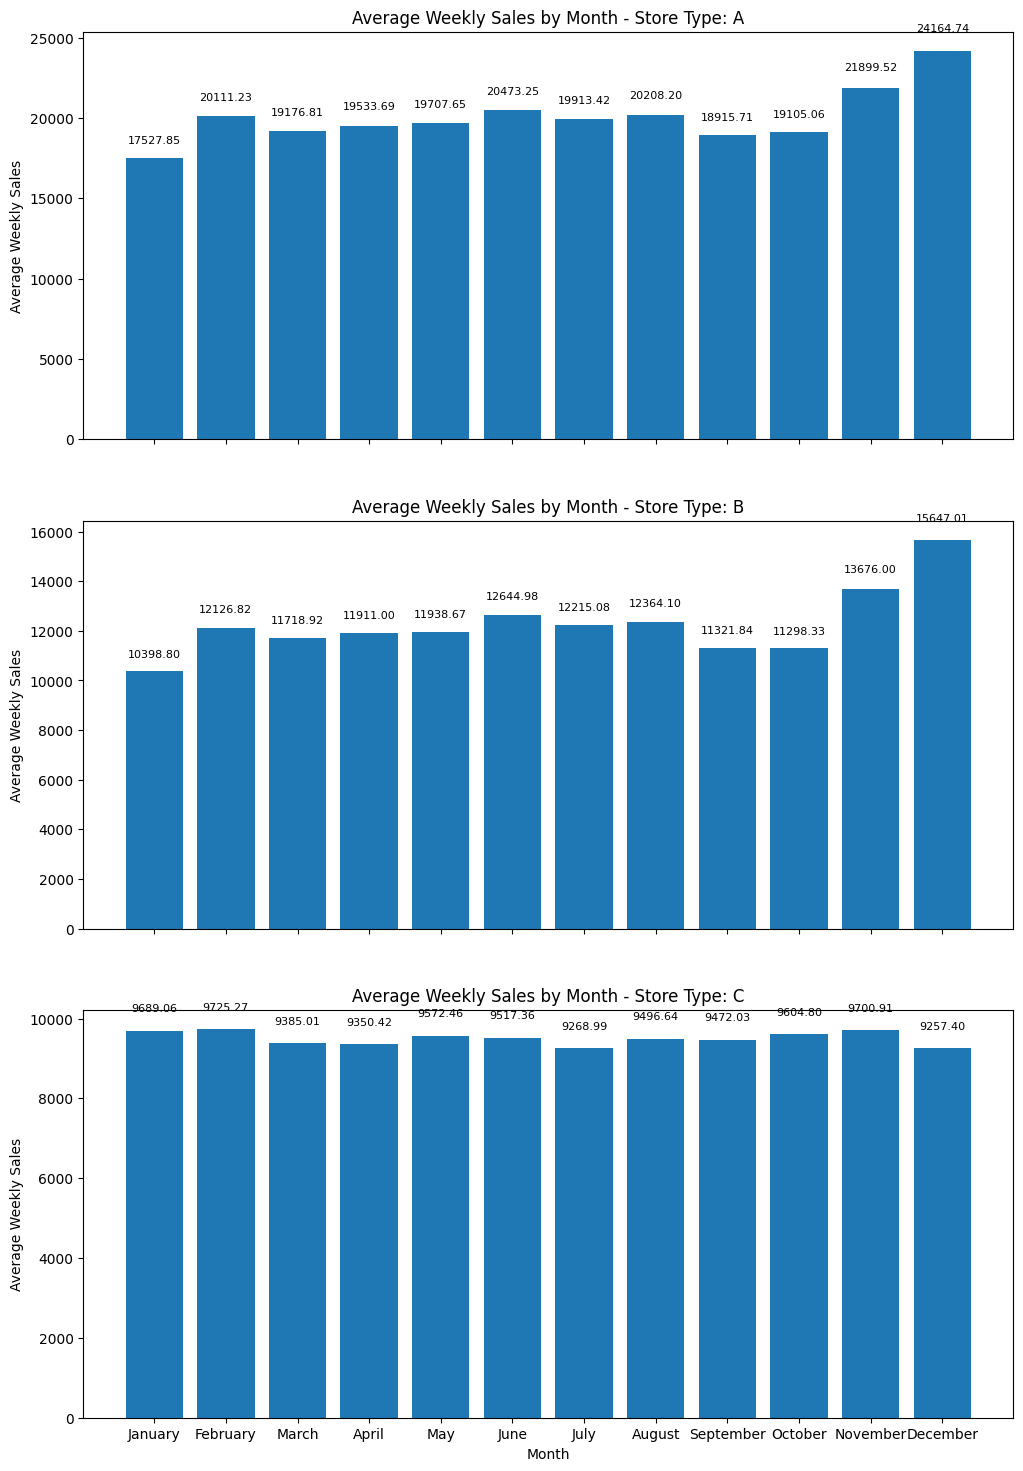

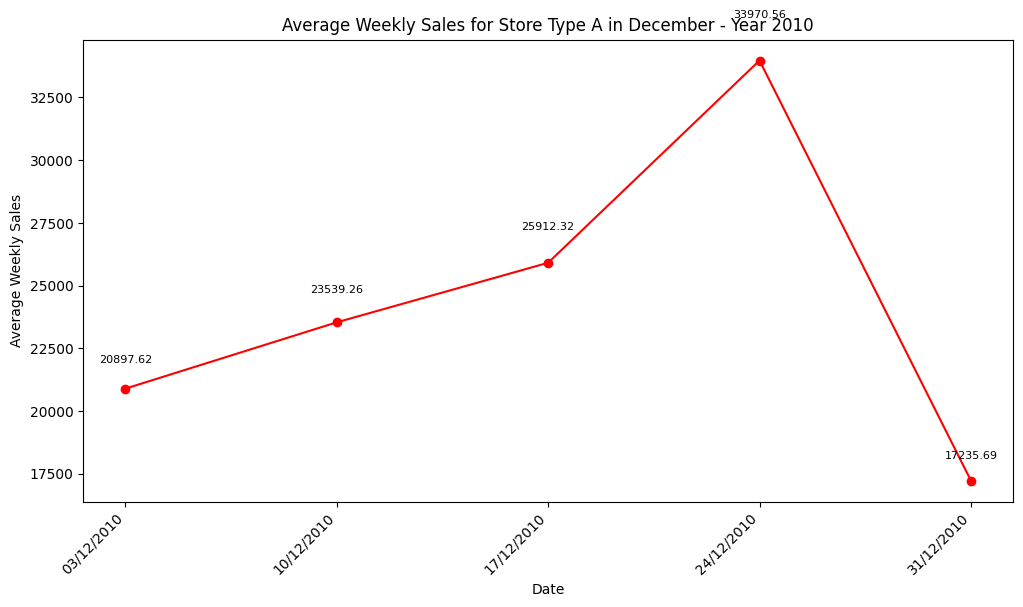

Store Type: A, Year: 2010, Date: ['03/12/2010', '10/12/2010', '17/12/2010', '24/12/2010', '31/12/2010'], Average Weekly Sales: [20897.616975512905, 23539.25694904037, 25912.316805555554, 33970.56266490765, 17235.694469496022]


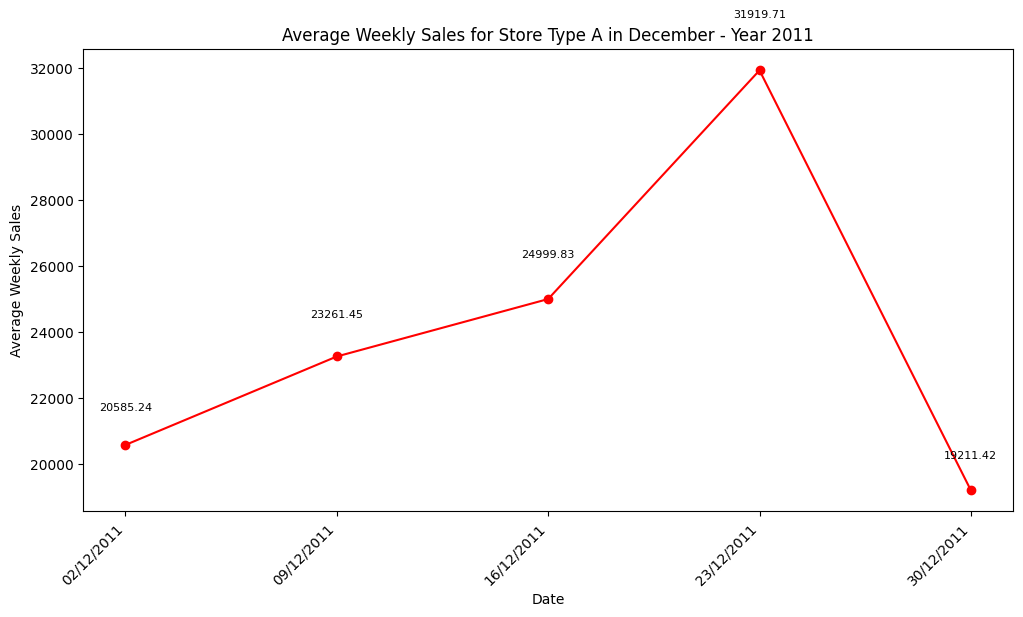

Store Type: A, Year: 2011, Date: ['02/12/2011', '09/12/2011', '16/12/2011', '23/12/2011', '30/12/2011'], Average Weekly Sales: [20585.237196323047, 23261.445775749675, 24999.82647712418, 31919.707900194426, 19211.415336381448]


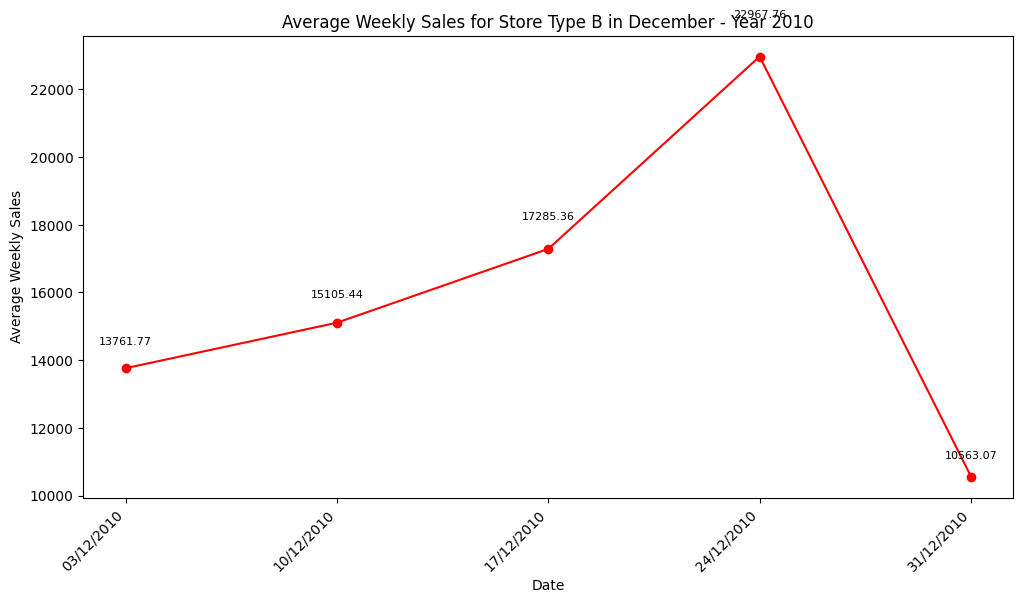

Store Type: B, Year: 2010, Date: ['03/12/2010', '10/12/2010', '17/12/2010', '24/12/2010', '31/12/2010'], Average Weekly Sales: [13761.773924825175, 15105.43635888502, 17285.364404865333, 22967.76322019147, 10563.070166229221]


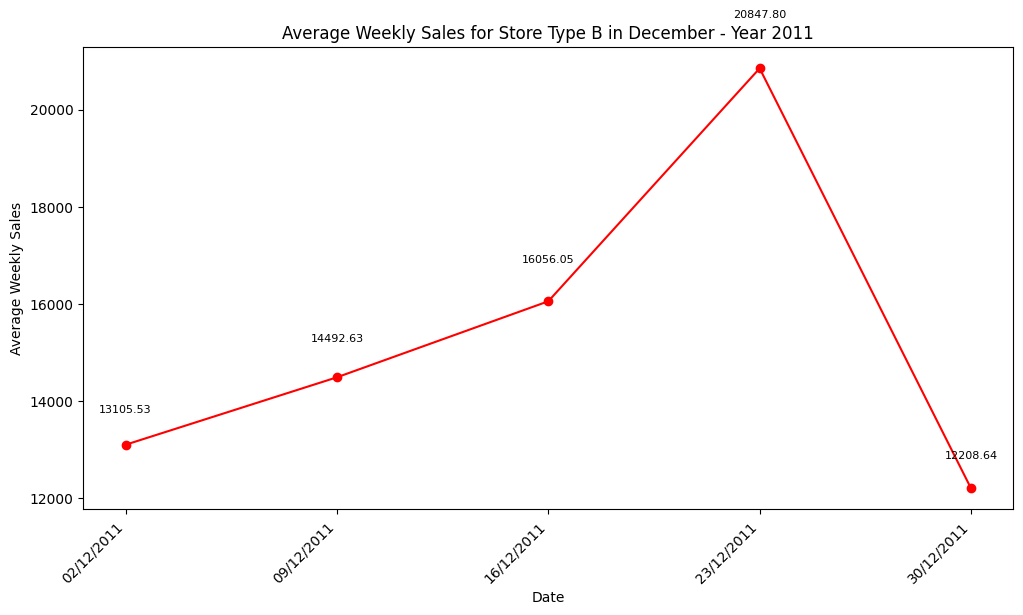

Store Type: B, Year: 2011, Date: ['02/12/2011', '09/12/2011', '16/12/2011', '23/12/2011', '30/12/2011'], Average Weekly Sales: [13105.533989726027, 14492.628630136986, 16056.052397959185, 20847.796601694914, 12208.641312178388]


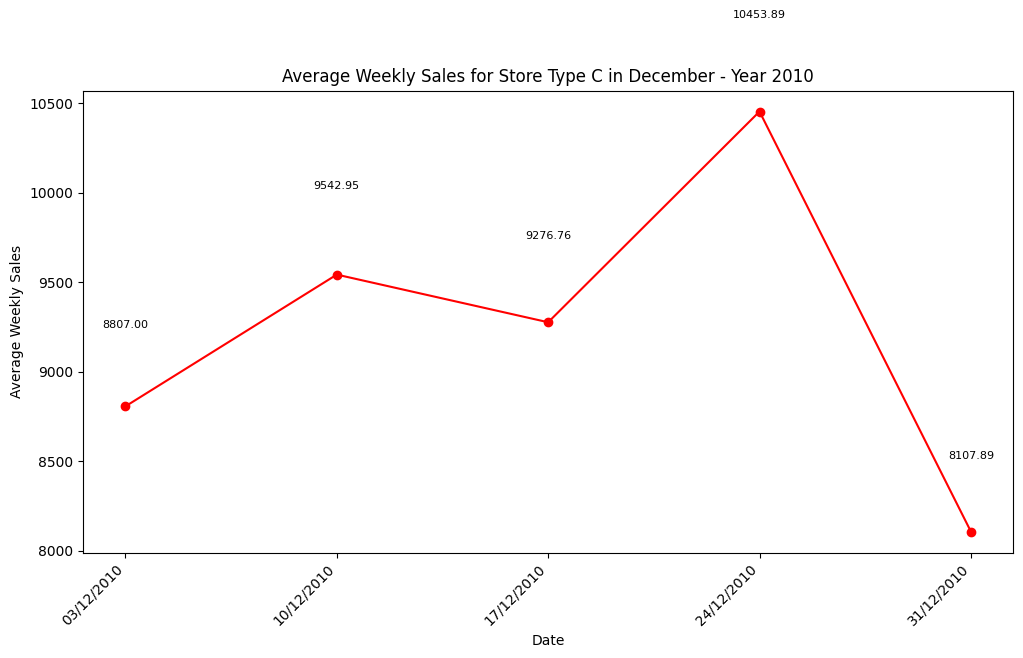

Store Type: C, Year: 2010, Date: ['03/12/2010', '10/12/2010', '17/12/2010', '24/12/2010', '31/12/2010'], Average Weekly Sales: [8807.004285714285, 9542.948788927337, 9276.76489864865, 10453.892302405498, 8107.885410958905]


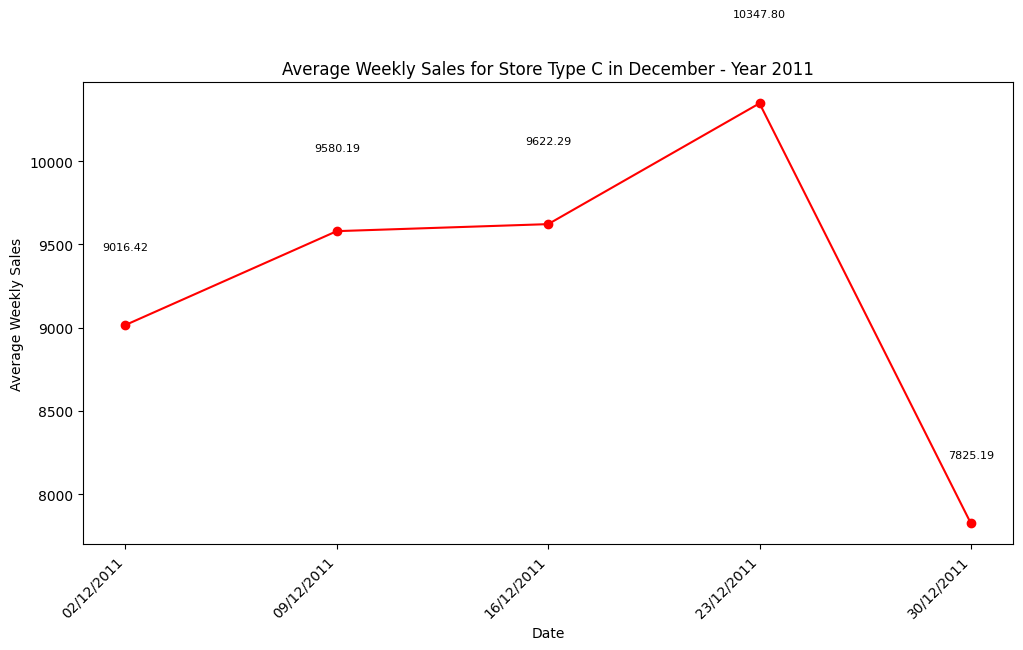

Store Type: C, Year: 2011, Date: ['02/12/2011', '09/12/2011', '16/12/2011', '23/12/2011', '30/12/2011'], Average Weekly Sales: [9016.424224422442, 9580.193636363636, 9622.292540716613, 10347.802730263158, 7825.190816993464]


In [ ]:
df['Month'] = pd.to_datetime(df['Date'], format='%d/%m/%Y').dt.month_name()
df['Year'] = pd.to_datetime(df['Date'], format='%d/%m/%Y').dt.year

# Remove data for the year 2012
df = df[df['Year'] != 2012]

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# List of unique store types
unique_stores = df['Type'].unique()

# Create subplots for each store type
fig, axs = plt.subplots(len(unique_stores), 1, figsize=(12, 6 * len(unique_stores)), sharex=True)

for i, store_type in enumerate(unique_stores):
    store_data = df[df['Type'] == store_type]
    average_sales_by_month = store_data.groupby('Month')['Weekly_Sales'].mean().reindex(month_order)

    axs[i].bar(average_sales_by_month.index, average_sales_by_month)
    axs[i].set_title(f'Average Weekly Sales by Month - Store Type: {store_type}')
    axs[i].set_ylabel('Average Weekly Sales')

    # Add annotations for each bar
    for month, value in zip(average_sales_by_month.index, average_sales_by_month):
        axs[i].annotate(f'{value:.2f}', xy=(month, value),
                        xytext=(month, value + value * 0.05),
                        ha='center', fontsize=8, color='black')

plt.xlabel('Month')
plt.show()

# Print all data points for line graphs
for store_type in unique_stores:
    store_december_data = df[(df['Type'] == store_type) & (df['Month'] == 'December')]
    average_sales_december_store = store_december_data.groupby(['Year', 'Date'])['Weekly_Sales'].mean()

    for year in average_sales_december_store.index.levels[0]:
        plt.figure(figsize=(12, 6))
        plt.plot(average_sales_december_store.loc[year].index, average_sales_december_store.loc[year], marker='o', linestyle='-', color='r')

        for date, value in zip(average_sales_december_store.loc[year].index, average_sales_december_store.loc[year]):
            plt.annotate(f'{value:.2f}', xy=(date, value), xytext=(date, value + value * 0.05),
                         ha='center', fontsize=8, color='black')

        plt.title(f'Average Weekly Sales for Store Type {store_type} in December - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Average Weekly Sales')
        plt.xticks(rotation=45, ha='right')
        plt.show()
        # Print data points
        print(f'Store Type: {store_type}, Year: {year}, Date: {average_sales_december_store.loc[year].index.tolist()}, Average Weekly Sales: {average_sales_december_store.loc[year].tolist()}')

In [ ]:
# Filter data for Store Type A and the month of December
store_type_a_december = df[(df['Type'] == 'A') & (df['Date'].dt.month == 12)]

# Group by department and calculate total sales for each
department_sales = store_type_a_december.groupby('Dept')['Weekly_Sales'].sum()

# Find the department with the highest total weekly sales
max_department = department_sales.idxmax()
max_sales = department_sales.max()

# Plot the bar graph
plt.bar(department_sales.index, department_sales)
plt.title('Total Sales by Department - Store Type A (December)')
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')

# Highlight the bar with the highest sales
plt.bar(max_department, max_sales, color='red', label=f'Highest Sales: Department {max_department}\nTotal Sales: {max_sales:.2f}')

plt.legend()
plt.show()

AttributeError: ignored

In [ ]:
# Filter data for Store Type B and the month of December
store_type_b_december = df[(df['Type'] == 'B') & (df['Date'].dt.month == 12)]

# Group by department and calculate total sales for each
department_sales_b = store_type_b_december.groupby('Dept')['Weekly_Sales'].sum()

# Find the department with the highest total weekly sales
max_department_b = department_sales_b.idxmax()
max_sales_b = department_sales_b.max()

# Plot the bar graph
plt.bar(department_sales_b.index, department_sales_b)
plt.title('Total Sales by Department - Store Type B (December)')
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')

# Highlight the bar with the highest sales
plt.bar(max_department_b, max_sales_b, color='red', label=f'Highest Sales: Department {max_department_b}\nTotal Sales: {max_sales_b:.2f}')

plt.legend()
plt.show()

AttributeError: ignored

In [ ]:
# Filter data for Store Type C and the month of December
store_type_c_december = df[(df['Type'] == 'C') & (df['Date'].dt.month == 12)]

# Group by department and calculate total sales for each
department_sales_c = store_type_c_december.groupby('Dept')['Weekly_Sales'].sum()

# Find the department with the highest total weekly sales
max_department_c = department_sales_c.idxmax()
max_sales_c = department_sales_c.max()

# Plot the bar graph
plt.bar(department_sales_c.index, department_sales_c)
plt.title('Total Sales by Department - Store Type C (December)')
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')

# Highlight the bar with the highest sales
plt.bar(max_department_c, max_sales_c, color='red', label=f'Highest Sales: Department {max_department_c}\nTotal Sales: {max_sales_c:.2f}')

plt.legend()
plt.show()

AttributeError: ignored